# IMPORT DEPENDENCIES

In [1]:
try:
    import pandas as pd
    import rdkit
    import torch_geometric
except:
    !pip install rdkit
    !pip install pandas
    !pip install torch_geometric
    import pandas as pd
    import rdkit
    import torch_geometric
    
from rdkit import Chem
from rdkit.Chem import Draw
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from rdkit.Chem import rdmolops 
from tqdm import tqdm
import numpy as np
import os
import torch
import torch.nn.functional as F 
from torch.nn import Linear, BatchNorm1d, ModuleList,ReLU,Sequential
from torch_geometric.nn import TransformerConv, TopKPooling, GATConv,BatchNorm
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score,recall_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data visualization using rdkit

(41127, 3)
0    39684
1     1443
Name: HIV_active, dtype: int64


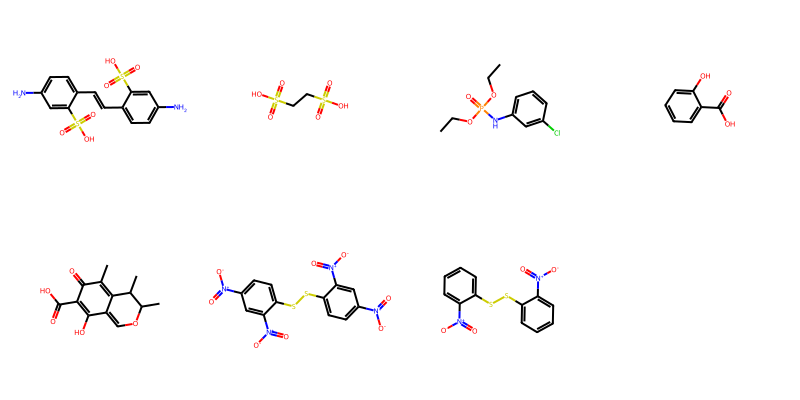

In [3]:
data_set = pd.read_csv("data/raw/HIV.csv")
smiles = data_set["smiles"][3:10].values
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
grid = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200,200))
print(data_set.shape)
print(data_set["HIV_active"].value_counts())
grid

# Data preprocessing of molecules into graph dataset
edge are bond type, ring
nodes are aromacity, Atomic number, Atom degree, formal charge, hybridization

In [4]:
from torch_geometric.data import Dataset, Data
import torch
import torch_geometric
import numpy as np
import rdkit
from rdkit import Chem
import os
from rdkit.Chem import rdmolops
from tqdm import tqdm

#https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
#https://moleculenet.org/models
class HIVDataset(Dataset):
    def __init__(self,root, filename, test=False, transform=None, pre_transform=None):
        
        self.filename = filename
        self.test = test
        super(HIVDataset, self).__init__(root,transform,pre_transform)
    
    @property
    def raw_file_names(self):
        return self.filename
    
    @property
    def processed_file_names(self):
        
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        
        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
    
    def download(self):
        pass
    
    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            #node features
            node_features = self.get_node_features(mol_obj)
            #edge features
            edge_features = self.get_edge_features(mol_obj)
            #Edge indexes
            edge_index = self.get_adjacency_info(mol_obj)
            #label information
            label = self.get_labels(mol["HIV_active"])
            
            #data object
            data = Data(x=node_features,
                       edge_index=edge_index,
                       edge_attr=edge_features,
                       y=label,
                       smiles=mol["smiles"])
            
            if self.test:
                torch.save(data,
                      os.path.join(self.processed_dir, f'data_{index}.pt'))
                
            else:
                torch.save(data,
                      os.path.join(self.processed_dir, f'data_{index}.pt'))
            
    
    def get_node_features(self, mol):
        all_node_features = []
        
        for atom in mol.GetAtoms():
            node_features = []
            #Atomic number
            node_features.append(atom.GetAtomicNum())
            #Atom degree
            node_features.append(atom.GetDegree())
            #formal charge
            node_features.append(atom.GetFormalCharge())
            #Hybridization
            node_features.append(atom.GetHybridization())
            #Aromaticity
            node_features.append(atom.GetIsAromatic())
            #node features to matrix
            all_node_features.append(node_features)
        
        all_node_features = np.asarray(all_node_features)
        return torch.tensor(all_node_features, dtype=torch.float)
    
    def get_edge_features(self, mol):
        all_edge_features = []
        for bond in mol.GetBonds():
            edge_features = []
            #Bond types (as double)
            edge_features.append(bond.GetBondTypeAsDouble())
            #Rings
            edge_features.append(bond.IsInRing())
            #edge features to matrix
            all_edge_features.append(edge_features)
            
        all_edge_features = np.asarray(all_edge_features)
        return torch.tensor(all_edge_features, dtype=torch.float)
    
    def get_adjacency_info(self, mol):
        adj_matrix = rdmolops.GetAdjacencyMatrix(mol)
        row,col = np.where(adj_matrix)
        coo = np.array(list(zip(row,col)))
        coo = np.reshape(coo, (2, -1))
        return torch.tensor(coo,dtype=torch.long)
    
    def get_labels(self,label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)
    
    def len(self):
        return self.data.shape[0]
    
    def get(self, idx):
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
            
        else:
            data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        
        return data

In [5]:
dataset = HIVDataset(root="data/", filename="HIV.csv")
print(dataset[0].edge_index.t())
print(dataset[0].x)
print(dataset[0].edge_attr)
print(dataset[0].y)

tensor([[ 0,  9],
        [ 1,  2],
        [ 1,  9],
        [ 0,  6],
        [ 1, 10],
        [ 2,  4],
        [ 2, 10],
        [ 1, 11],
        [ 2, 11],
        [ 3, 10],
        [ 2, 11],
        [ 9, 12],
        [ 3, 11],
        [ 2, 14],
        [ 3, 12],
        [ 4, 11],
        [ 4, 12],
        [ 3, 13],
        [ 4, 13],
        [ 5, 12],
        [ 4, 14],
        [10, 11],
        [ 4, 14],
        [18, 15],
        [ 5, 15],
        [ 4, 14],
        [ 5, 15],
        [ 6, 16],
        [ 6, 15],
        [ 5, 18],
        [ 6, 16],
        [ 7, 15],
        [ 6, 16],
        [ 9, 17],
        [ 7, 17],
        [ 6, 16],
        [ 7, 18],
        [ 8,  4],
        [ 8, 18],
        [ 7, 15]])
tensor([[ 6.,  1.,  0.,  4.,  0.],
        [ 6.,  2.,  0.,  4.,  0.],
        [ 6.,  3.,  0.,  3.,  0.],
        [ 8.,  2.,  1.,  3.,  0.],
        [29.,  4., -3.,  0.,  0.],
        [ 8.,  2.,  1.,  3.,  0.],
        [ 6.,  3.,  0.,  3.,  0.],
        [ 6.,  2.,  0.,  4.,  0.],

# Model Building Configuration
layers 3
Kpool 3
transform 3

In [6]:
#https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html
class GNN(torch.nn.Module):
    def __init__(self, feature_size):
        super(GNN, self).__init__()
        noOfclasses = 2
        embedding_size = 1024
        
        # First GATConv layer
        self.conv1 = GATConv(feature_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform1 = Linear(embedding_size*3, embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.8)
        
        # Second GATConv layer
        self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform2 = Linear(embedding_size*3, embedding_size)
        self.pool2 = TopKPooling(embedding_size, ratio=0.5)
        
        # Third GATConv layer
        self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout=0.3)
        self.head_transform3 = Linear(embedding_size*3, embedding_size)
        self.pool3 = TopKPooling(embedding_size, ratio=0.2)
        
        self.linear1 = Linear(embedding_size*2, 1024)
        self.linear2 = Linear(1024,noOfclasses)
        
    def forward(self, x, edge_attr, edge_index, batch_index):
        
        # Pass through the first GATConv layer and apply head transformation
        x = self.conv1(x, edge_index)
        x = self.head_transform1(x)
        
        
        
        # Apply pooling and concatenate global maximum and average pooling
        x, edge_index, edge_attr, batch_index, _, _ = self.pool1(x,
                                                                edge_index,None,
                                                                batch_index)
        x1 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        
        # Pass through the second GATConv layer and apply head transformation
        x = self.conv2(x, edge_index)
        x = self.head_transform2(x)
        
        # Apply pooling and concatenate global maximum and average pooling
        x, edge_index, edge_attr, batch_index, _, _ = self.pool2(x,
                                                                edge_index,None,
                                                                batch_index)
        x2 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        # Pass through the third GATConv layer and apply head transformation
        x = self.conv3(x, edge_index)
        x = self.head_transform3(x)
        
        # Apply pooling and concatenate global maximum and average pooling
        x, edge_index, edge_attr, batch_index, _, _ = self.pool3(x,
                                                                edge_index,None,
                                                                batch_index)
        x3 = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        
        # Sum the outputs of the three branches
        x = x1 + x2 + x3
        # Apply linear transformation followed by ReLU activation
        x = self.linear1(x).relu()
        # Apply dropout regularization
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear2(x)
        
        return x

# Model Configuration and Parameters

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

train_dataset = HIVDataset(root="data/", filename="HIV_TRAINS.csv")
test_dataset = HIVDataset(root="data/", filename="HIV.csv")

model = GNN(feature_size=train_dataset[0].x.shape[1])
model = model.to(device)

print(f"Number of parameters: {count_parameters(model)}")

model

Number of parameters: 17878018


GNN(
  (conv1): GATConv(5, 1024, heads=3)
  (head_transform1): Linear(in_features=3072, out_features=1024, bias=True)
  (pool1): TopKPooling(1024, ratio=0.8, multiplier=1.0)
  (conv2): GATConv(1024, 1024, heads=3)
  (head_transform2): Linear(in_features=3072, out_features=1024, bias=True)
  (pool2): TopKPooling(1024, ratio=0.5, multiplier=1.0)
  (conv3): GATConv(1024, 1024, heads=3)
  (head_transform3): Linear(in_features=3072, out_features=1024, bias=True)
  (pool3): TopKPooling(1024, ratio=0.2, multiplier=1.0)
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=2, bias=True)
)

In [9]:
weights = torch.tensor([1, 10], dtype=torch.float32).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
No_Graph_Per_Batch = 256
train_loader = DataLoader(train_dataset,batch_size=No_Graph_Per_Batch,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=No_Graph_Per_Batch, shuffle=True)

def train(epoch):
    all_preds= []
    all_labels = []
    for _, batch in enumerate(tqdm(train_loader)):
        batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x.float(),batch.edge_attr.float(),batch.edge_index,batch.batch)
        loss = torch.sqrt(loss_fn(pred, batch.y))
        loss.backward()
        optimizer.step()
        
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch)
    return loss

def Predict(epoch):
    all_preds= []
    all_labels = []
    for batch in test_loader:
        batch.to(device)
        pred = model(batch.x.float(),batch.edge_attr.float(),batch.edge_index,batch.batch)
        loss = torch.sqrt(loss_fn(pred, batch.y))
        all_preds.append(np.argmax(pred.cpu().detach().numpy(), axis=1))
        all_labels.append(batch.y.cpu().detach().numpy())
        
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch)
    return loss

def calculate_metrics(y_pred, y_true, epoch):
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    cm=confusion_matrix(y_pred, y_true)
    sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Active','Inactive'],
            yticklabels=['Active','Inactive'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")

  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [12:10<00:00,  2.61s/it]


F1 Score: 0.381988946529685
Accuracy: 0.23666136192310913


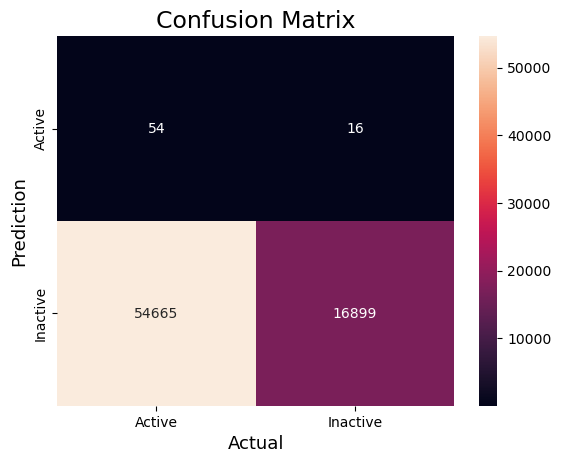

Precision: 0.23613828181767368
Recall: 0.9990540939994088
Epoch 0 | Train Loss 0.7195104360580444


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:03<00:00,  1.52it/s]

F1 Score: 0.38208847318241385
Accuracy: 0.23639612474523272


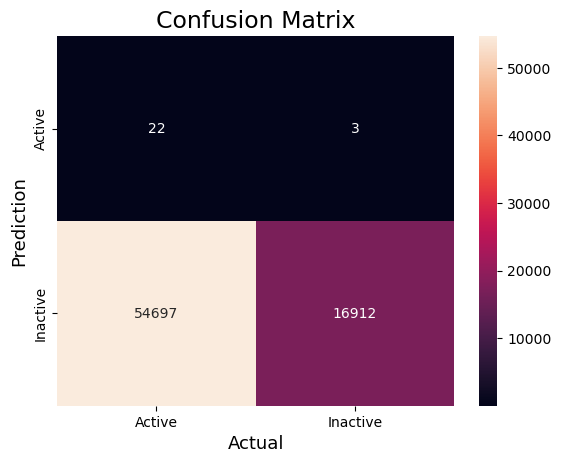

Precision: 0.23617143096538146
Recall: 0.9998226426248892
Epoch 1 | Train Loss 0.7167577743530273


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:46<00:00,  1.68it/s]

F1 Score: 0.38219599330710435
Accuracy: 0.23714995672446046


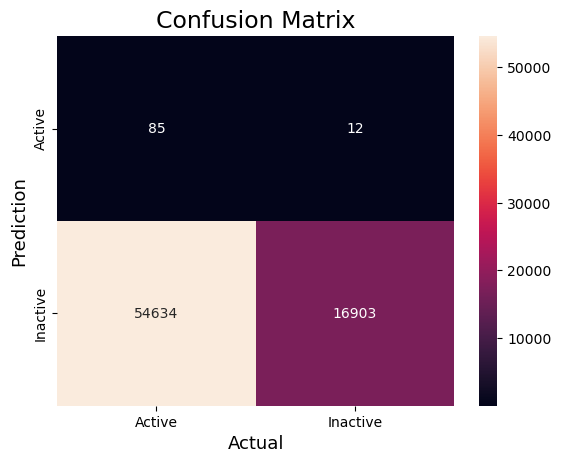

Precision: 0.23628332191732948
Recall: 0.9992905704995566
Epoch 2 | Train Loss 0.7343113422393799


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:47<00:00,  1.68it/s]

F1 Score: 0.3827818474587803
Accuracy: 0.2401652846413714


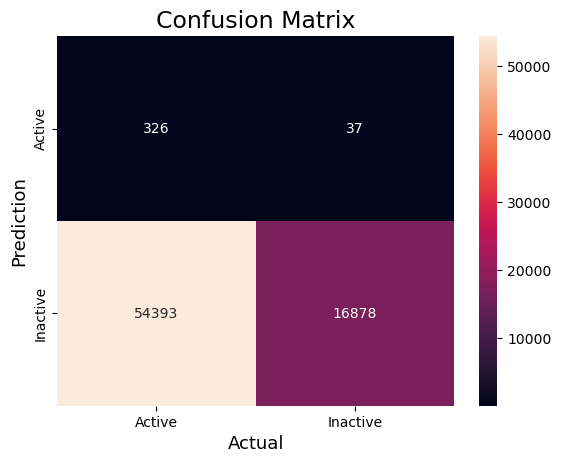

Precision: 0.23681441259418276
Recall: 0.9978125923736328
Epoch 3 | Train Loss 0.7539450526237488


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:46<00:00,  1.68it/s]

F1 Score: 0.3826670597038616
Accuracy: 0.23988608761202782


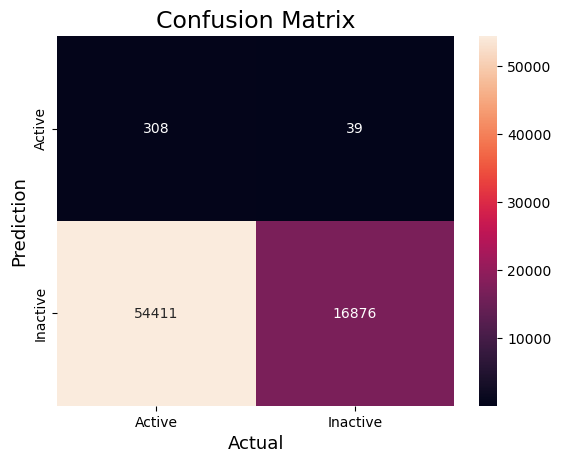

Precision: 0.23673320521273164
Recall: 0.997694354123559
Epoch 4 | Train Loss 0.7065879702568054


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:44<00:00,  1.71it/s]

F1 Score: 0.38263432328270236
Accuracy: 0.2396906496914873


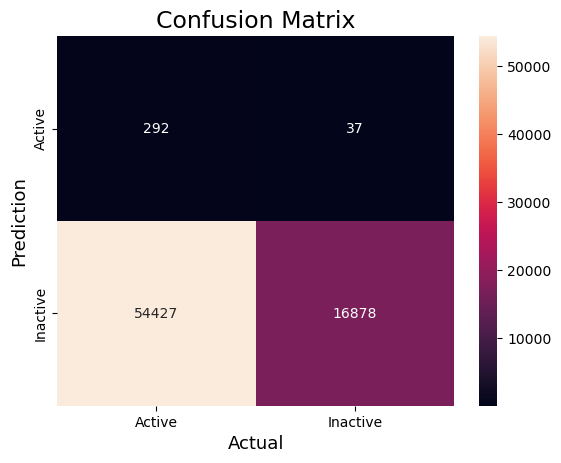

Precision: 0.23670149358390014
Recall: 0.9978125923736328
Epoch 5 | Train Loss 0.7327481508255005


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:50<00:00,  1.64it/s]

F1 Score: 0.383094178548724
Accuracy: 0.2413937515704833


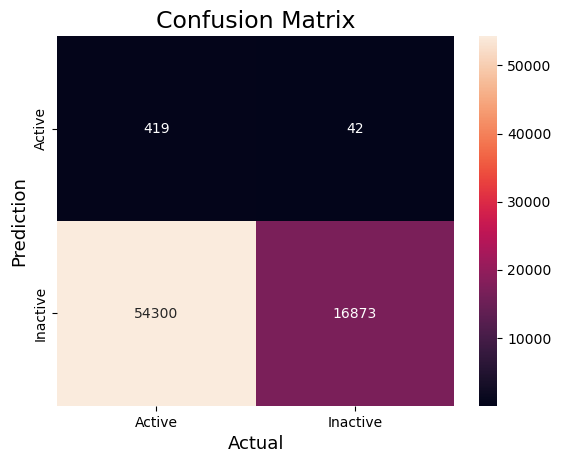

Precision: 0.23707023730909194
Recall: 0.9975169967484481
Epoch 6 | Train Loss 0.7656022906303406


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:45<00:00,  1.70it/s]

F1 Score: 0.3831267765776009
Accuracy: 0.24262221849959517


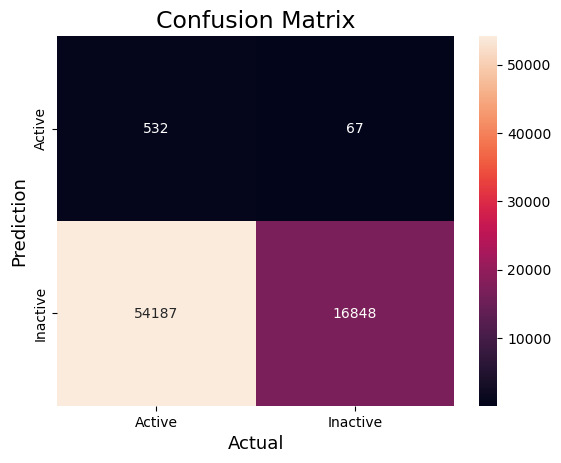

Precision: 0.23717885549377068
Recall: 0.9960390186225244
Epoch 7 | Train Loss 0.7037242650985718


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:28<00:00,  1.88it/s]

F1 Score: 0.38309219858156024
Accuracy: 0.24107267498673815


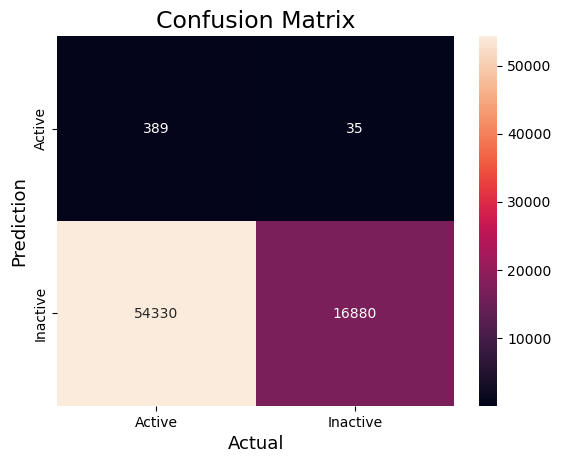

Precision: 0.23704535879792163
Recall: 0.9979308306237068
Epoch 8 | Train Loss 0.6666131615638733


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.3830907893840671
Accuracy: 0.24133791216461456


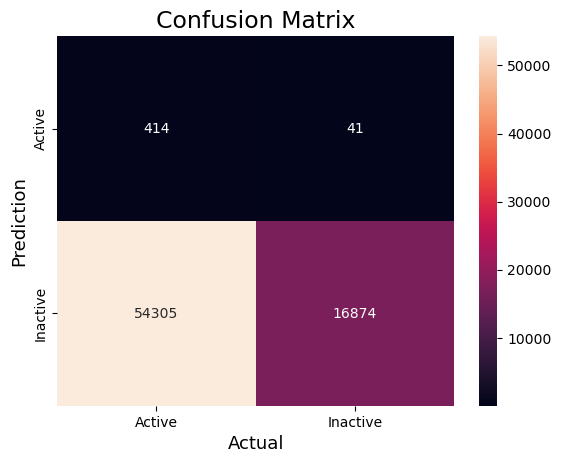

Precision: 0.23706430267354137
Recall: 0.997576115873485
Epoch 9 | Train Loss 0.7431506514549255


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.3843934261698658
Accuracy: 0.24648909735600413


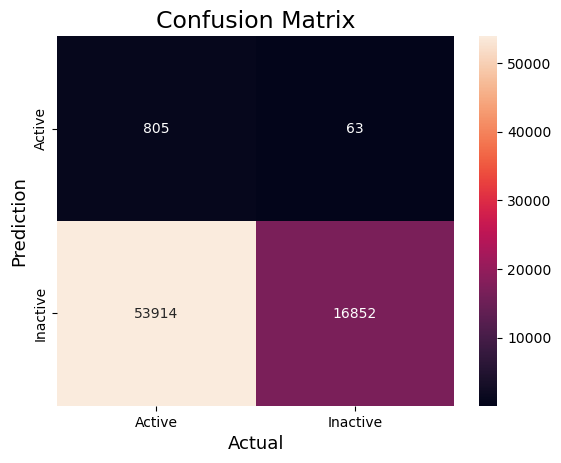

Precision: 0.23813695842636295
Recall: 0.9962754951226722
Epoch 10 | Train Loss 0.7378146052360535


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.07it/s]

F1 Score: 0.38379642836766126
Accuracy: 0.2461540609207918


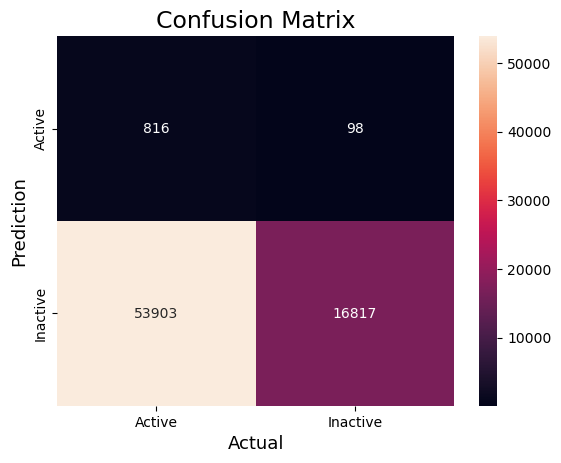

Precision: 0.23779694570135745
Recall: 0.9942063257463789
Epoch 11 | Train Loss 0.7075831294059753


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.384096126828934
Accuracy: 0.24724292933523187


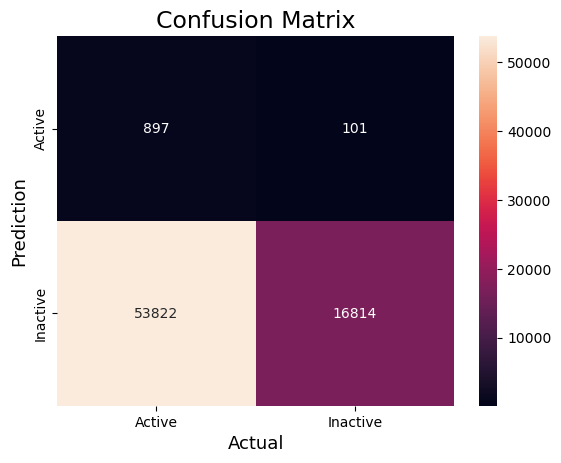

Precision: 0.2380372614530834
Recall: 0.9940289683712681
Epoch 12 | Train Loss 0.7321045398712158


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.06it/s]

F1 Score: 0.3844352821590507
Accuracy: 0.24760588547337856


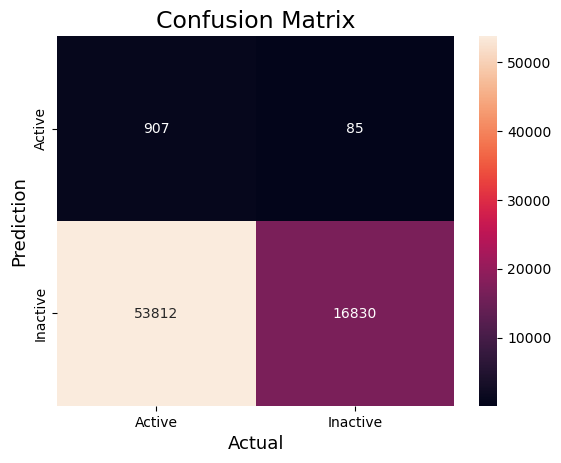

Precision: 0.23824353783867955
Recall: 0.9949748743718593
Epoch 13 | Train Loss 0.7103103995323181


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.09it/s]

F1 Score: 0.3856632142816089
Accuracy: 0.25394365803947844


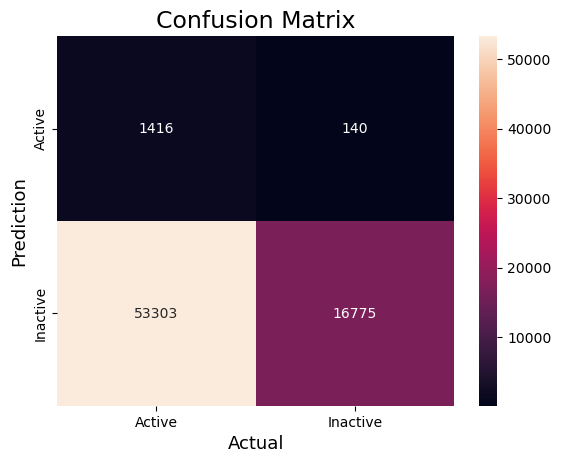

Precision: 0.23937612374782385
Recall: 0.9917233224948271
Epoch 14 | Train Loss 0.7121564745903015


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.38559867574029794
Accuracy: 0.2538738587821426


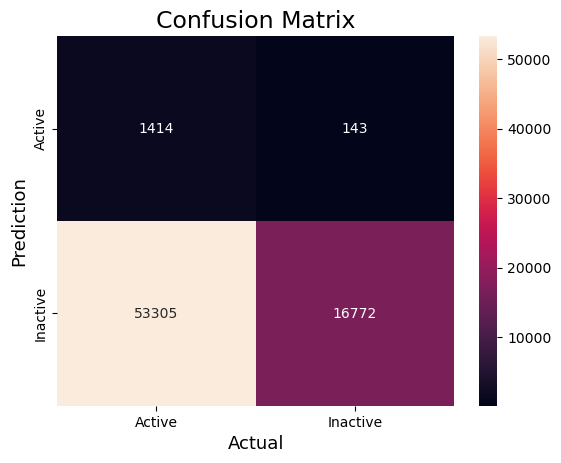

Precision: 0.23933672959744282
Recall: 0.9915459651197163
Epoch 15 | Train Loss 0.7092462182044983


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.3865519071463185
Accuracy: 0.2577546974900187


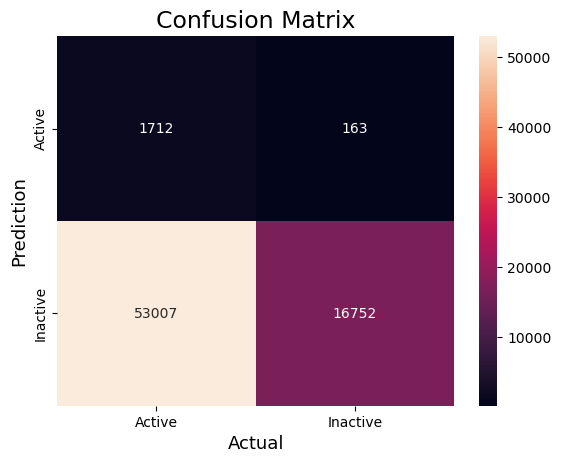

Precision: 0.24014105706790523
Recall: 0.9903635826189773
Epoch 16 | Train Loss 0.7257516384124756


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.06it/s]

F1 Score: 0.3877157972897716
Accuracy: 0.26328279867102217


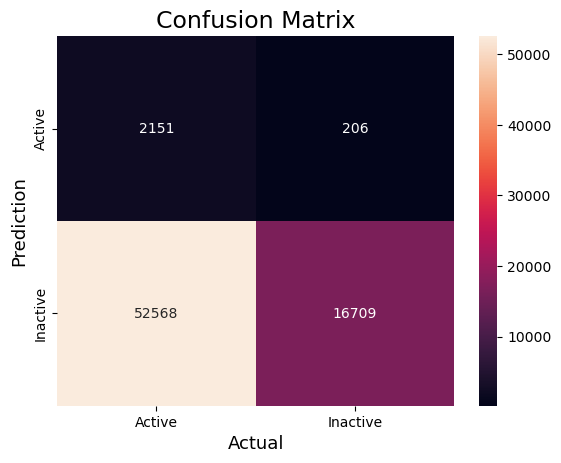

Precision: 0.2411911601252941
Recall: 0.9878214602423884
Epoch 17 | Train Loss 0.6979908347129822


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.3883870817356441
Accuracy: 0.2674288745567747


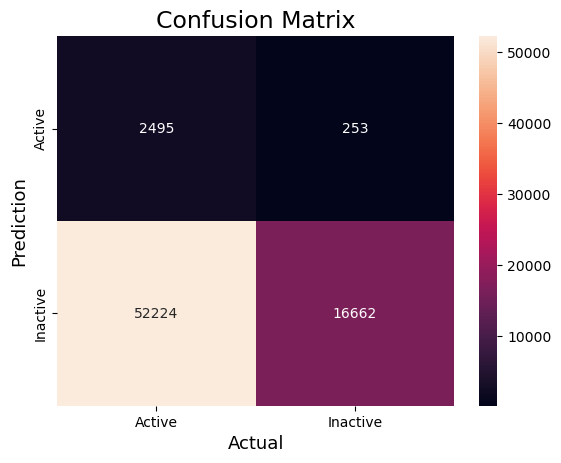

Precision: 0.2418778852016375
Recall: 0.9850428613656518
Epoch 18 | Train Loss 0.7002357840538025


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.06it/s]

F1 Score: 0.3908990584423208
Accuracy: 0.27573498617974707


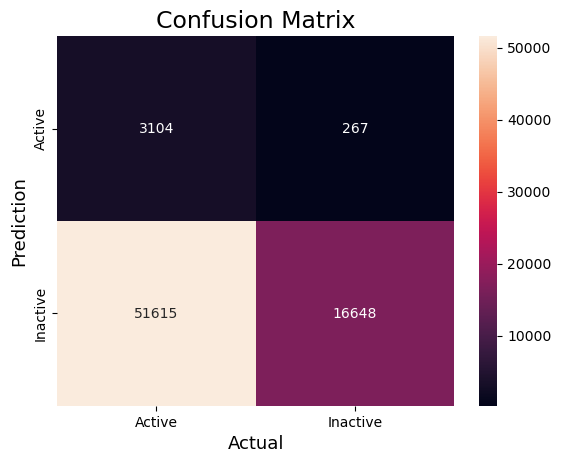

Precision: 0.24388028653882776
Recall: 0.9842151936151345
Epoch 19 | Train Loss 0.708458423614502


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.39252469267391454
Accuracy: 0.28394337884244913


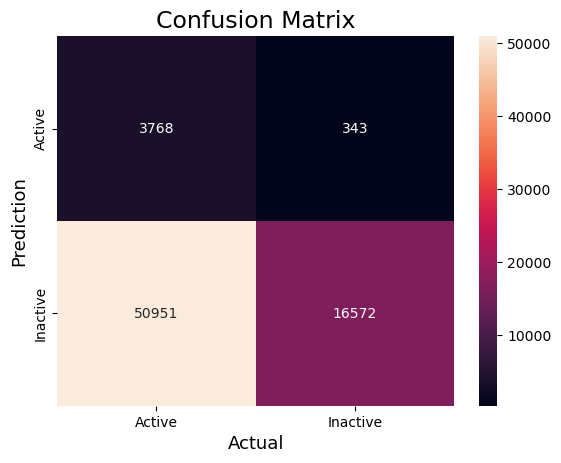

Precision: 0.24542748396842556
Recall: 0.9797221401123264
Epoch 20 | Train Loss 0.7189302444458008


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:25<00:00,  1.93it/s]

F1 Score: 0.39421466994407034
Accuracy: 0.28783817740179246


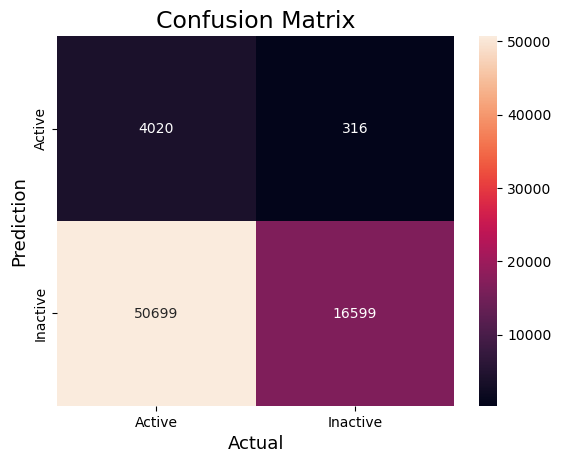

Precision: 0.2466492317750899
Recall: 0.981318356488324
Epoch 21 | Train Loss 0.7265670299530029


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:25<00:00,  1.93it/s]

F1 Score: 0.39596293765807233
Accuracy: 0.2965212050143786


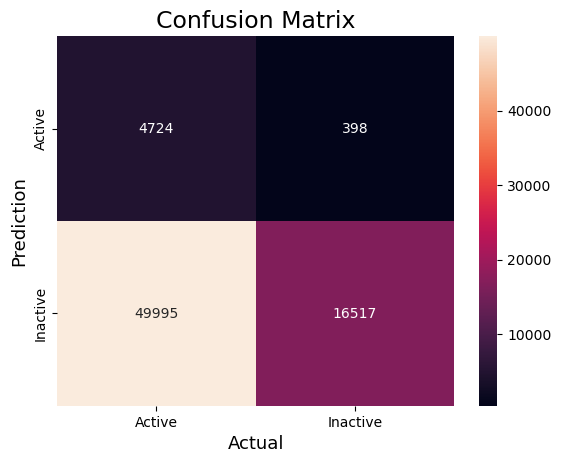

Precision: 0.24833112821746453
Recall: 0.9764705882352941
Epoch 22 | Train Loss 0.6750176548957825


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:27<00:00,  1.89it/s]

F1 Score: 0.39669659576511257
Accuracy: 0.29837786525951365


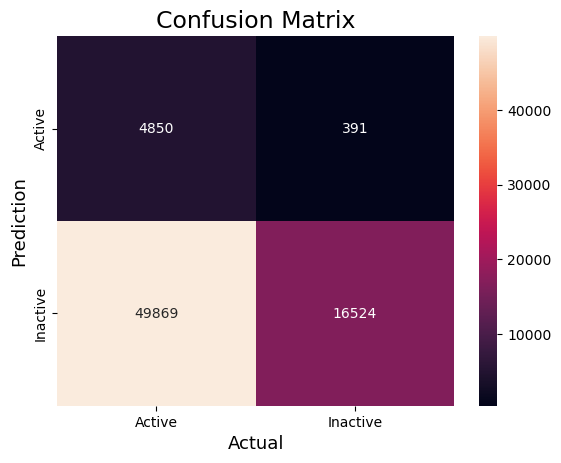

Precision: 0.2488816592110614
Recall: 0.9768844221105528
Epoch 23 | Train Loss 0.703579843044281


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:23<00:00,  1.95it/s]

F1 Score: 0.3969988817948995
Accuracy: 0.2998994890694363


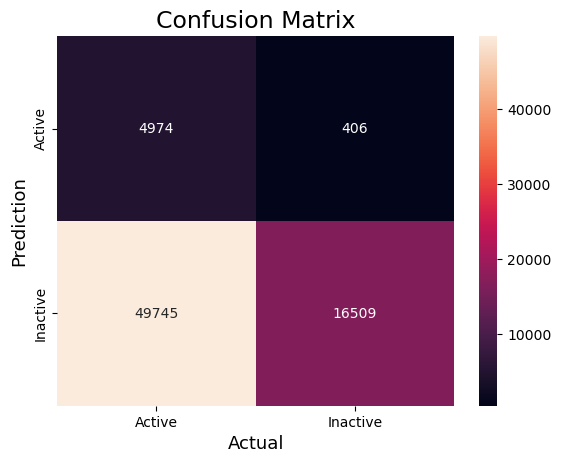

Precision: 0.24917740815648867
Recall: 0.9759976352349985
Epoch 24 | Train Loss 0.7088485956192017


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:22<00:00,  1.96it/s]

F1 Score: 0.39996593135167363
Accuracy: 0.3115699248959991


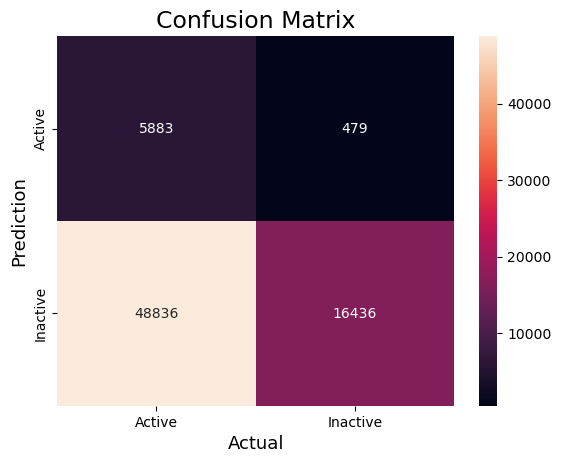

Precision: 0.25180781958573356
Recall: 0.9716819391073012
Epoch 25 | Train Loss 0.7163860201835632


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:23<00:00,  1.96it/s]

F1 Score: 0.4014745553751694
Accuracy: 0.315506603009744


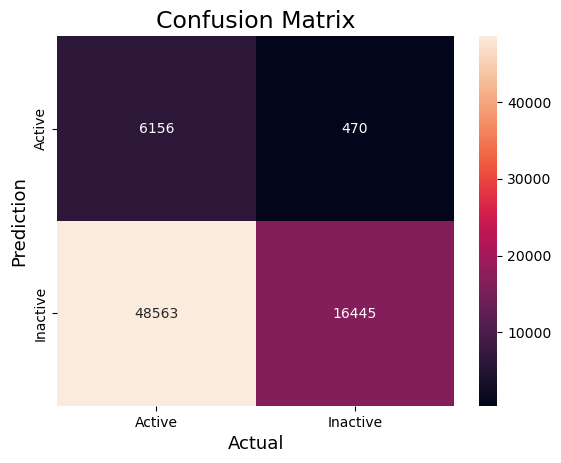

Precision: 0.25296886537041596
Recall: 0.9722140112326337
Epoch 26 | Train Loss 0.7019535303115845


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.4021114771766954
Accuracy: 0.31852193092665493


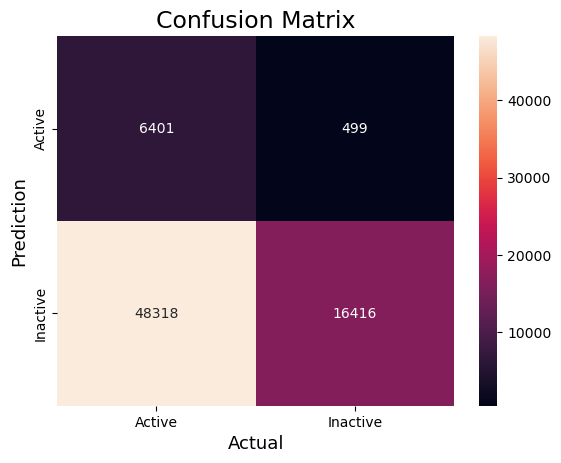

Precision: 0.25359162109556027
Recall: 0.9704995566065622
Epoch 27 | Train Loss 0.7424255013465881


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.40325705736639444
Accuracy: 0.3206857079040679


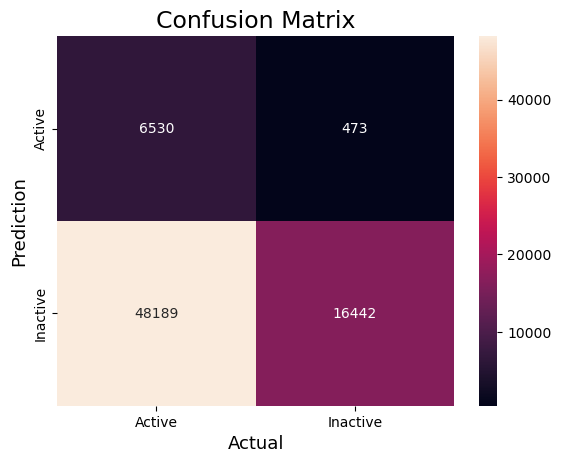

Precision: 0.2543980442821556
Recall: 0.9720366538575229
Epoch 28 | Train Loss 0.7367307543754578


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.05it/s]

F1 Score: 0.4039835249277679
Accuracy: 0.32326828042549627


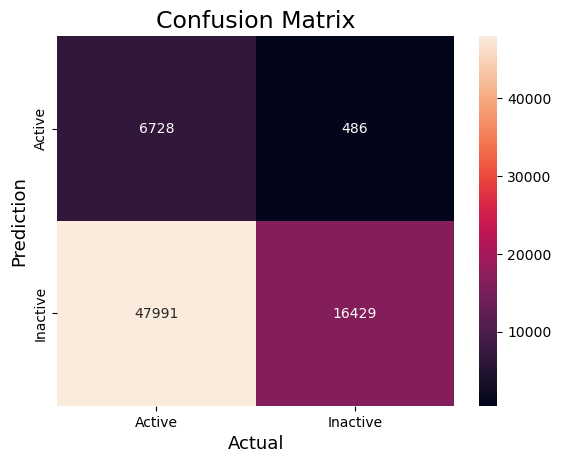

Precision: 0.2550294939459795
Recall: 0.9712681052320425
Epoch 29 | Train Loss 0.6848183870315552


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.4062561917971072
Accuracy: 0.33068096155456905


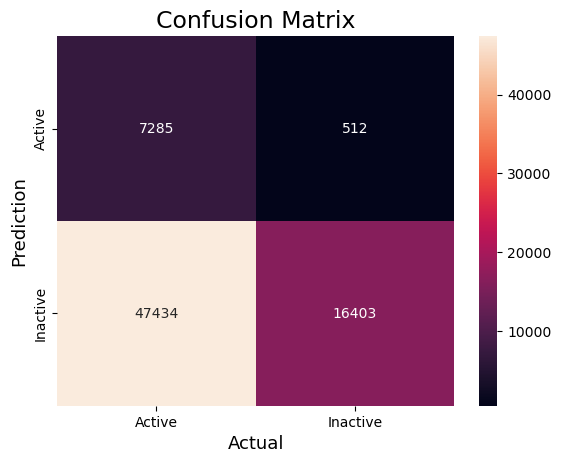

Precision: 0.2569512978366778
Recall: 0.9697310079810819
Epoch 30 | Train Loss 0.6648783683776855


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.06it/s]

F1 Score: 0.40575329228558327
Accuracy: 0.3303878046737583


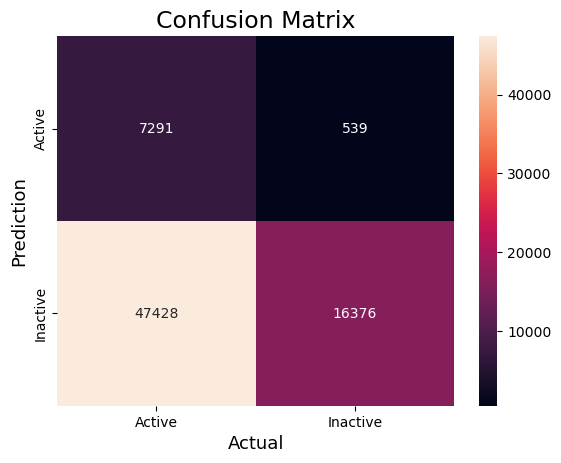

Precision: 0.25666102438718574
Recall: 0.9681347916050842
Epoch 31 | Train Loss 0.7074845433235168


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.40602175072233726
Accuracy: 0.3313370745735265


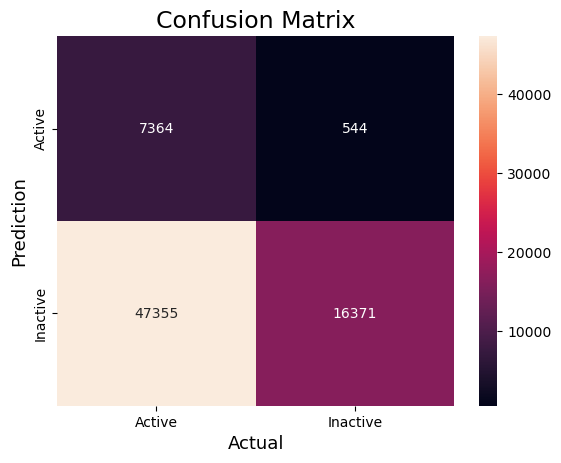

Precision: 0.2568967140570568
Recall: 0.9678391959798995
Epoch 32 | Train Loss 0.6889867186546326


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.09it/s]

F1 Score: 0.4083400961358386
Accuracy: 0.3384565988217885


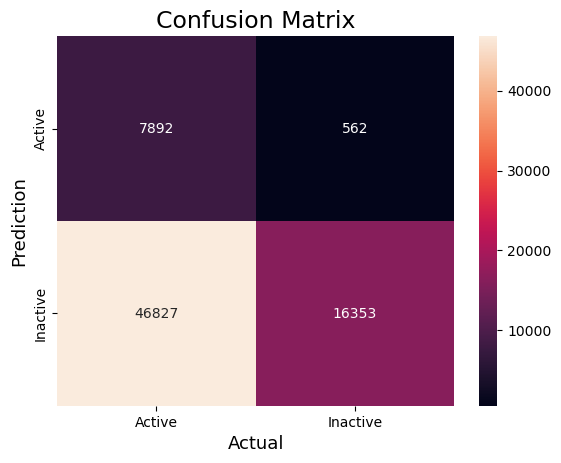

Precision: 0.2588319088319088
Recall: 0.9667750517292344
Epoch 33 | Train Loss 0.6315861344337463


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.41064724715926926
Accuracy: 0.3447385319820197


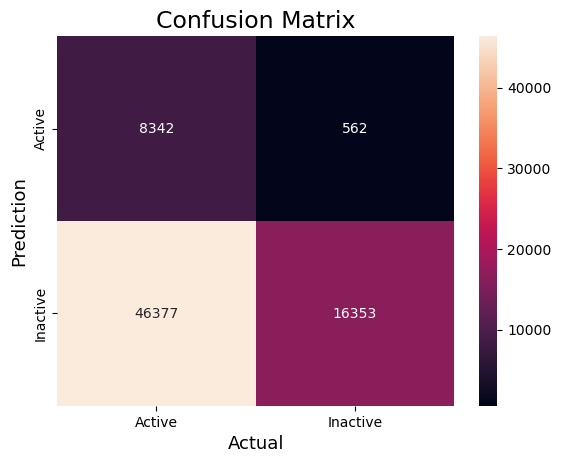

Precision: 0.2606886657101865
Recall: 0.9667750517292344
Epoch 34 | Train Loss 0.7397481203079224


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.06it/s]

F1 Score: 0.41106689502317145
Accuracy: 0.3471535862858419


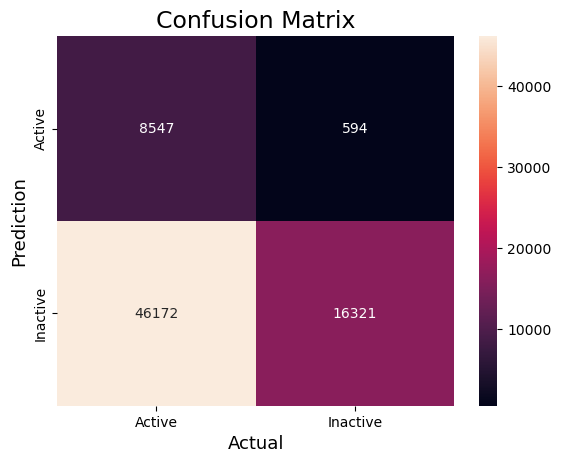

Precision: 0.2611652505080569
Recall: 0.964883239728052
Epoch 35 | Train Loss 0.7522826790809631


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.05it/s]

F1 Score: 0.412057131321288
Accuracy: 0.3494988413323282


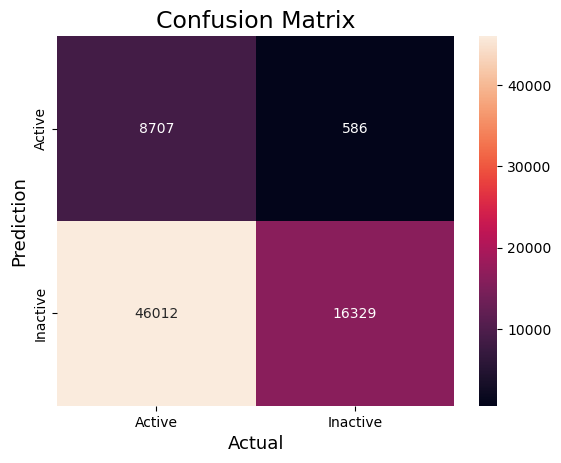

Precision: 0.2619303508124669
Recall: 0.9653561927283476
Epoch 36 | Train Loss 0.6687708497047424


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.4138974345935776
Accuracy: 0.3563950079571153


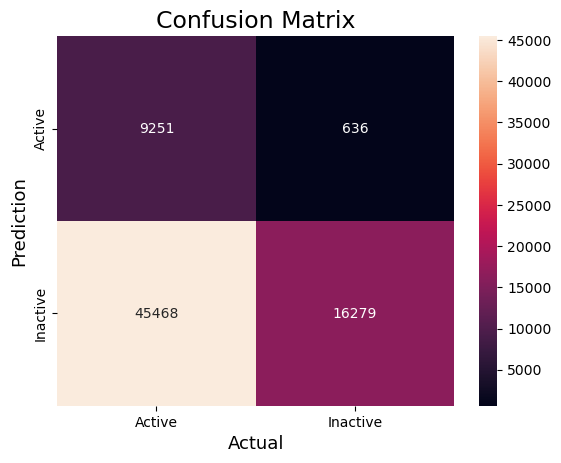

Precision: 0.2636403388018851
Recall: 0.9624002364765002
Epoch 37 | Train Loss 0.6828898191452026


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [07:25<00:00,  1.59s/it]

F1 Score: 0.4130586018037163
Accuracy: 0.3522210123684284


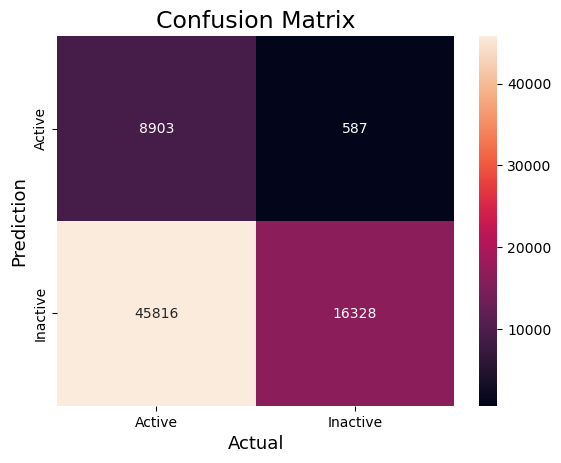

Precision: 0.2627445932028836
Recall: 0.9652970736033106
Epoch 38 | Train Loss 0.6616753935813904


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:52<00:00,  1.62it/s]

F1 Score: 0.4142811603442779
Accuracy: 0.3587542228550688


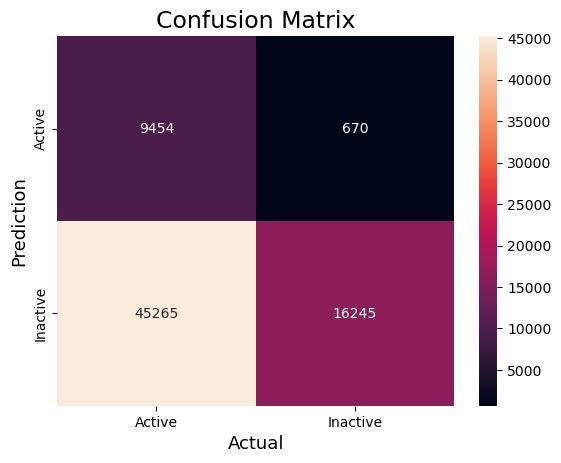

Precision: 0.26410339782149245
Recall: 0.9603901862252439
Epoch 39 | Train Loss 0.6378800272941589


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:29<00:00,  1.87it/s]

F1 Score: 0.41702715847134414
Accuracy: 0.3641287656699333


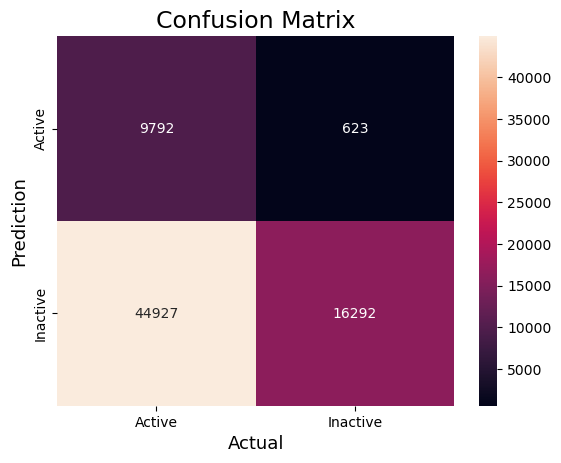

Precision: 0.26612652934546466
Recall: 0.9631687851019805
Epoch 40 | Train Loss 0.6719799041748047


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:49<00:00,  1.65it/s]

F1 Score: 0.41616533190277305
Accuracy: 0.3619091492866516


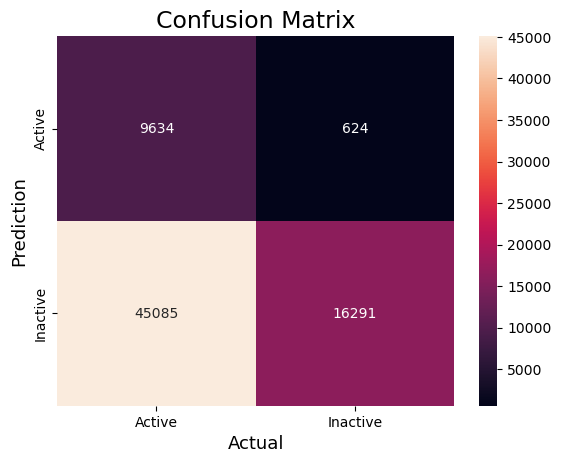

Precision: 0.26542948383733056
Recall: 0.9631096659769436
Epoch 41 | Train Loss 0.647761344909668


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:46<00:00,  1.68it/s]

F1 Score: 0.41851365613818314
Accuracy: 0.36932183041572436


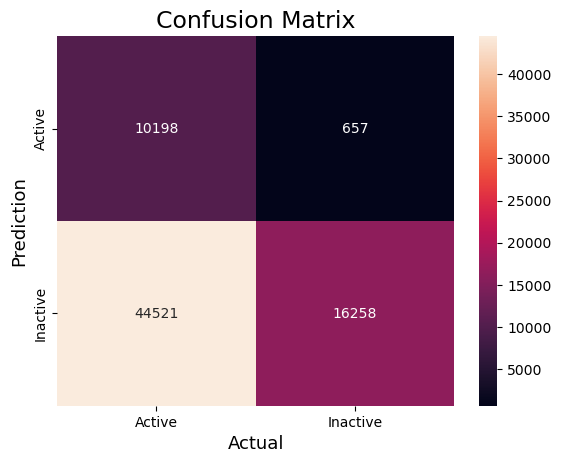

Precision: 0.267493706707909
Recall: 0.9611587348507242
Epoch 42 | Train Loss 0.6643429398536682


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [04:10<00:00,  1.12it/s]

F1 Score: 0.4193469503327027
Accuracy: 0.37020130105815674


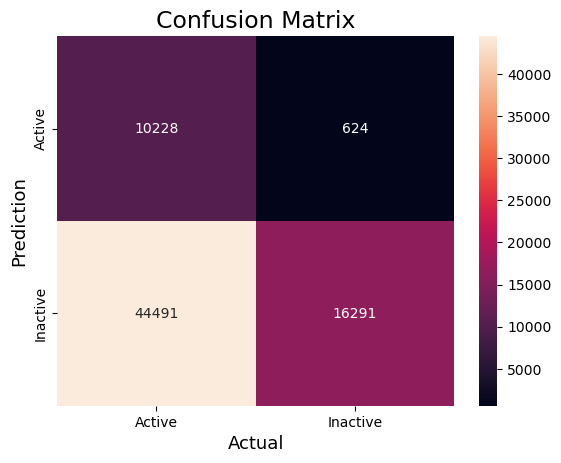

Precision: 0.2680234279885492
Recall: 0.9631096659769436
Epoch 43 | Train Loss 0.6893513798713684


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [08:50<00:00,  1.89s/it]

F1 Score: 0.42014153933732684
Accuracy: 0.3743334170924421


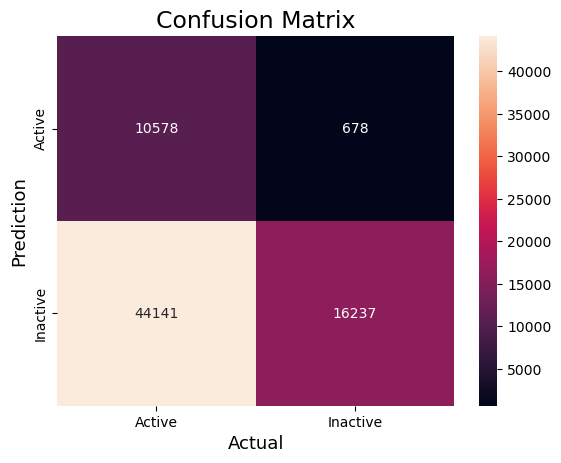

Precision: 0.2689224551989135
Recall: 0.9599172332249483
Epoch 44 | Train Loss 0.6611338257789612


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:48<00:00,  1.66it/s]

F1 Score: 0.42036550143118034
Accuracy: 0.37525476728927604


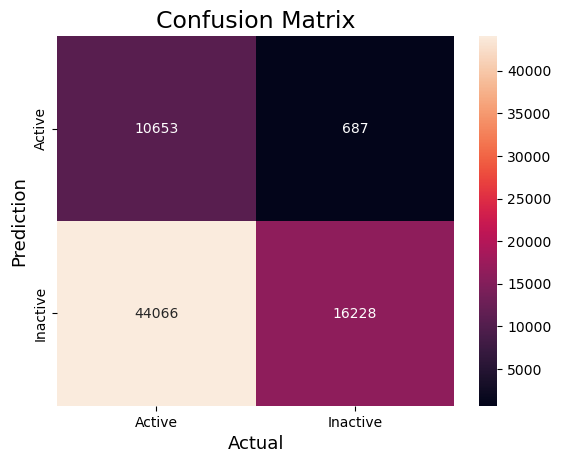

Precision: 0.2691478422396922
Recall: 0.9593851610996157
Epoch 45 | Train Loss 0.6810390949249268


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:49<00:00,  1.66it/s]

F1 Score: 0.4230819195094703
Accuracy: 0.3800429963425189


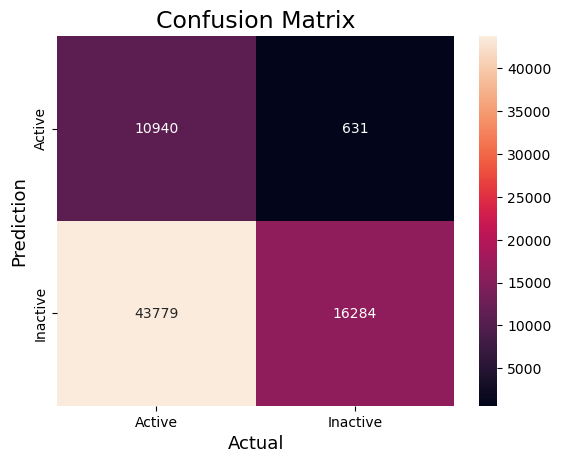

Precision: 0.2711153289046501
Recall: 0.9626958321016849
Epoch 46 | Train Loss 0.6657207608222961


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:24<00:00,  1.94it/s]

F1 Score: 0.42370405155096397
Accuracy: 0.3832537621799704


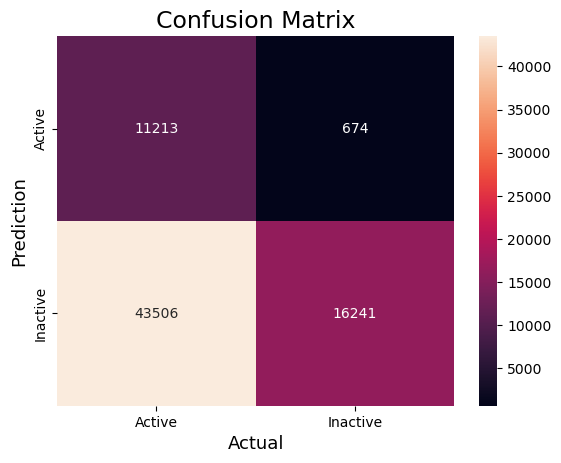

Precision: 0.2718295479270926
Recall: 0.9601537097250961
Epoch 47 | Train Loss 0.6612470746040344


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.4247471121842981
Accuracy: 0.3847474662869587


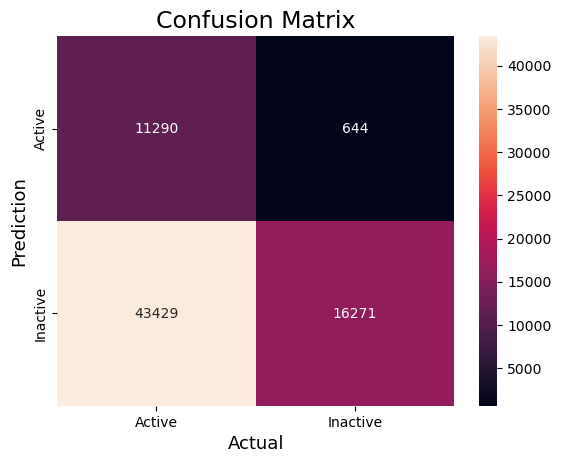

Precision: 0.2725460636515913
Recall: 0.9619272834762046
Epoch 48 | Train Loss 0.6493817567825317


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.4272067252579289
Accuracy: 0.3931512968702013


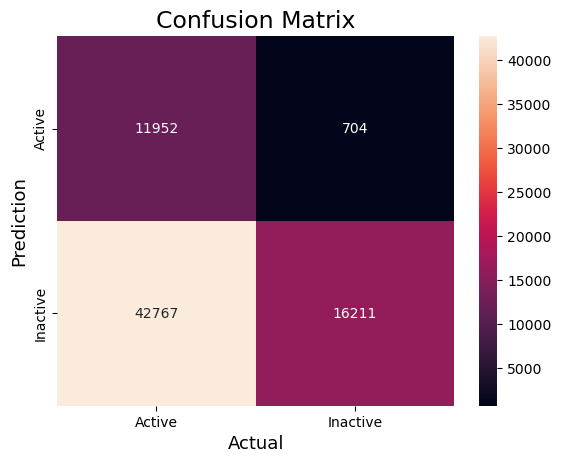

Precision: 0.2748652039743633
Recall: 0.9583801359739876
Epoch 49 | Train Loss 0.6511975526809692


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.42555594961316684
Accuracy: 0.38949381578580006


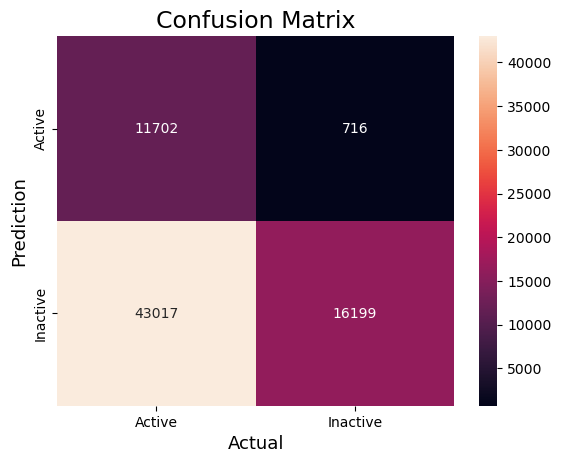

Precision: 0.27355782221021346
Recall: 0.9576707064735442
Epoch 50 | Train Loss 0.6848209500312805


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:17<00:00,  2.04it/s]

F1 Score: 0.4274955641716502
Accuracy: 0.3919228299410894


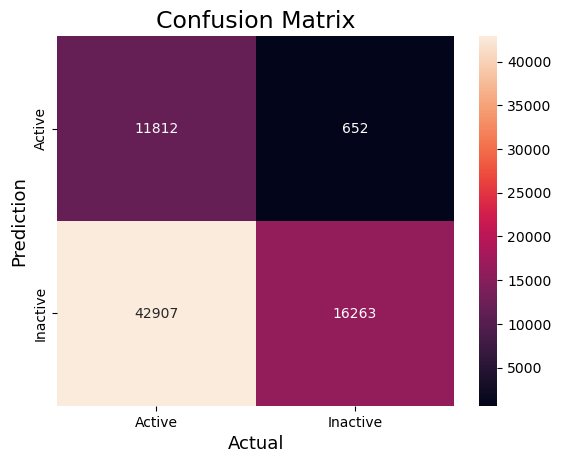

Precision: 0.2748521210072672
Recall: 0.961454330475909
Epoch 51 | Train Loss 0.6952095627784729


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.42729112460248625
Accuracy: 0.39160175335734426


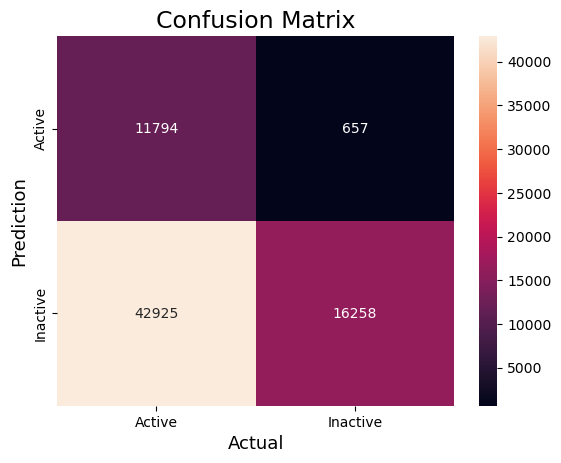

Precision: 0.27470726391024447
Recall: 0.9611587348507242
Epoch 52 | Train Loss 0.6884621381759644


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.4303303701738092
Accuracy: 0.4006198174051428


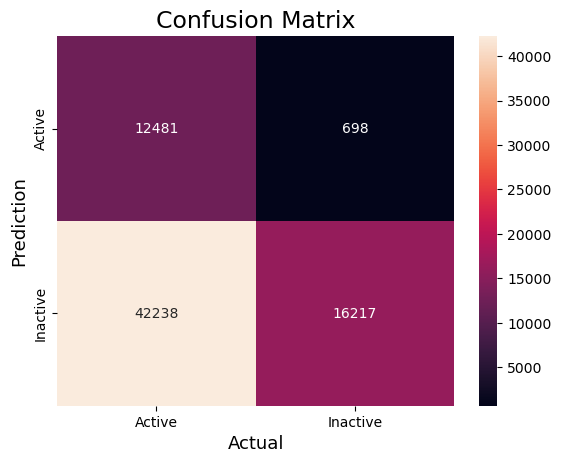

Precision: 0.277427080660337
Recall: 0.9587348507242093
Epoch 53 | Train Loss 0.661837637424469


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.43043639444974047
Accuracy: 0.399475109584834


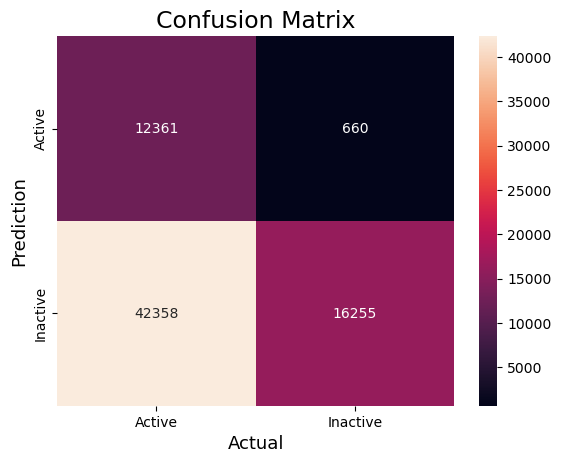

Precision: 0.277327555320492
Recall: 0.9609813774756134
Epoch 54 | Train Loss 0.6849687099456787


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:24<00:00,  1.94it/s]

F1 Score: 0.43049744304974435
Accuracy: 0.4014713683446408


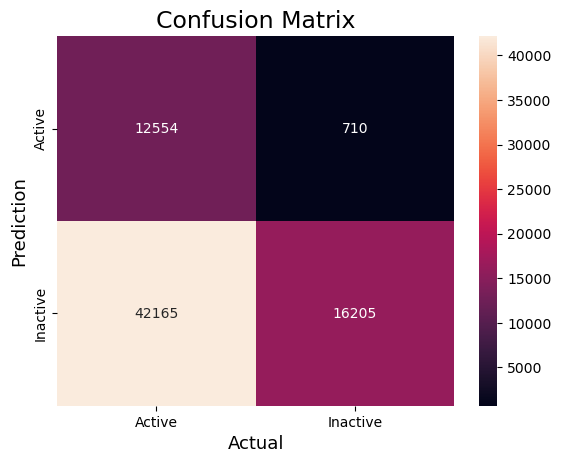

Precision: 0.27762549254754154
Recall: 0.9580254212237659
Epoch 55 | Train Loss 0.6394575834274292


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.43374299584096715
Accuracy: 0.4088980093251808


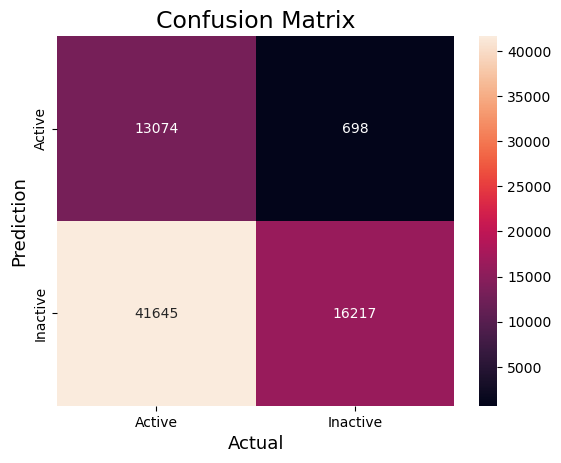

Precision: 0.2802702982959455
Recall: 0.9587348507242093
Epoch 56 | Train Loss 0.6915544867515564


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.43477794895840316
Accuracy: 0.4110199067481922


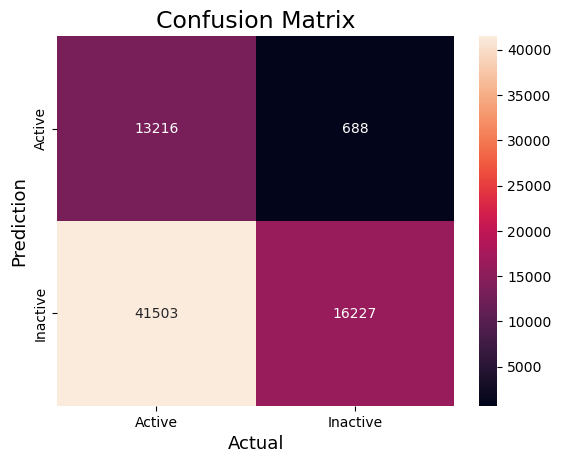

Precision: 0.2810843582192967
Recall: 0.9593260419745788
Epoch 57 | Train Loss 0.6800290942192078


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:17<00:00,  2.04it/s]

F1 Score: 0.43741061550500554
Accuracy: 0.41790211352151213


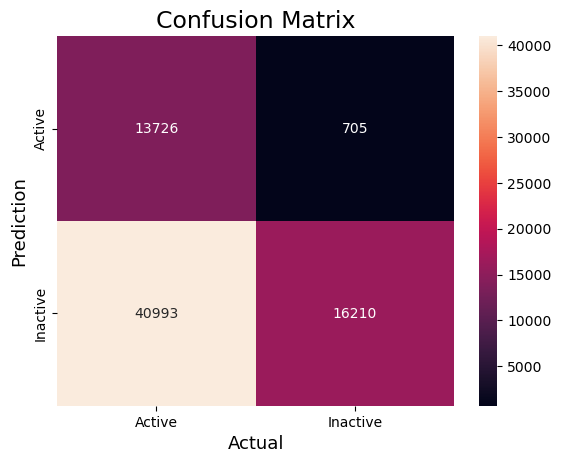

Precision: 0.28337674597486145
Recall: 0.9583210168489507
Epoch 58 | Train Loss 0.6552063226699829


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.43673326323168593
Accuracy: 0.416729485998269


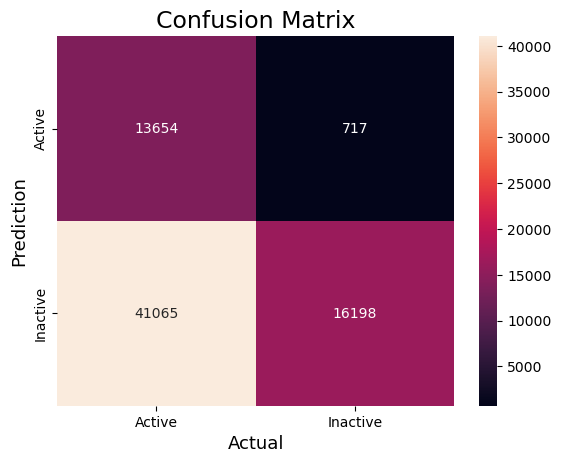

Precision: 0.28287026526727554
Recall: 0.9576115873485073
Epoch 59 | Train Loss 0.6230159401893616


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:18<00:00,  2.02it/s]

F1 Score: 0.4365241735759664
Accuracy: 0.4155847781779602


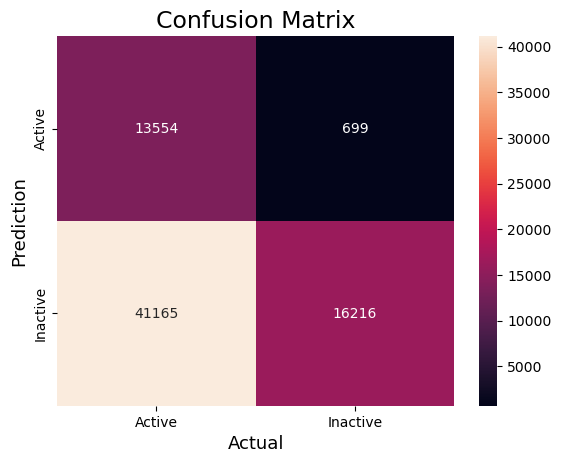

Precision: 0.282602255101863
Recall: 0.9586757315991723
Epoch 60 | Train Loss 0.7072263956069946


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.06it/s]

F1 Score: 0.437861643742801
Accuracy: 0.4209034815869559


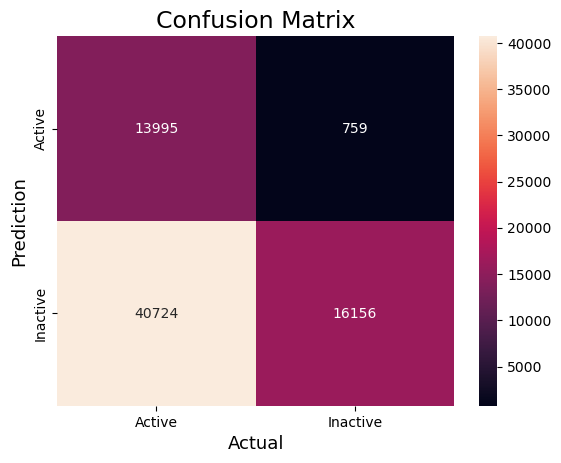

Precision: 0.2840365682137834
Recall: 0.9551285840969553
Epoch 61 | Train Loss 0.6566444039344788


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.43831608603781763
Accuracy: 0.42111287935896363


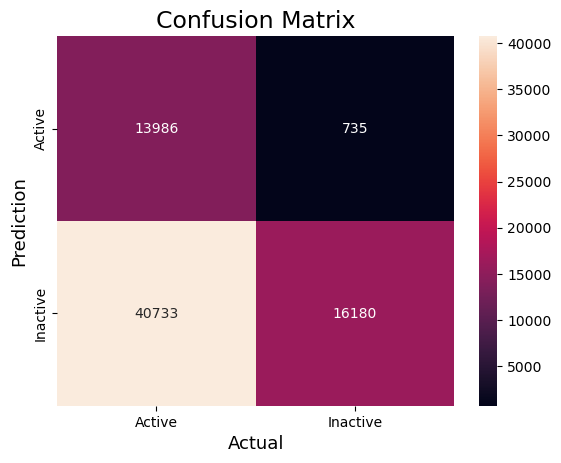

Precision: 0.2842935708889006
Recall: 0.9565474430978421
Epoch 62 | Train Loss 0.6620009541511536


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:53<00:00,  1.62it/s]

F1 Score: 0.4395315065890368
Accuracy: 0.4235000139598515


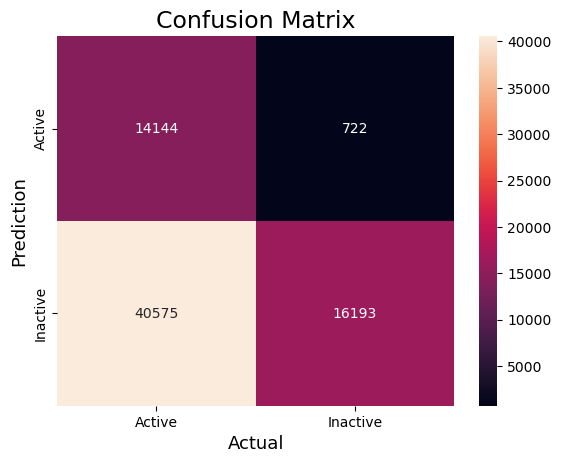

Precision: 0.2852487316798196
Recall: 0.9573159917233225
Epoch 63 | Train Loss 0.6767926216125488


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:54<00:00,  1.60it/s]

F1 Score: 0.4402064656343385
Accuracy: 0.4246866013345618


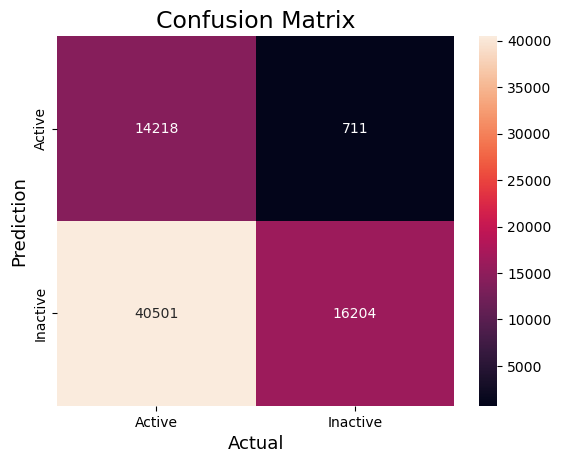

Precision: 0.28575963318931313
Recall: 0.9579663020987289
Epoch 64 | Train Loss 0.6483667492866516


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:50<00:00,  1.65it/s]

F1 Score: 0.44197931288243225
Accuracy: 0.4283859619733646


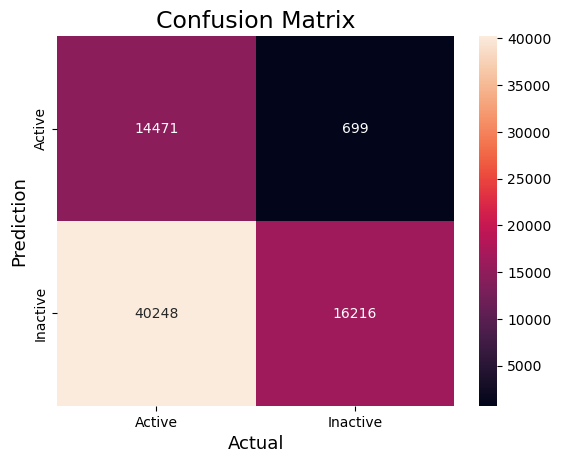

Precision: 0.2871918390478889
Recall: 0.9586757315991723
Epoch 65 | Train Loss 0.6609113216400146


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:57<00:00,  1.58it/s]

F1 Score: 0.4404506583412514
Accuracy: 0.42454700281989


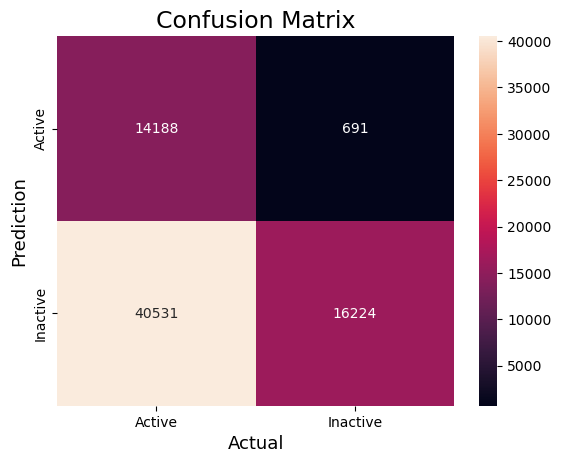

Precision: 0.2858602766276099
Recall: 0.9591486845994679
Epoch 66 | Train Loss 0.6898468136787415


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:15<00:00,  1.43it/s]


F1 Score: 0.4426283367556468
Accuracy: 0.4316106876622833


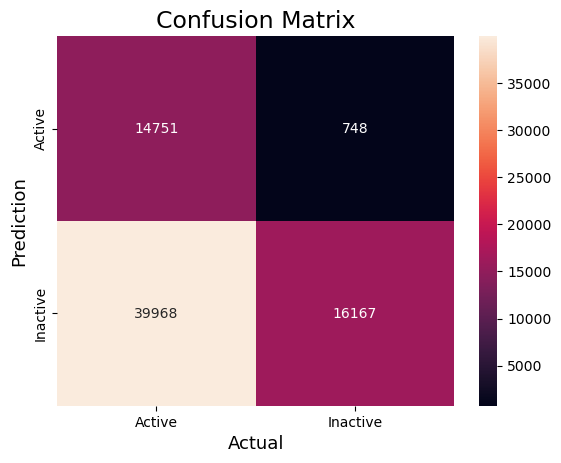

Precision: 0.2880021377037499
Recall: 0.9557788944723619
Epoch 67 | Train Loss 0.6626774668693542


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:28<00:00,  1.34it/s]


F1 Score: 0.4426941358574305
Accuracy: 0.4320434430577659


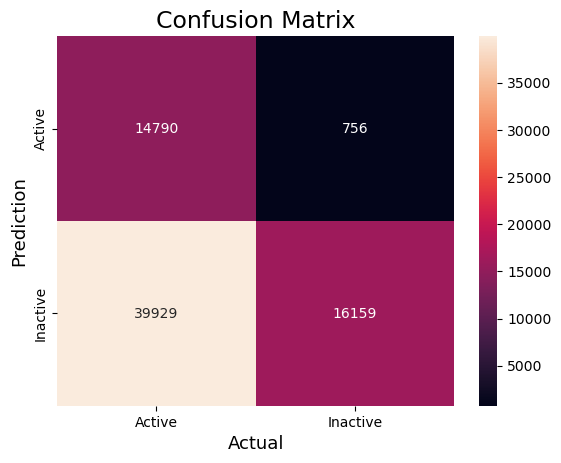

Precision: 0.28810084153473114
Recall: 0.9553059414720663
Epoch 68 | Train Loss 0.6563383340835571


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:30<00:00,  1.33it/s]

F1 Score: 0.4435101750157487
Accuracy: 0.4327274757796577


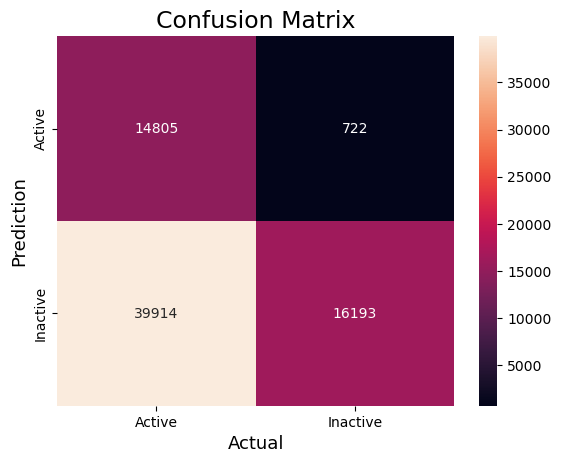

Precision: 0.2886092644411571
Recall: 0.9573159917233225
Epoch 69 | Train Loss 0.7000689506530762


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:15<00:00,  1.43it/s]


F1 Score: 0.4454059416854985
Accuracy: 0.4381438981489237


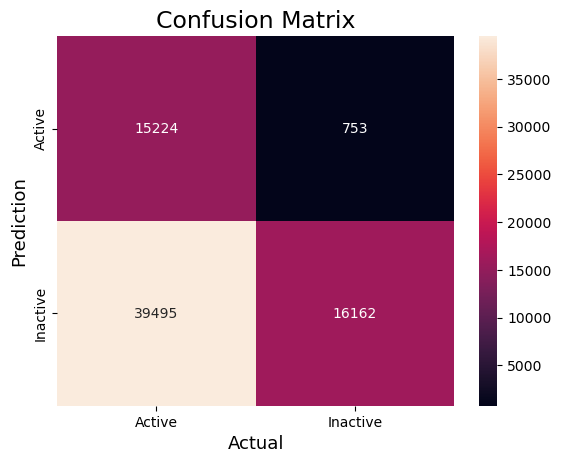

Precision: 0.29038575561025565
Recall: 0.9554832988471771
Epoch 70 | Train Loss 0.6673067808151245


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:11<00:00,  1.46it/s]


F1 Score: 0.44475944071342066
Accuracy: 0.43677583270514003


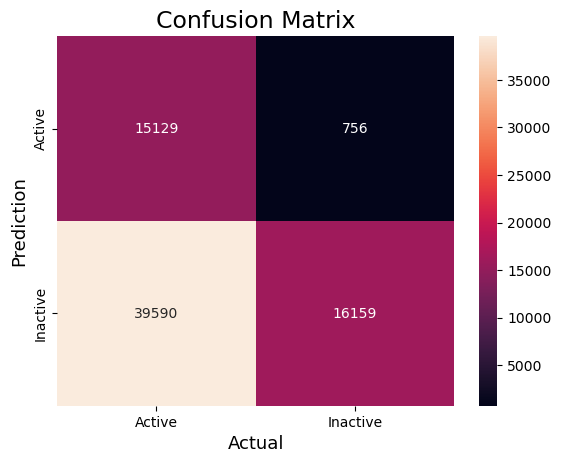

Precision: 0.28985273278444457
Recall: 0.9553059414720663
Epoch 71 | Train Loss 0.67984539270401


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:12<00:00,  1.46it/s]

F1 Score: 0.4473331953356792
Accuracy: 0.4409219085908926


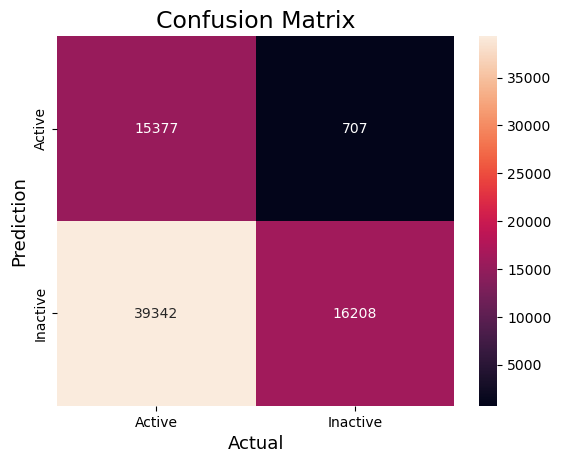

Precision: 0.2917731773177318
Recall: 0.9582027785988767
Epoch 72 | Train Loss 0.6469503045082092


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:07<00:00,  1.49it/s]

F1 Score: 0.4458056878561793
Accuracy: 0.43797637993131755


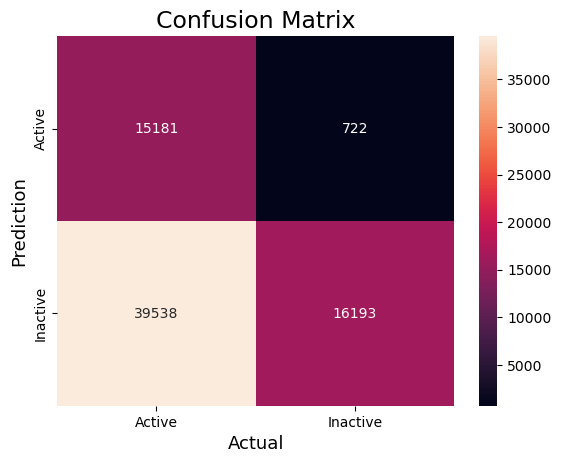

Precision: 0.2905564228167447
Recall: 0.9573159917233225
Epoch 73 | Train Loss 0.6888095736503601


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:05<00:00,  1.51it/s]

F1 Score: 0.4456144219637245
Accuracy: 0.438478934584136


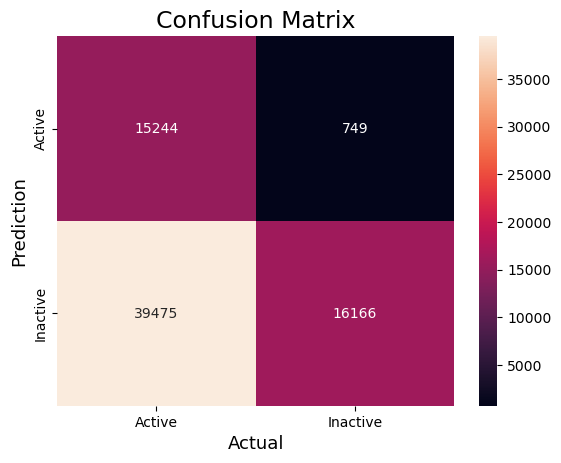

Precision: 0.2905411477148146
Recall: 0.9557197753473249
Epoch 74 | Train Loss 0.6761378645896912


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:06<00:00,  1.50it/s]


F1 Score: 0.44597327902912887
Accuracy: 0.43790658067398164


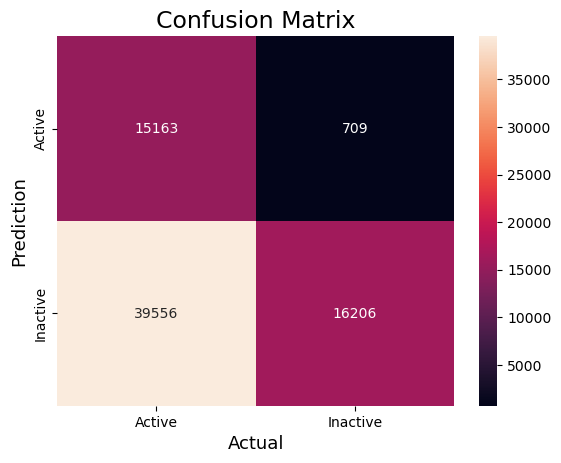

Precision: 0.2906280262544385
Recall: 0.9580845403488029
Epoch 75 | Train Loss 0.6566131711006165


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:28<00:00,  1.89it/s]

F1 Score: 0.4462560970554504
Accuracy: 0.4405589524527459


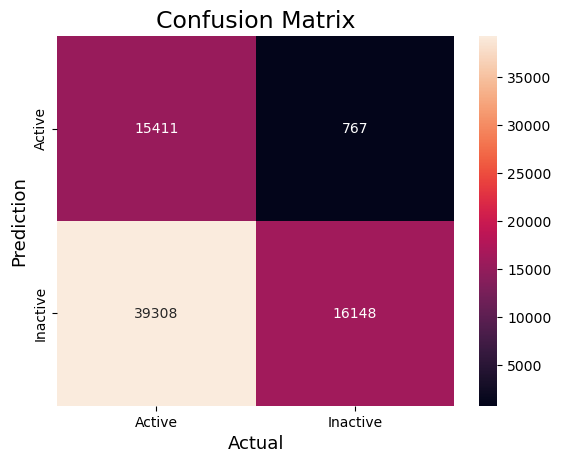

Precision: 0.2911858049624928
Recall: 0.9546556310966597
Epoch 76 | Train Loss 0.6885531544685364


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:23<00:00,  1.95it/s]

F1 Score: 0.44861423845662024
Accuracy: 0.446212692296954


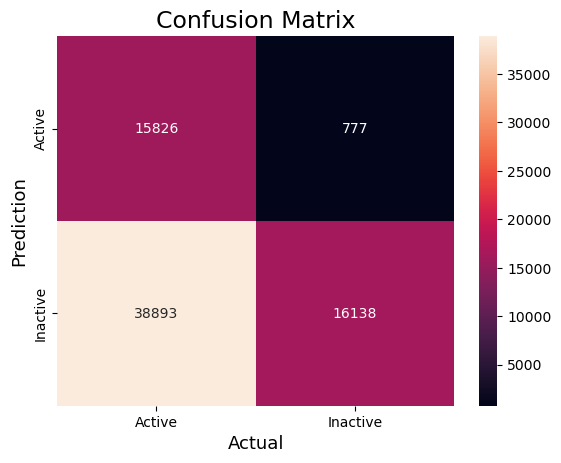

Precision: 0.2932528938234813
Recall: 0.9540644398462903
Epoch 77 | Train Loss 0.6650832891464233


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:38<00:00,  1.77it/s]

F1 Score: 0.44947184562921066
Accuracy: 0.445598458832398


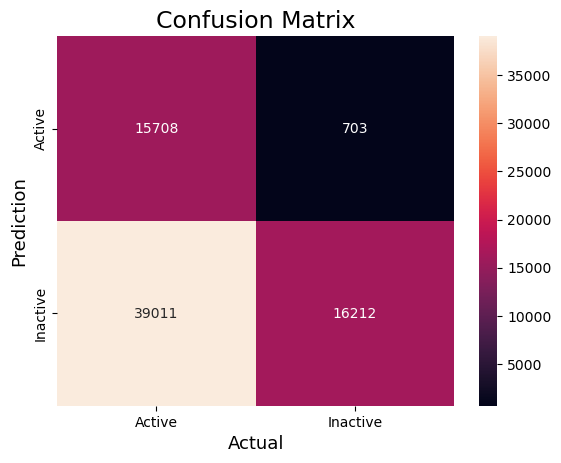

Precision: 0.29357332995309926
Recall: 0.9584392550990245
Epoch 78 | Train Loss 0.6256073713302612


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.71it/s]

F1 Score: 0.4504439310863091
Accuracy: 0.4487254655610464


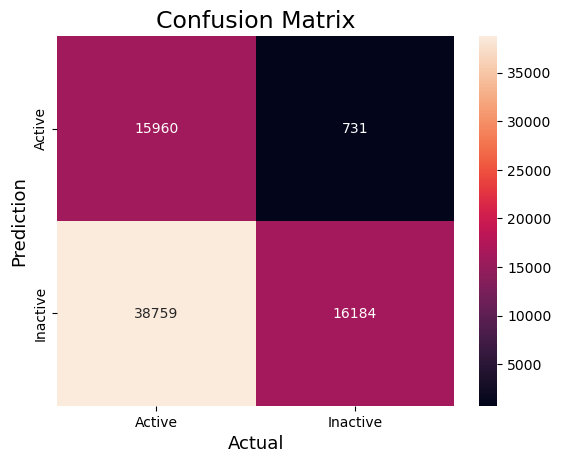

Precision: 0.2945598165371385
Recall: 0.9567839195979899
Epoch 79 | Train Loss 0.644878089427948


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:42<00:00,  1.72it/s]

F1 Score: 0.4521709965482063
Accuracy: 0.45275986263506157


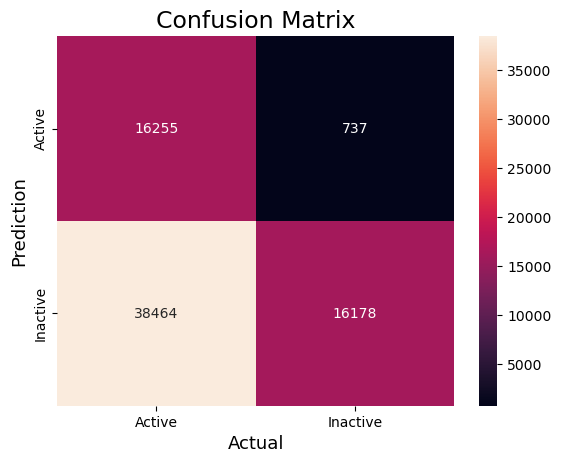

Precision: 0.296072618132572
Recall: 0.9564292048477683
Epoch 80 | Train Loss 0.6722326874732971


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:42<00:00,  1.72it/s]

F1 Score: 0.4511502671633254
Accuracy: 0.4508054834296563


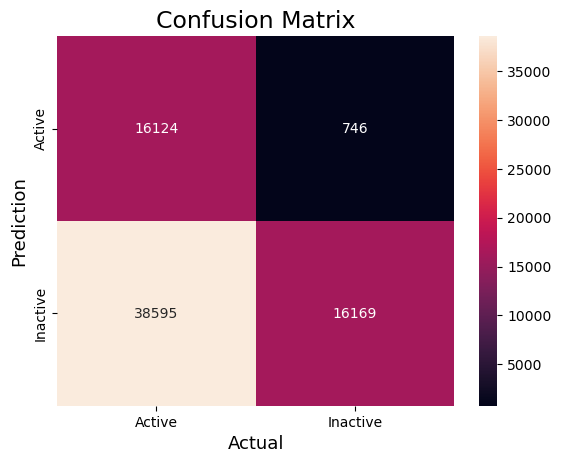

Precision: 0.29524870352786503
Recall: 0.9558971327224357
Epoch 81 | Train Loss 0.6484485864639282


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [6:47:30<00:00, 87.32s/it]     

F1 Score: 0.45145448203697236
Accuracy: 0.45114051986486864


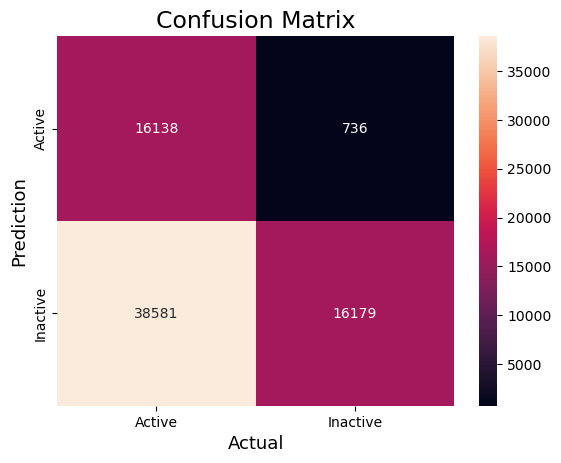

Precision: 0.29545288531775016
Recall: 0.9564883239728053
Epoch 82 | Train Loss 0.6016127467155457


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:24<00:00,  1.93it/s]

F1 Score: 0.45136078157711096
Accuracy: 0.4512382388251389


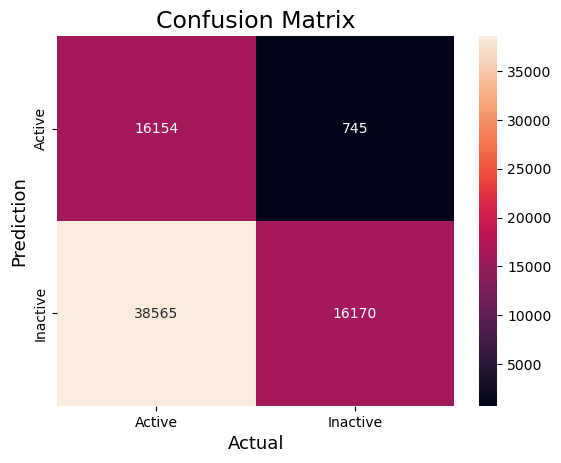

Precision: 0.29542340367223896
Recall: 0.9559562518474727
Epoch 83 | Train Loss 0.6519247889518738


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.45179047965014746
Accuracy: 0.45225730798224306


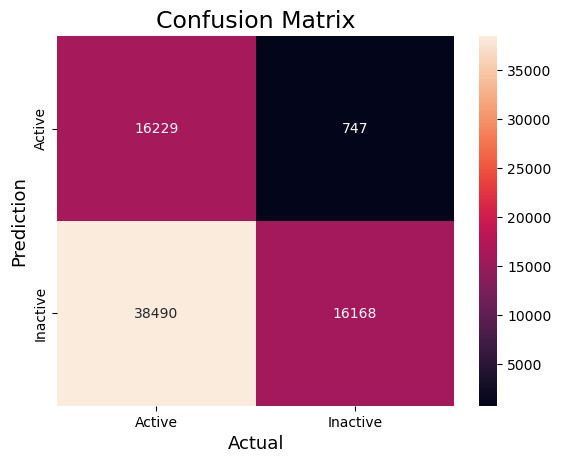

Precision: 0.2958029931574518
Recall: 0.9558380135973987
Epoch 84 | Train Loss 0.6339427828788757


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.13it/s]

F1 Score: 0.45433459381194036
Accuracy: 0.4581204455984588


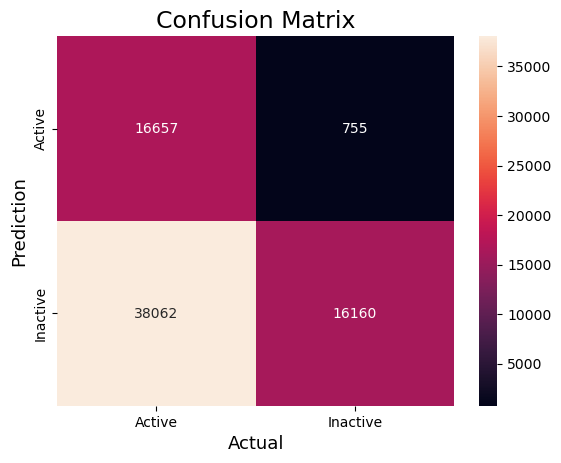

Precision: 0.2980340083360997
Recall: 0.9553650605971031
Epoch 85 | Train Loss 0.6680467128753662


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.12it/s]

F1 Score: 0.45408678102926336
Accuracy: 0.4562358656503895


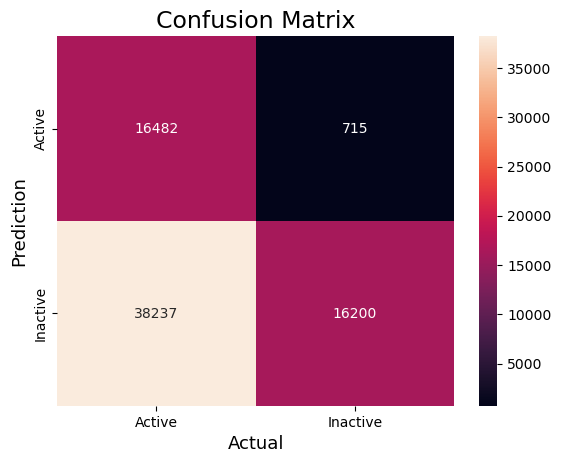

Precision: 0.2975917115197384
Recall: 0.9577298255985811
Epoch 86 | Train Loss 0.6644753217697144


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.13it/s]

F1 Score: 0.45320417704862953
Accuracy: 0.45470028198899964


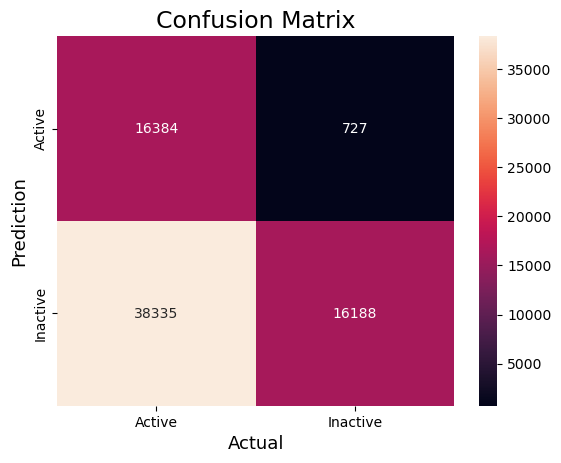

Precision: 0.2969022247491884
Recall: 0.9570203960981377
Epoch 87 | Train Loss 0.6821445822715759


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:21<00:00,  1.98it/s]

F1 Score: 0.4516372373714797
Accuracy: 0.452019990507301


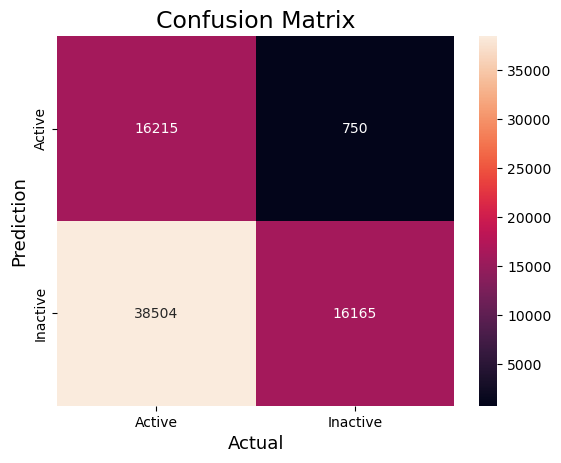

Precision: 0.2956885986573744
Recall: 0.9556606562222879
Epoch 88 | Train Loss 0.6311173439025879


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:21<00:00,  1.97it/s]

F1 Score: 0.4552694526523146
Accuracy: 0.4595583102995784


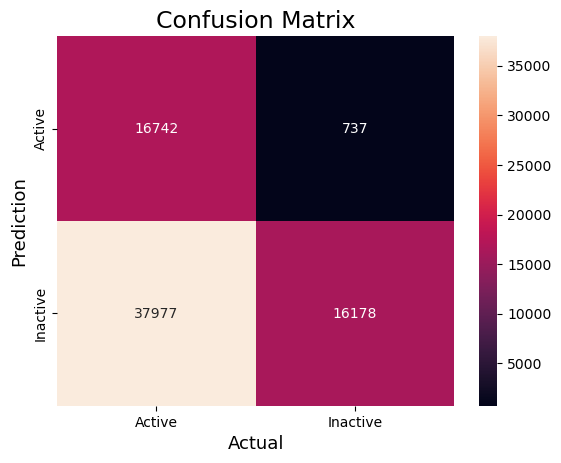

Precision: 0.2987351121780076
Recall: 0.9564292048477683
Epoch 89 | Train Loss 0.6674992442131042


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:18<00:00,  2.02it/s]

F1 Score: 0.4544982237387141
Accuracy: 0.45767373035150904


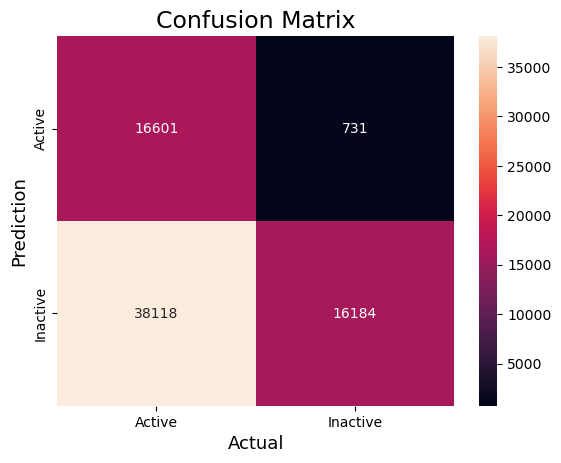

Precision: 0.29803690471805827
Recall: 0.9567839195979899
Epoch 90 | Train Loss 0.6289198398590088


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.12it/s]

F1 Score: 0.45530765551585406
Accuracy: 0.45947455119077535


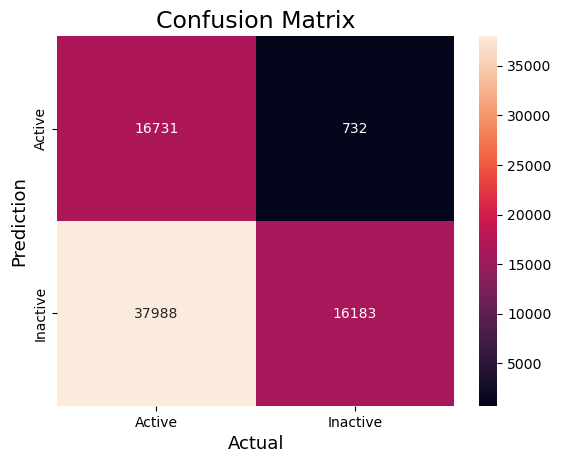

Precision: 0.29873917778885384
Recall: 0.956724800472953
Epoch 91 | Train Loss 0.6719971895217896


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.09it/s]

F1 Score: 0.45714285714285713
Accuracy: 0.4647513750453695


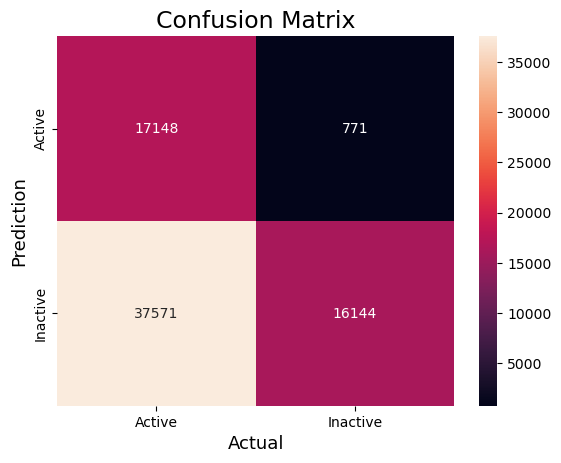

Precision: 0.3005491948245369
Recall: 0.9544191545965119
Epoch 92 | Train Loss 0.638451874256134


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4557537107060217
Accuracy: 0.46151268950498364


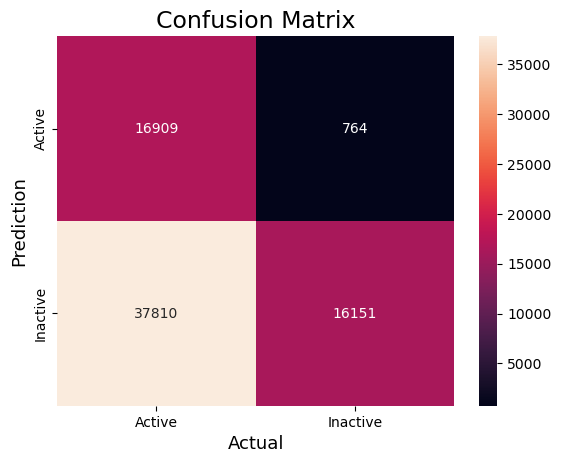

Precision: 0.2993087600303923
Recall: 0.9548329884717707
Epoch 93 | Train Loss 0.6852436661720276


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.13it/s]

F1 Score: 0.4570112083221439
Accuracy: 0.463704386185331


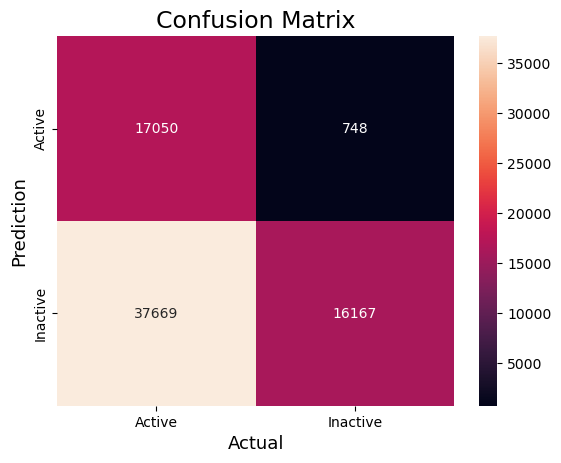

Precision: 0.3003009138866186
Recall: 0.9557788944723619
Epoch 94 | Train Loss 0.6348295211791992


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.45769089314510425
Accuracy: 0.46480721445123824


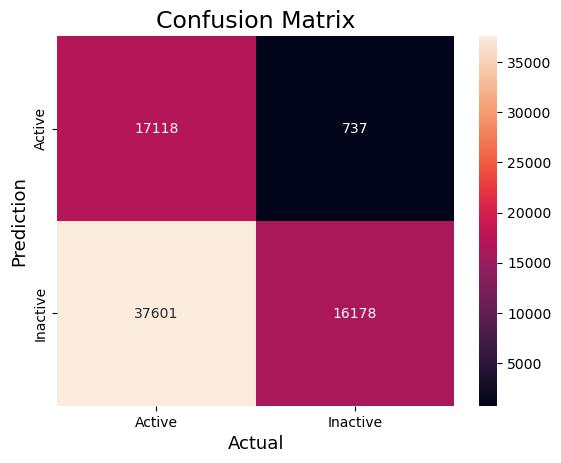

Precision: 0.3008237416091783
Recall: 0.9564292048477683
Epoch 95 | Train Loss 0.6265900135040283


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.09it/s]

F1 Score: 0.45667288451755134
Accuracy: 0.4632716307898484


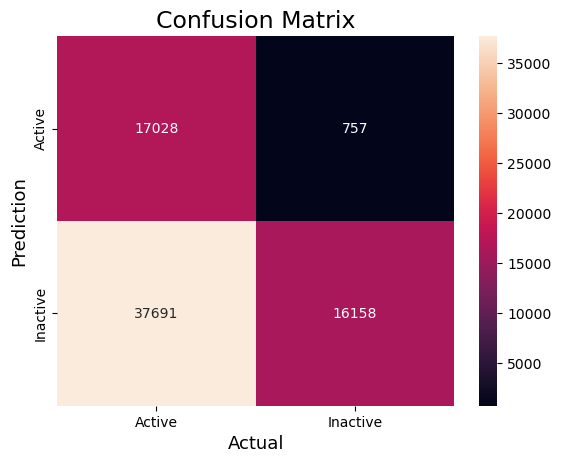

Precision: 0.3000612824750692
Recall: 0.9552468223470293
Epoch 96 | Train Loss 0.662817120552063


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:17<00:00,  2.03it/s]

F1 Score: 0.4572600028276545
Accuracy: 0.46410922187787923


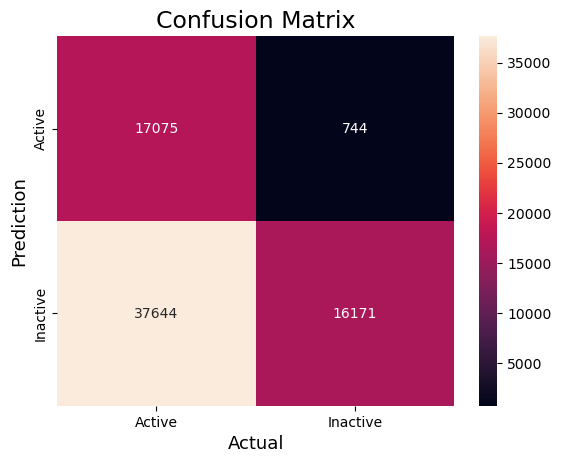

Precision: 0.3004924277617765
Recall: 0.9560153709725097
Epoch 97 | Train Loss 0.6933179497718811


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:19<00:00,  2.01it/s]

F1 Score: 0.45744335885180953
Accuracy: 0.46278303598849707


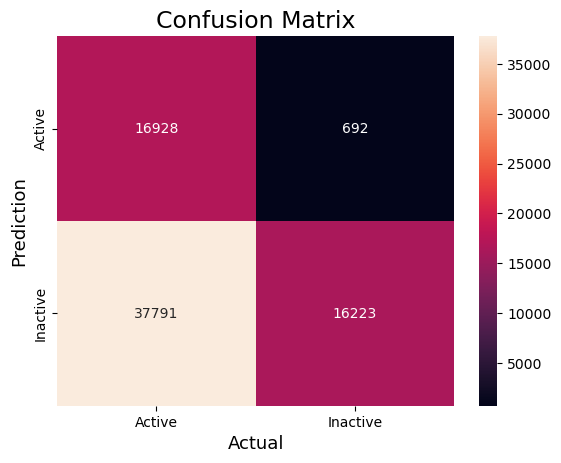

Precision: 0.30034805791091196
Recall: 0.959089565474431
Epoch 98 | Train Loss 0.6470794081687927


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.05it/s]

F1 Score: 0.45742857547557336
Accuracy: 0.4652678895496552


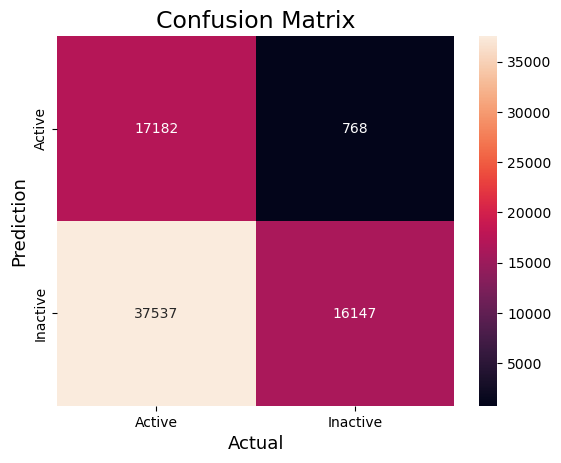

Precision: 0.3007786305044334
Recall: 0.9545965119716229
Epoch 99 | Train Loss 0.6622256636619568


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.12it/s]

F1 Score: 0.45666242758230896
Accuracy: 0.46321579138397967


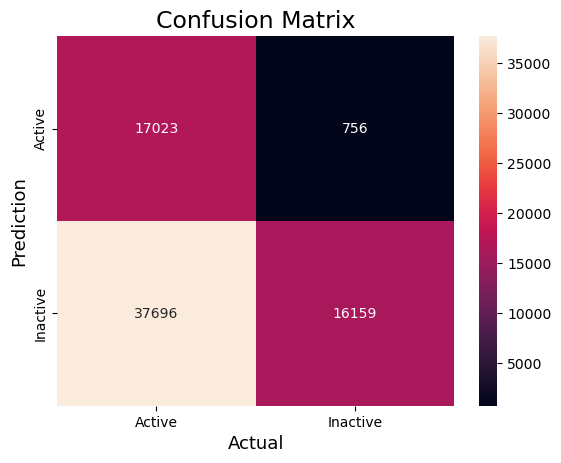

Precision: 0.30004642094513045
Recall: 0.9553059414720663
Epoch 100 | Train Loss 0.6365563869476318


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.06it/s]

F1 Score: 0.45768184908225695
Accuracy: 0.4654493676187285


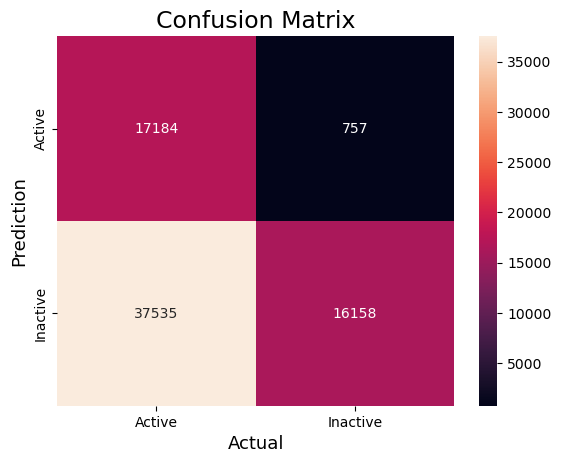

Precision: 0.3009330825247239
Recall: 0.9552468223470293
Epoch 101 | Train Loss 0.6525307893753052


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:17<00:00,  2.04it/s]

F1 Score: 0.45654686398872446
Accuracy: 0.46173604712845856


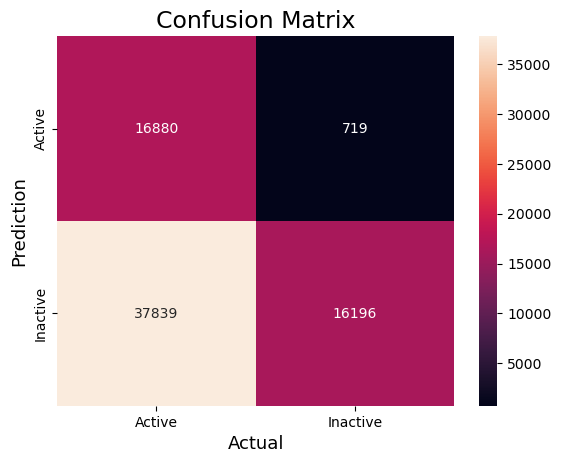

Precision: 0.2997316554085315
Recall: 0.9574933490984333
Epoch 102 | Train Loss 0.645052433013916


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:18<00:00,  2.02it/s]

F1 Score: 0.4578923538400588
Accuracy: 0.46514225088645056


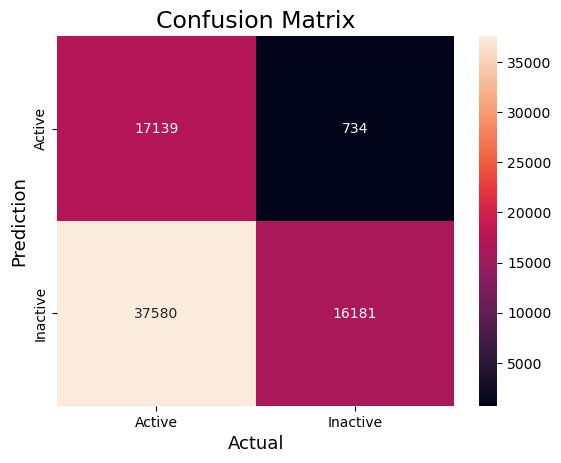

Precision: 0.3009802645040085
Recall: 0.9566065622228791
Epoch 103 | Train Loss 0.674029529094696


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.45905971612463237
Accuracy: 0.46850657509004107


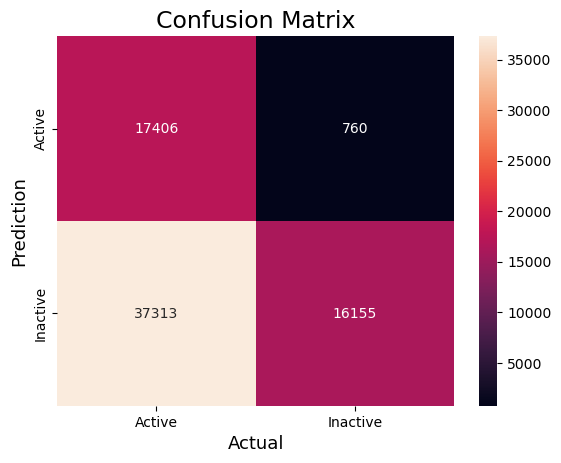

Precision: 0.3021433380713698
Recall: 0.9550694649719185
Epoch 104 | Train Loss 0.6653674840927124


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.05it/s]

F1 Score: 0.45791675530029075
Accuracy: 0.4663846776670296


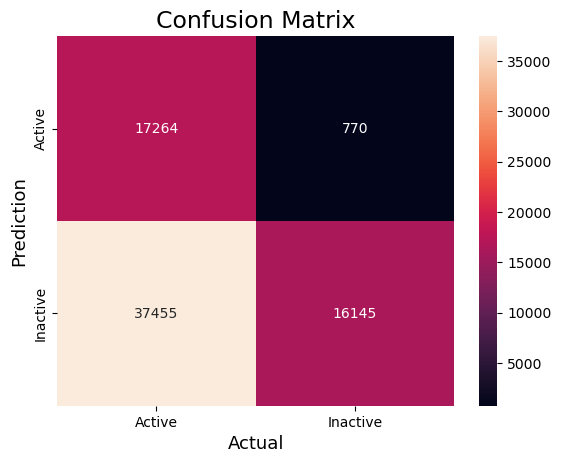

Precision: 0.30121268656716416
Recall: 0.9544782737215489
Epoch 105 | Train Loss 0.6861465573310852


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.45724712505481135
Accuracy: 0.4643465393528213


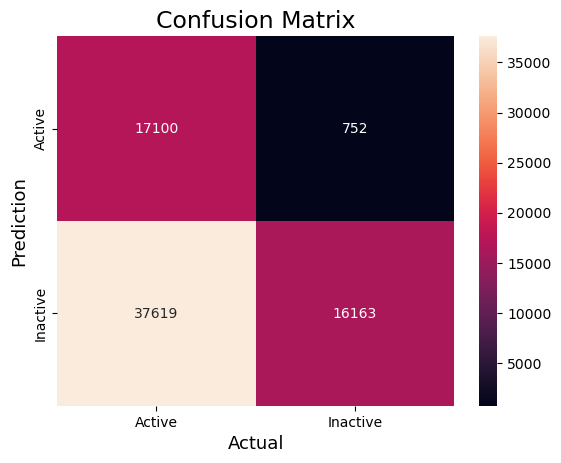

Precision: 0.30052805771447694
Recall: 0.9555424179722141
Epoch 106 | Train Loss 0.6619436740875244


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:17<00:00,  2.03it/s]

F1 Score: 0.45792591332936544
Accuracy: 0.46600776167741575


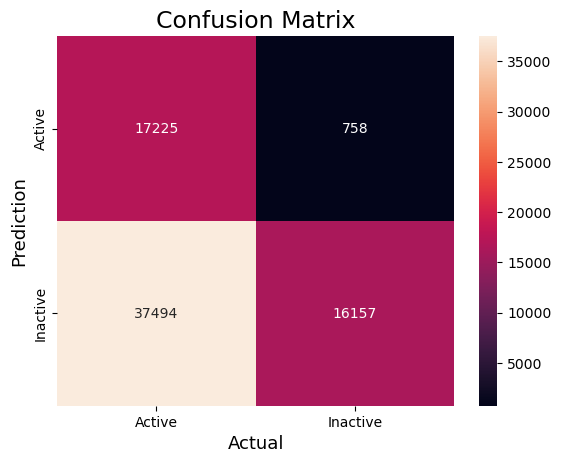

Precision: 0.3011500251626251
Recall: 0.9551877032219923
Epoch 107 | Train Loss 0.6105092167854309


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.05it/s]

F1 Score: 0.4595707228436772
Accuracy: 0.46854845464444256


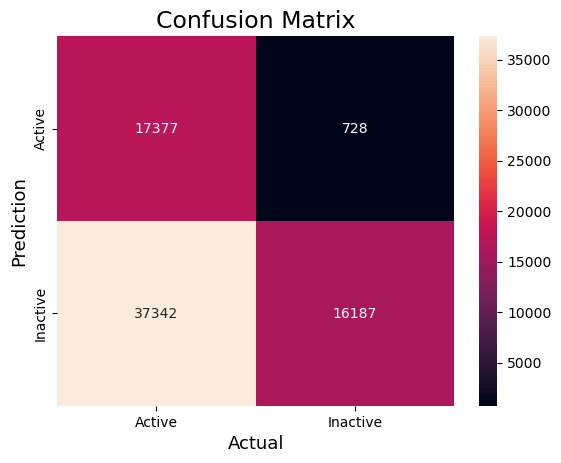

Precision: 0.3023968316239795
Recall: 0.9569612769731008
Epoch 108 | Train Loss 0.6351162195205688


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.05it/s]

F1 Score: 0.46003954087075255
Accuracy: 0.4700421587514309


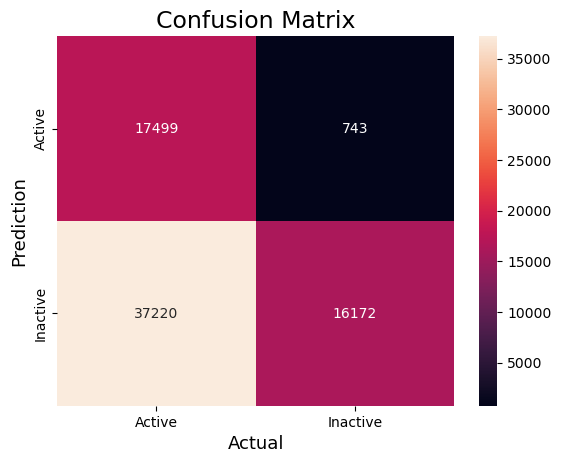

Precision: 0.302891818999101
Recall: 0.9560744900975465
Epoch 109 | Train Loss 0.698350191116333


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:55<00:00,  1.59it/s]

F1 Score: 0.46051637369373993
Accuracy: 0.4717452606304269


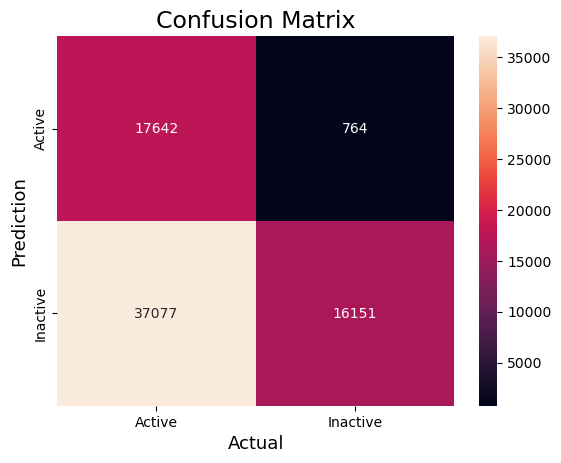

Precision: 0.3034305252874427
Recall: 0.9548329884717707
Epoch 110 | Train Loss 0.6870014071464539


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:47<00:00,  1.68it/s]

F1 Score: 0.46108810509781534
Accuracy: 0.47315520562861213


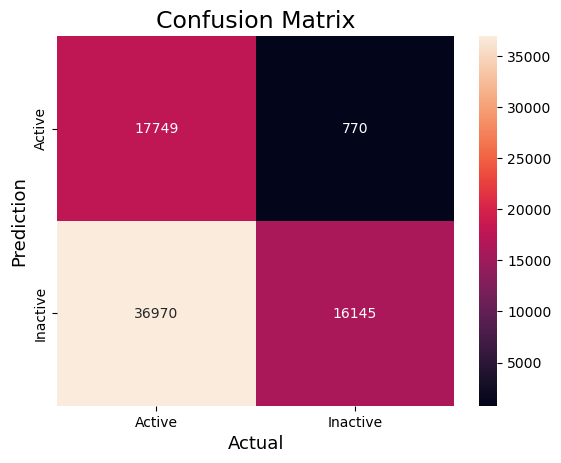

Precision: 0.3039630989362704
Recall: 0.9544782737215489
Epoch 111 | Train Loss 0.6166852116584778


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:46<00:00,  1.69it/s]

F1 Score: 0.4597955706984669
Accuracy: 0.46879973197085184


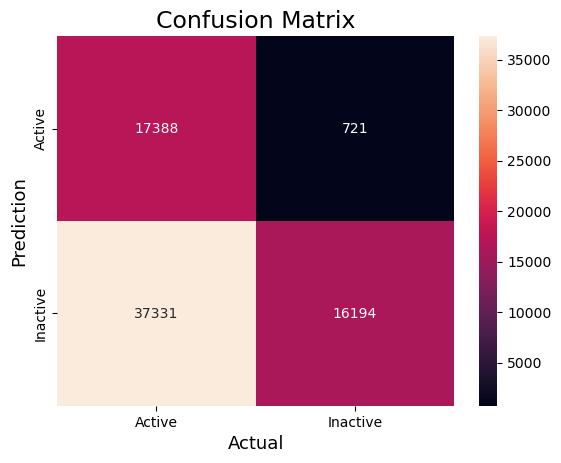

Precision: 0.3025502101821579
Recall: 0.9573751108483595
Epoch 112 | Train Loss 0.6316074728965759


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:45<00:00,  1.70it/s]

F1 Score: 0.4603813288214636
Accuracy: 0.4701817572661027


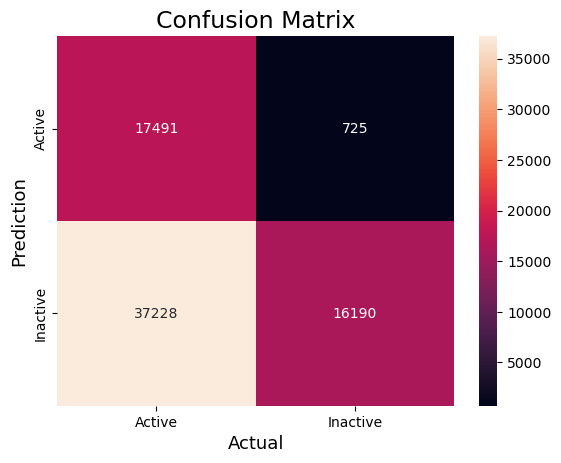

Precision: 0.3030813583436295
Recall: 0.9571386343482117
Epoch 113 | Train Loss 0.6384366154670715


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:45<00:00,  1.69it/s]

F1 Score: 0.45997950586360015
Accuracy: 0.4703073959293073


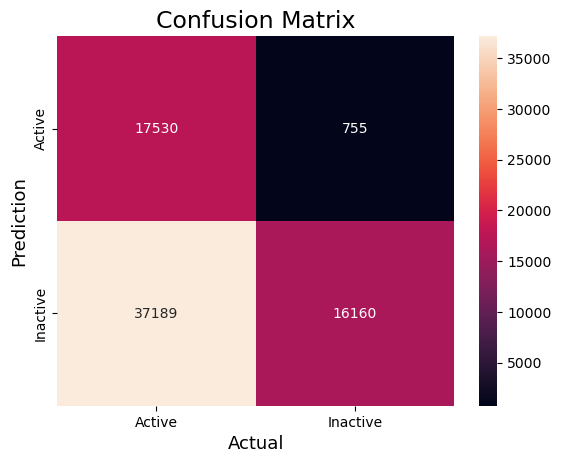

Precision: 0.3029110198879079
Recall: 0.9553650605971031
Epoch 114 | Train Loss 0.654649019241333


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.71it/s]

F1 Score: 0.45945523966332164
Accuracy: 0.46836697657536924


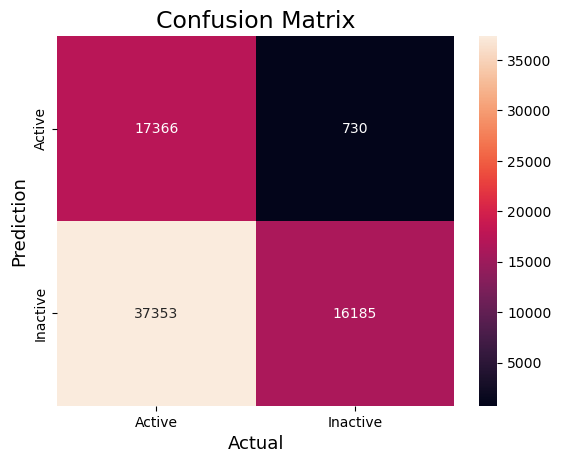

Precision: 0.30230864059172924
Recall: 0.9568430387230269
Epoch 115 | Train Loss 0.6858184337615967


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:42<00:00,  1.73it/s]

F1 Score: 0.4600869379320174
Accuracy: 0.47115894686880533


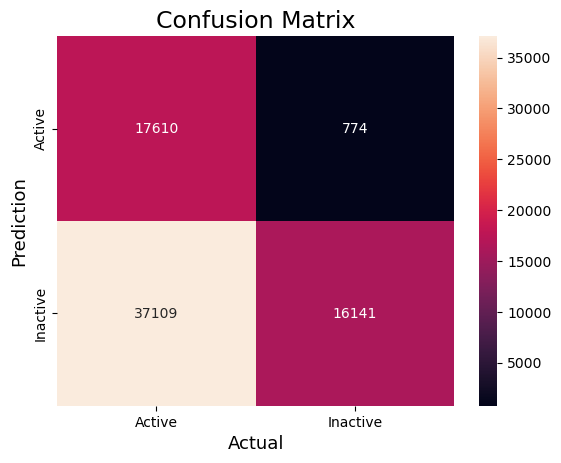

Precision: 0.3031173708920188
Recall: 0.9542417972214011
Epoch 116 | Train Loss 0.6701139807701111


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:37<00:00,  1.78it/s]

F1 Score: 0.4599797942427821
Accuracy: 0.47020967696903704


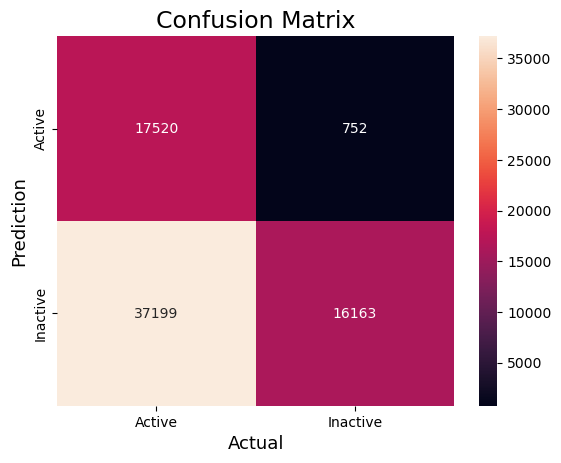

Precision: 0.3028934447734343
Recall: 0.9555424179722141
Epoch 117 | Train Loss 0.6530157327651978


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.11it/s]

F1 Score: 0.4595559474874479
Accuracy: 0.46956752380154676


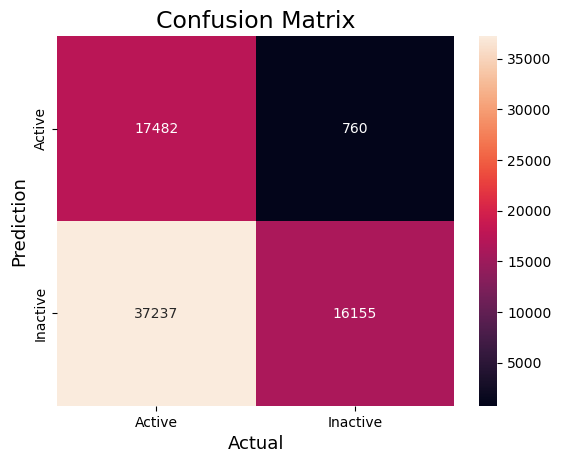

Precision: 0.3025734192388373
Recall: 0.9550694649719185
Epoch 118 | Train Loss 0.6843303442001343


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:18<00:00,  2.02it/s]

F1 Score: 0.4614223247731772
Accuracy: 0.47213613647150793


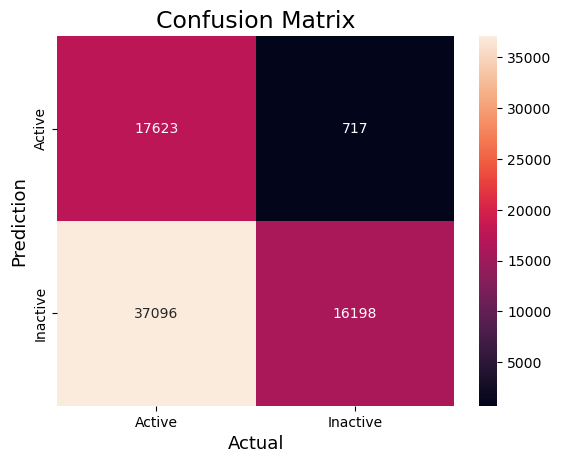

Precision: 0.3039366532817953
Recall: 0.9576115873485073
Epoch 119 | Train Loss 0.5986315608024597


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:16<00:00,  2.04it/s]

F1 Score: 0.459084446971851
Accuracy: 0.46885557137672057


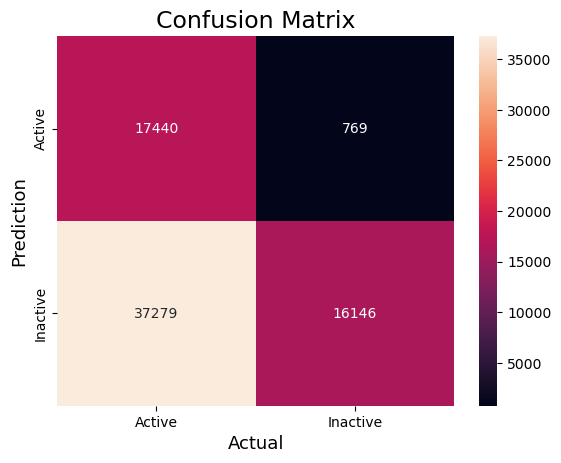

Precision: 0.30221806270472623
Recall: 0.9545373928465859
Epoch 120 | Train Loss 0.6168105006217957


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.12it/s]

F1 Score: 0.4601812654487599
Accuracy: 0.4695256442471452


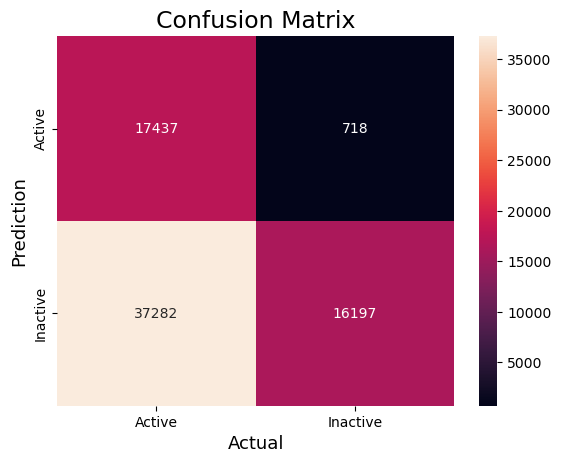

Precision: 0.30286654574692873
Recall: 0.9575524682234703
Epoch 121 | Train Loss 0.6320631504058838


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46085068700545606
Accuracy: 0.47304352681687467


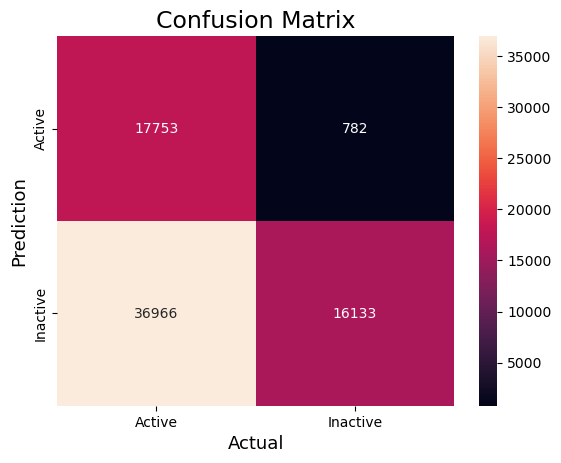

Precision: 0.3038286973389329
Recall: 0.9537688442211055
Epoch 122 | Train Loss 0.6659160256385803


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46066728320409756
Accuracy: 0.470823910433593


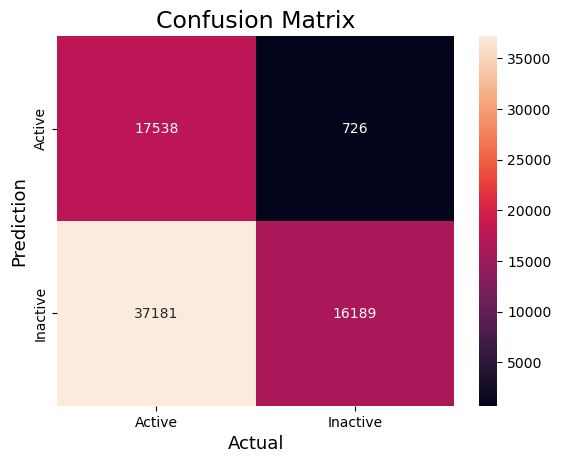

Precision: 0.30333520704515643
Recall: 0.9570795152231747
Epoch 123 | Train Loss 0.6504748463630676


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46183891660727017
Accuracy: 0.47298768741100594


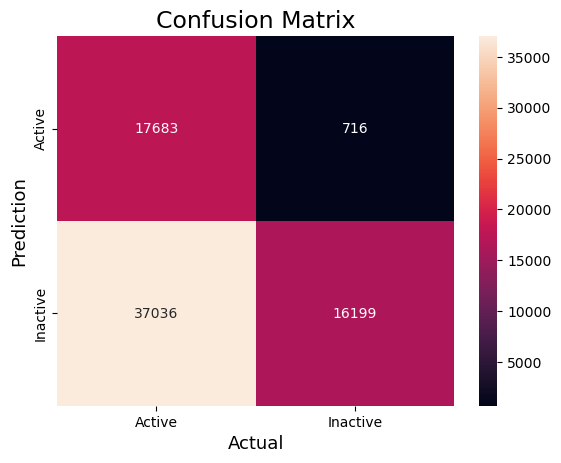

Precision: 0.3042922889076735
Recall: 0.9576707064735442
Epoch 124 | Train Loss 0.6848344206809998


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.12it/s]

F1 Score: 0.4613317322812134
Accuracy: 0.4739648770137086


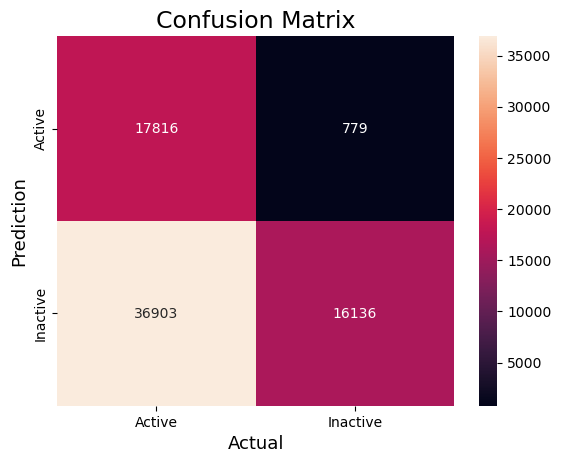

Precision: 0.3042289635928279
Recall: 0.9539462015962163
Epoch 125 | Train Loss 0.6964327096939087


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46180619944938167
Accuracy: 0.4733087639947511


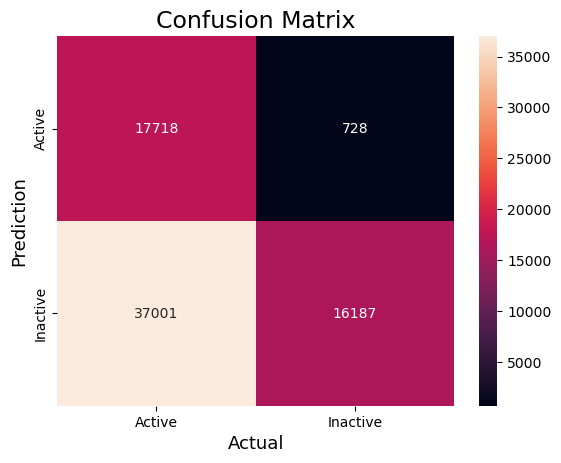

Precision: 0.3043355644130255
Recall: 0.9569612769731008
Epoch 126 | Train Loss 0.6416471600532532


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.4605462172883194
Accuracy: 0.4722338554317782


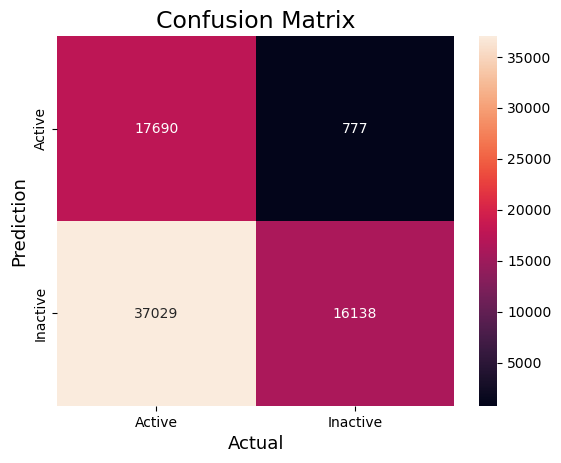

Precision: 0.30353414712133464
Recall: 0.9540644398462903
Epoch 127 | Train Loss 0.6233764290809631


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.46086510222120836
Accuracy: 0.4720942569171064


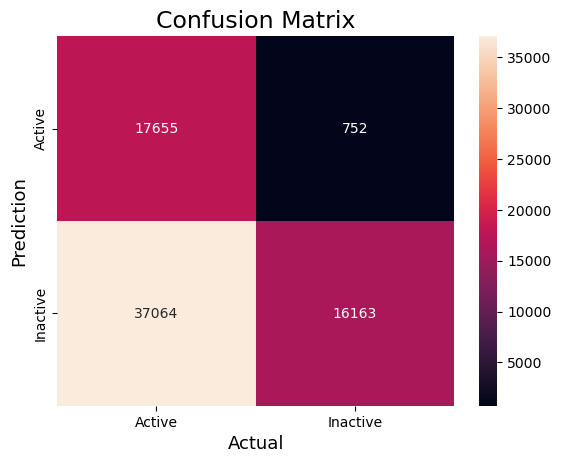

Precision: 0.30366167546545925
Recall: 0.9555424179722141
Epoch 128 | Train Loss 0.6362826228141785


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46080387685290763
Accuracy: 0.4718988189965659


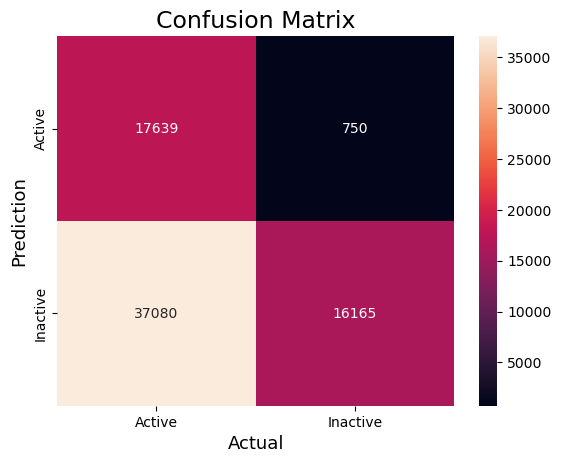

Precision: 0.3035965818386703
Recall: 0.9556606562222879
Epoch 129 | Train Loss 0.6733610033988953


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4613782874094358
Accuracy: 0.47279224949046544


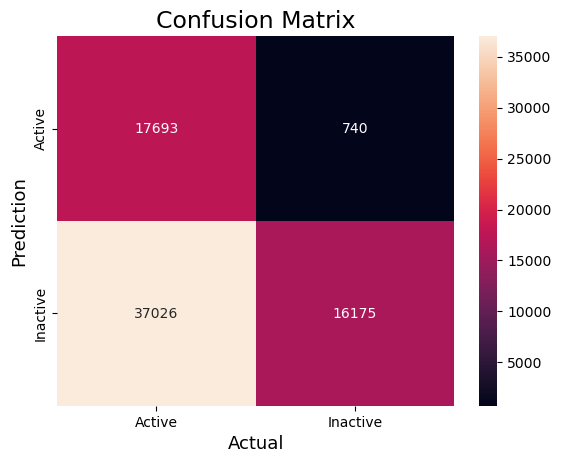

Precision: 0.3040356384278491
Recall: 0.9562518474726575
Epoch 130 | Train Loss 0.6685684323310852


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46199697687020513
Accuracy: 0.47332272384621826


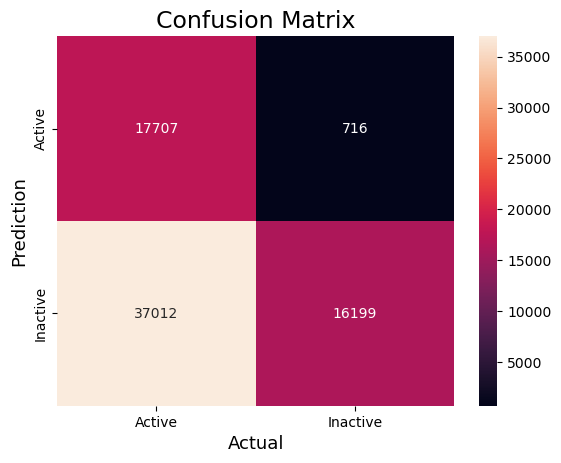

Precision: 0.3044295352464716
Recall: 0.9576707064735442
Epoch 131 | Train Loss 0.6919996738433838


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.4623648233596663
Accuracy: 0.47462099003266606


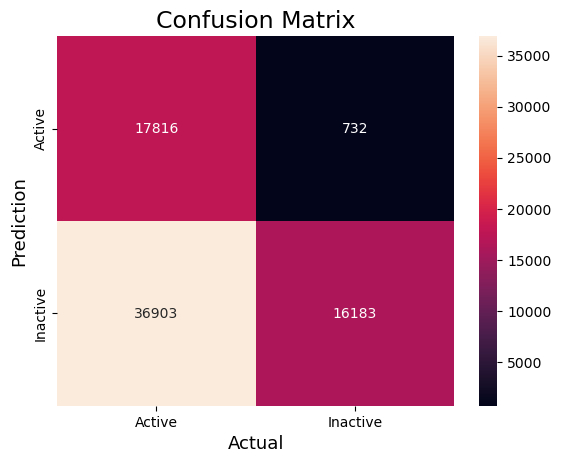

Precision: 0.30484496854161175
Recall: 0.956724800472953
Epoch 132 | Train Loss 0.6205545663833618


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46297120061989694
Accuracy: 0.4775525588407739


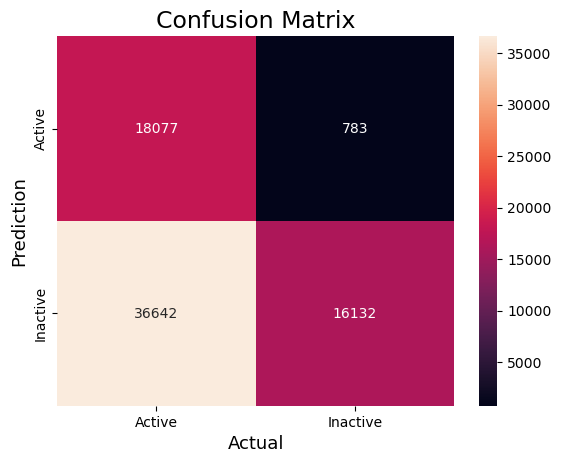

Precision: 0.30568082768029714
Recall: 0.9537097250960686
Epoch 133 | Train Loss 0.6785348653793335


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.46095796787789045
Accuracy: 0.47150794315548483


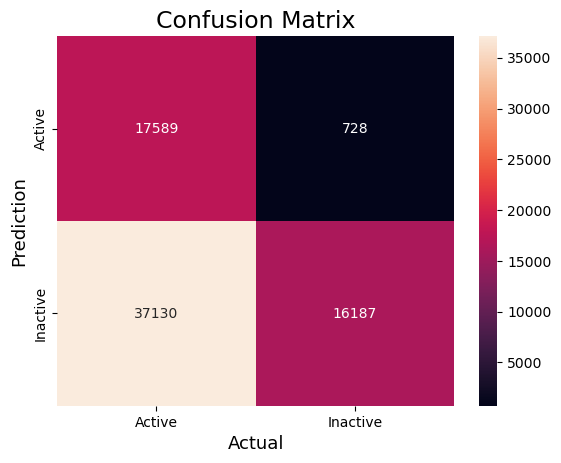

Precision: 0.3035992272633494
Recall: 0.9569612769731008
Epoch 134 | Train Loss 0.6254664063453674


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46049139628456476
Accuracy: 0.4721500963229751


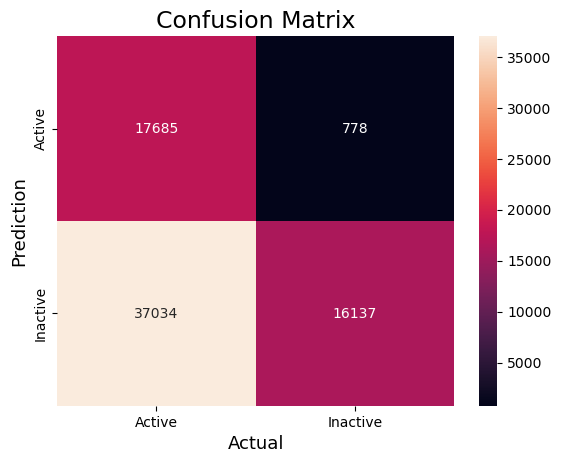

Precision: 0.3034925053130466
Recall: 0.9540053207212533
Epoch 135 | Train Loss 0.6186925172805786


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4627068854338325
Accuracy: 0.4765753692380713


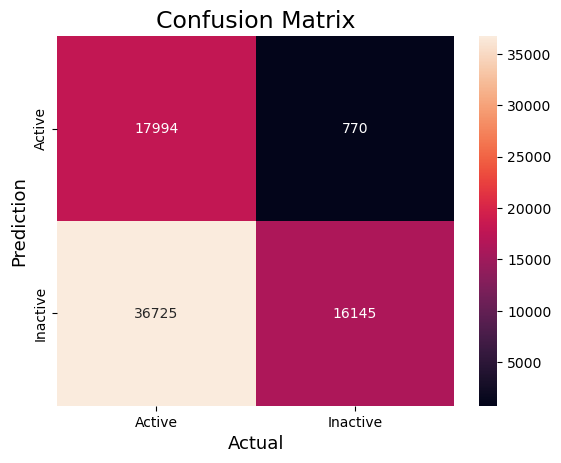

Precision: 0.30537166635142804
Recall: 0.9544782737215489
Epoch 136 | Train Loss 0.7005114555358887


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.12it/s]

F1 Score: 0.46305207693735634
Accuracy: 0.47506770527961584


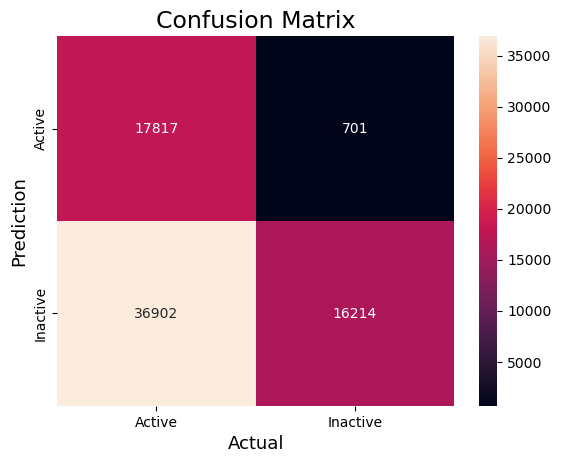

Precision: 0.3052564199111379
Recall: 0.9585574933490985
Epoch 137 | Train Loss 0.6550694704055786


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.13it/s]

F1 Score: 0.46387200367014564
Accuracy: 0.47795739453332214


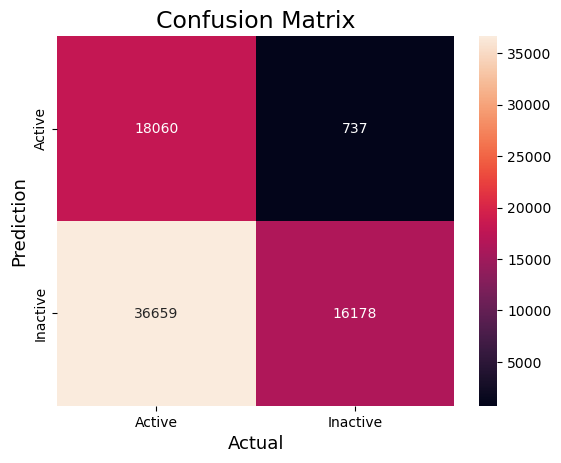

Precision: 0.30618695232507526
Recall: 0.9564292048477683
Epoch 138 | Train Loss 0.6299213171005249


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.12it/s]

F1 Score: 0.4629810453762206
Accuracy: 0.4779294748303878


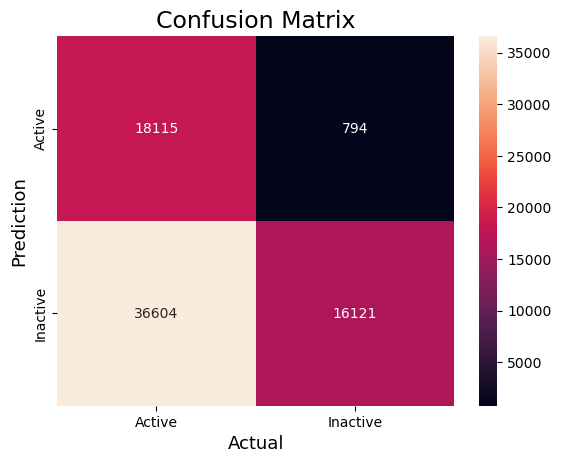

Precision: 0.3057562825983879
Recall: 0.9530594147206621
Epoch 139 | Train Loss 0.6362009048461914


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [20:05<00:00,  4.31s/it]  


F1 Score: 0.45946830149495754
Accuracy: 0.46951168439567803


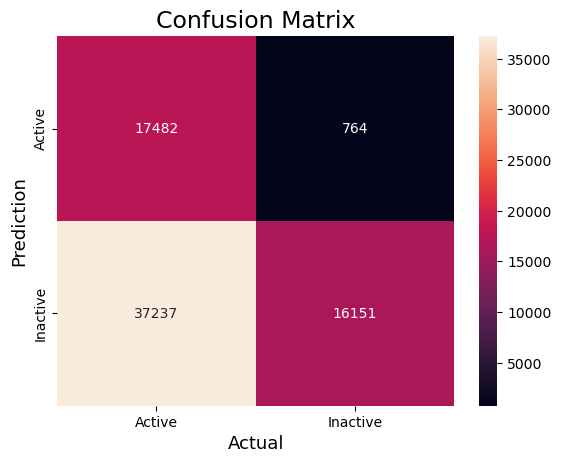

Precision: 0.30252116580504984
Recall: 0.9548329884717707
Epoch 140 | Train Loss 0.6549493670463562


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:03<00:00,  1.53it/s]

F1 Score: 0.4639791341234469
Accuracy: 0.4778596755730519


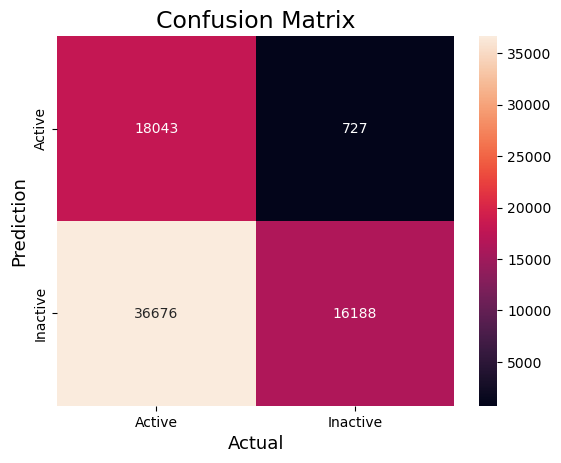

Precision: 0.30621973365617433
Recall: 0.9570203960981377
Epoch 141 | Train Loss 0.6159266829490662


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [18:03<00:00,  3.87s/it]  


F1 Score: 0.46216745529141
Accuracy: 0.4747885082502722


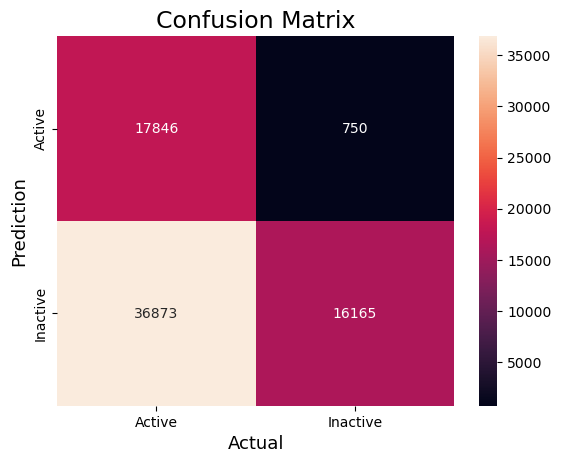

Precision: 0.3047814774312757
Recall: 0.9556606562222879
Epoch 142 | Train Loss 0.6114522218704224


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [05:36<00:00,  1.20s/it]

F1 Score: 0.46187898953260886
Accuracy: 0.4739509171622414


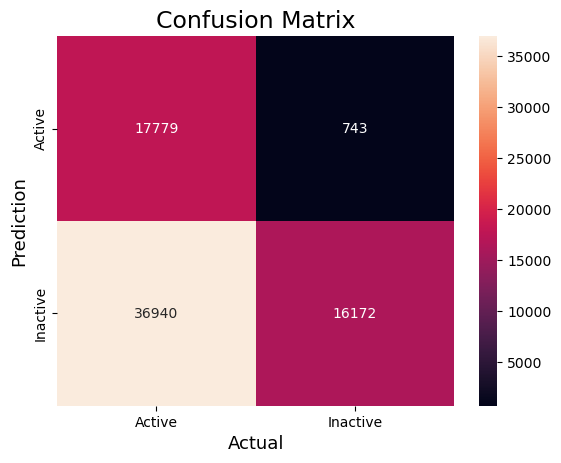

Precision: 0.3044886278053924
Recall: 0.9560744900975465
Epoch 143 | Train Loss 0.6175684332847595


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:08<00:00,  1.49it/s]

F1 Score: 0.4620814815873333
Accuracy: 0.4745093112209286


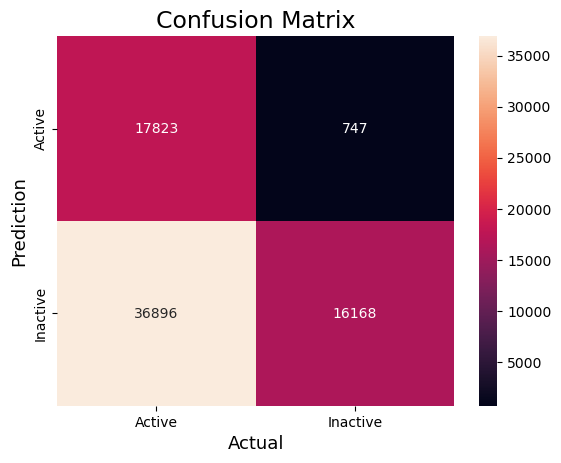

Precision: 0.3046886778230062
Recall: 0.9558380135973987
Epoch 144 | Train Loss 0.6339560151100159


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:05<00:00,  1.51it/s]


F1 Score: 0.4623683608058608
Accuracy: 0.47547254097216407


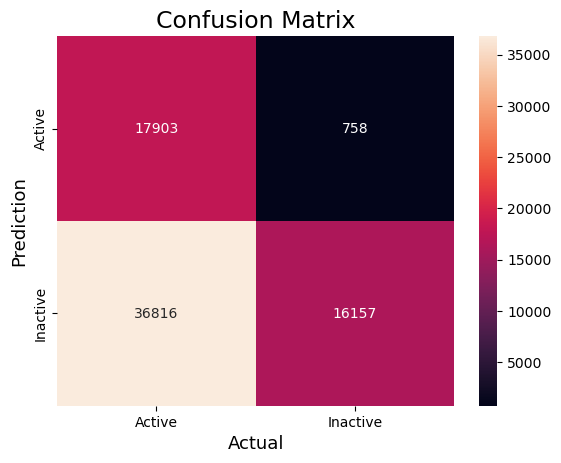

Precision: 0.3050044362222264
Recall: 0.9551877032219923
Epoch 145 | Train Loss 0.6283315420150757


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:07<00:00,  1.49it/s]


F1 Score: 0.4620845618755903
Accuracy: 0.4753608621604266


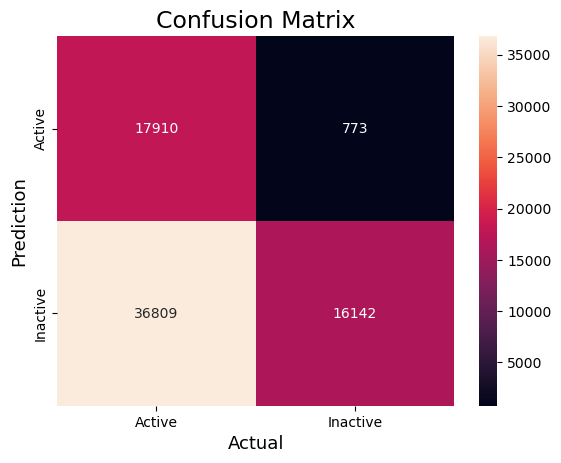

Precision: 0.30484787822704007
Recall: 0.9543009163464381
Epoch 146 | Train Loss 0.6212847828865051


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:07<00:00,  1.49it/s]

F1 Score: 0.46155823384931743
Accuracy: 0.4736298405784962


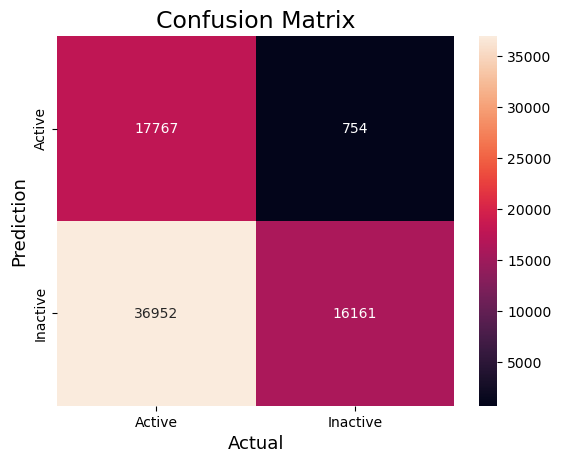

Precision: 0.3042757893547719
Recall: 0.9554241797221401
Epoch 147 | Train Loss 0.678083598613739


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:21<00:00,  1.98it/s]

F1 Score: 0.4625714570829828
Accuracy: 0.4737275595387665


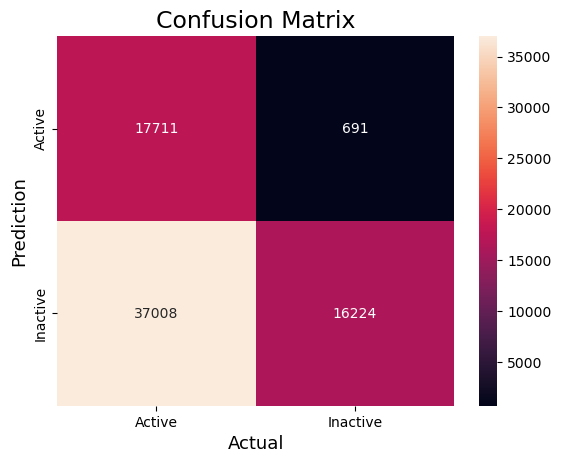

Precision: 0.3047790802524797
Recall: 0.9591486845994679
Epoch 148 | Train Loss 0.6438826322555542


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:20<00:00,  1.99it/s]

F1 Score: 0.4625445387290186
Accuracy: 0.47568193874417175


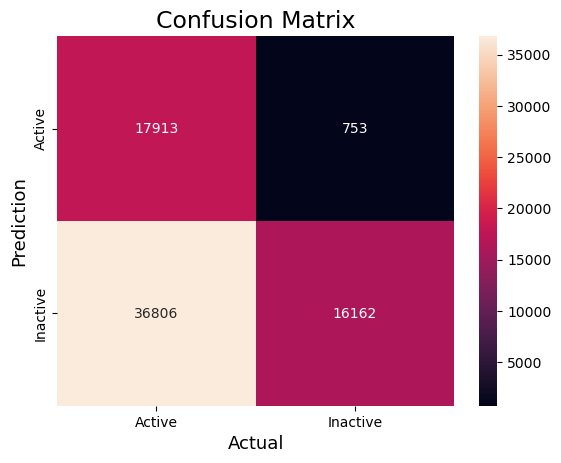

Precision: 0.30512762422594775
Recall: 0.9554832988471771
Epoch 149 | Train Loss 0.6586679816246033


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:25<00:00,  1.93it/s]

F1 Score: 0.4607667094199801
Accuracy: 0.4717871401848284


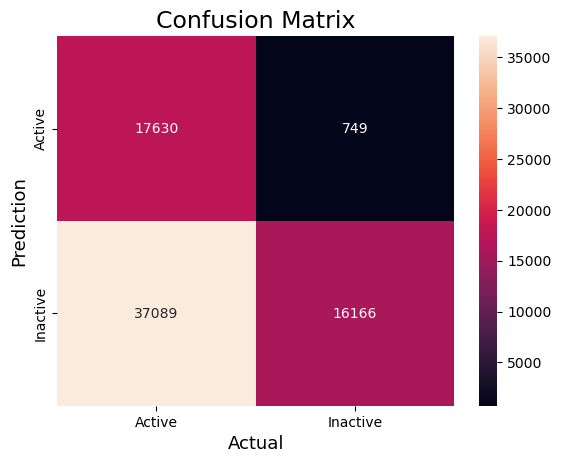

Precision: 0.3035583513285138
Recall: 0.9557197753473249
Epoch 150 | Train Loss 0.6088272333145142


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:25<00:00,  1.92it/s]

F1 Score: 0.4624502533856329
Accuracy: 0.4758075774073764


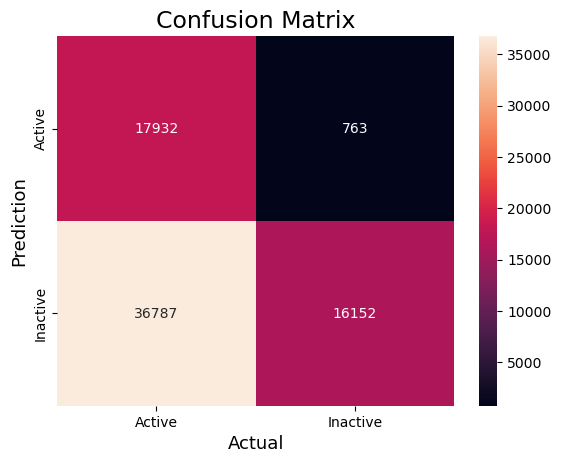

Precision: 0.3051058765749259
Recall: 0.9548921075968075
Epoch 151 | Train Loss 0.6585571765899658


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:28<00:00,  1.89it/s]

F1 Score: 0.46283049101522256
Accuracy: 0.4758634168132451


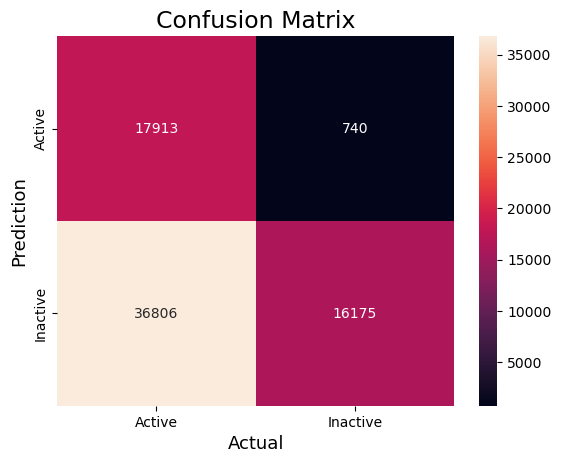

Precision: 0.30529812574319093
Recall: 0.9562518474726575
Epoch 152 | Train Loss 0.6329159736633301


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:24<00:00,  1.94it/s]

F1 Score: 0.46117310443490706
Accuracy: 0.4742161543401178


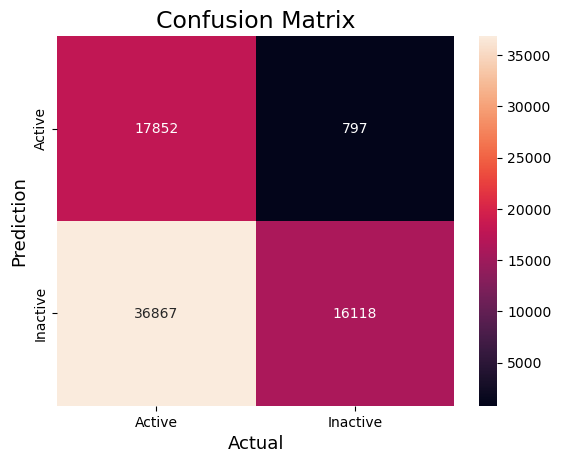

Precision: 0.3041993016891573
Recall: 0.9528820573455513
Epoch 153 | Train Loss 0.5876078605651855


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:24<00:00,  1.94it/s]

F1 Score: 0.4622219682575963
Accuracy: 0.47448139151799423


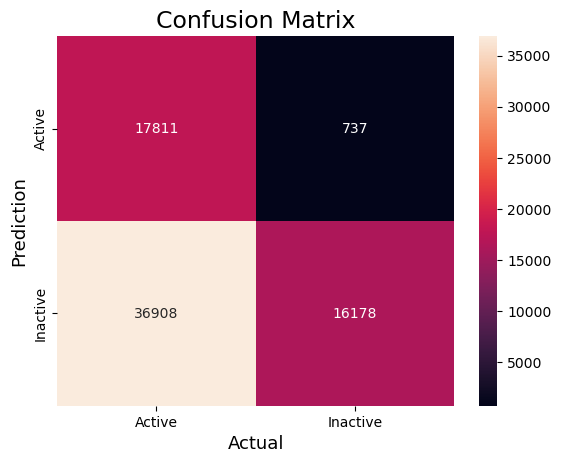

Precision: 0.30475078175036735
Recall: 0.9564292048477683
Epoch 154 | Train Loss 0.6746053695678711


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:20<00:00,  1.99it/s]

F1 Score: 0.462799982827459
Accuracy: 0.47596113577351534


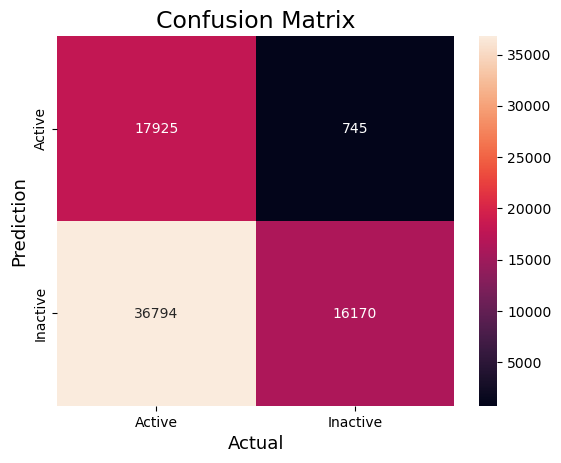

Precision: 0.3053017143720263
Recall: 0.9559562518474727
Epoch 155 | Train Loss 0.6596709489822388


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.4626808017511481
Accuracy: 0.4757098584471061


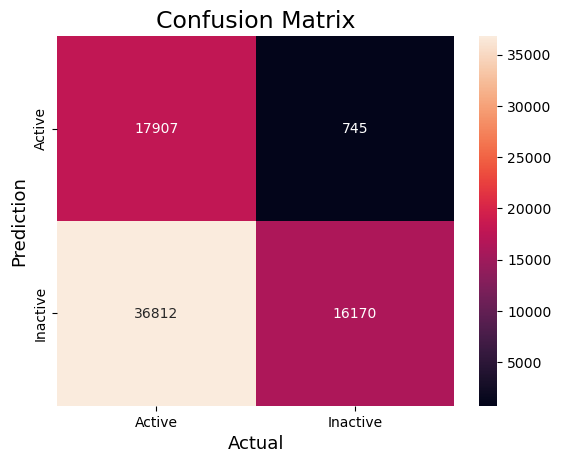

Precision: 0.3051979917707901
Recall: 0.9559562518474727
Epoch 156 | Train Loss 0.6546587347984314


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.12it/s]

F1 Score: 0.46232852217946707
Accuracy: 0.4752910629030907


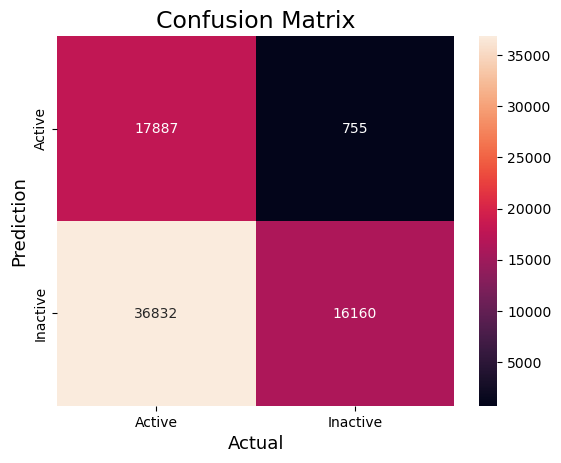

Precision: 0.30495169082125606
Recall: 0.9553650605971031
Epoch 157 | Train Loss 0.5880211591720581


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.12it/s]

F1 Score: 0.46242145791289163
Accuracy: 0.47568193874417175


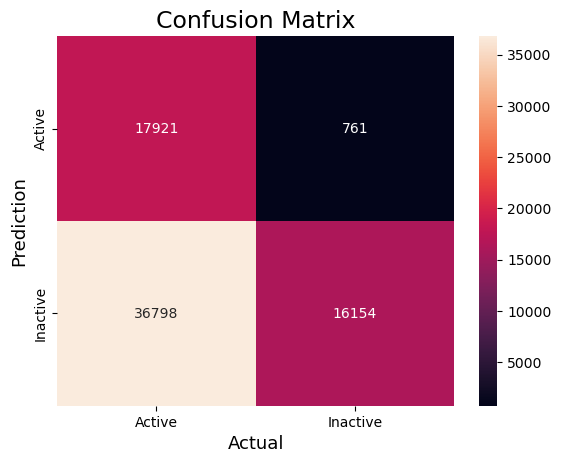

Precision: 0.3050687415017374
Recall: 0.9550103458468815
Epoch 158 | Train Loss 0.6619160771369934


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.09it/s]

F1 Score: 0.4617075642727649
Accuracy: 0.47358796102409473


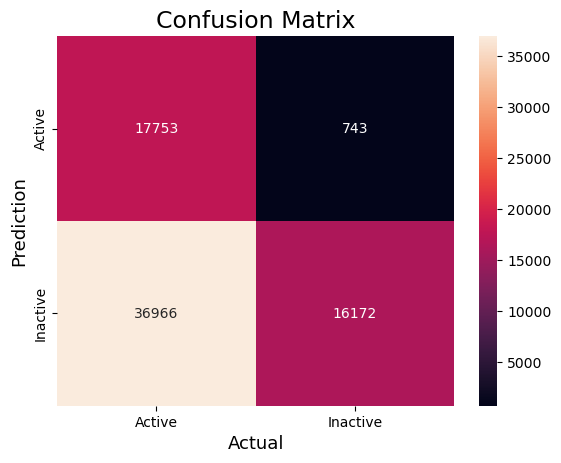

Precision: 0.30433964394595203
Recall: 0.9560744900975465
Epoch 159 | Train Loss 0.644818127155304


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4643103845268248
Accuracy: 0.4803584889856772


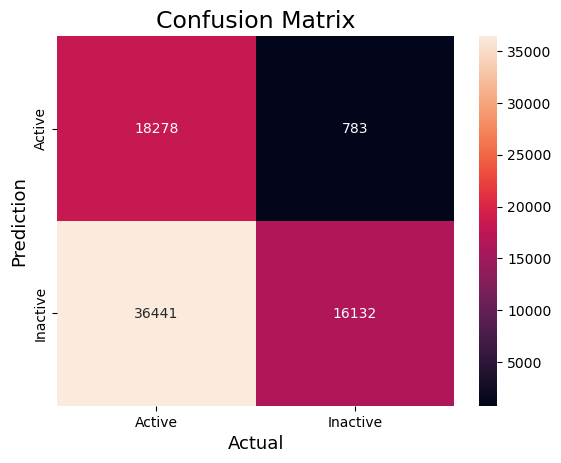

Precision: 0.3068495235196774
Recall: 0.9537097250960686
Epoch 160 | Train Loss 0.6886069178581238


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.4633129396930924
Accuracy: 0.4771058435938242


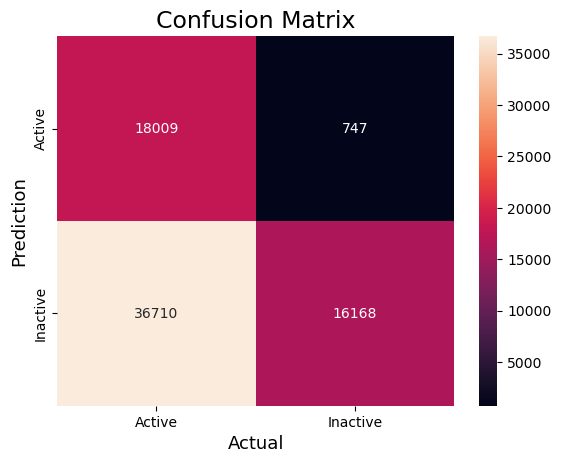

Precision: 0.30576042966829303
Recall: 0.9558380135973987
Epoch 161 | Train Loss 0.610565721988678


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.09it/s]

F1 Score: 0.4623978513057889
Accuracy: 0.47469078929000197


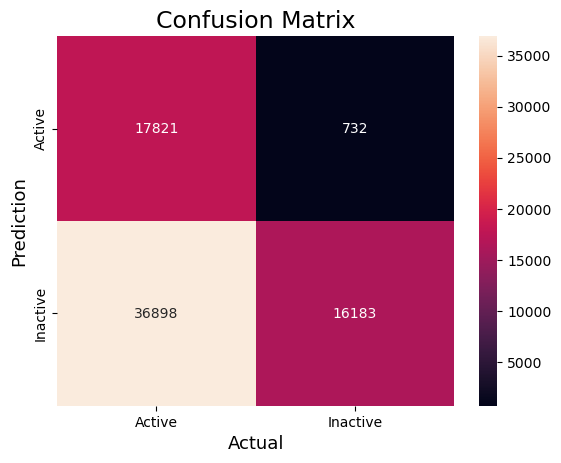

Precision: 0.30487368361560635
Recall: 0.956724800472953
Epoch 162 | Train Loss 0.6929346919059753


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.11it/s]

F1 Score: 0.46272824919441463
Accuracy: 0.4762961722087277


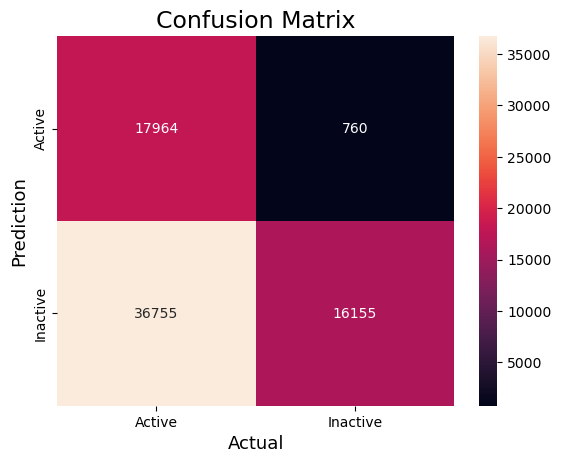

Precision: 0.3053298053298053
Recall: 0.9550694649719185
Epoch 163 | Train Loss 0.6952157020568848


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.12it/s]

F1 Score: 0.4621945827211913
Accuracy: 0.4736438004299634


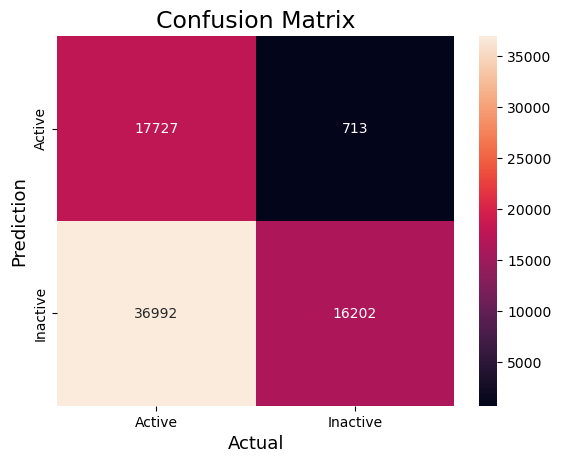

Precision: 0.3045832236718427
Recall: 0.9578480638486551
Epoch 164 | Train Loss 0.6745042204856873


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.12it/s]

F1 Score: 0.4633978888348543
Accuracy: 0.47628221235726054


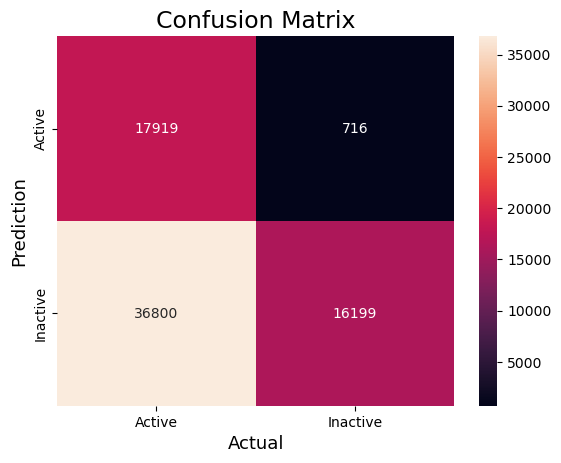

Precision: 0.305647276363705
Recall: 0.9576707064735442
Epoch 165 | Train Loss 0.6839234828948975


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4618614415675298
Accuracy: 0.4739788368651758


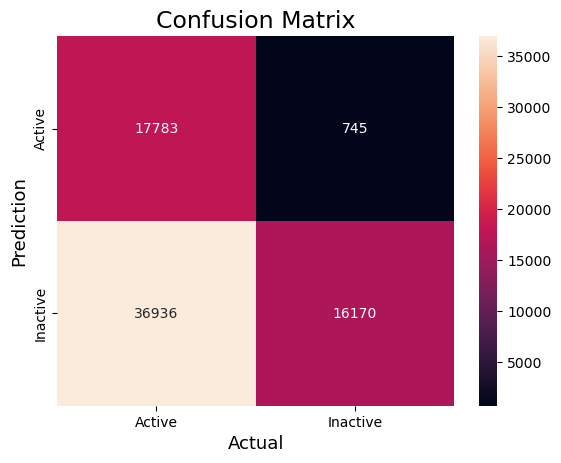

Precision: 0.30448536888487177
Recall: 0.9559562518474727
Epoch 166 | Train Loss 0.6450372934341431


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.4619101396652038
Accuracy: 0.47453723092386296


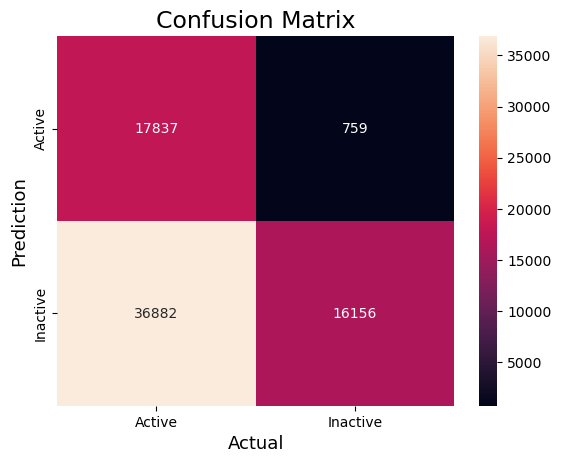

Precision: 0.30461178777480297
Recall: 0.9551285840969553
Epoch 167 | Train Loss 0.6124392747879028


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.09it/s]

F1 Score: 0.462121535940728
Accuracy: 0.4730016472624731


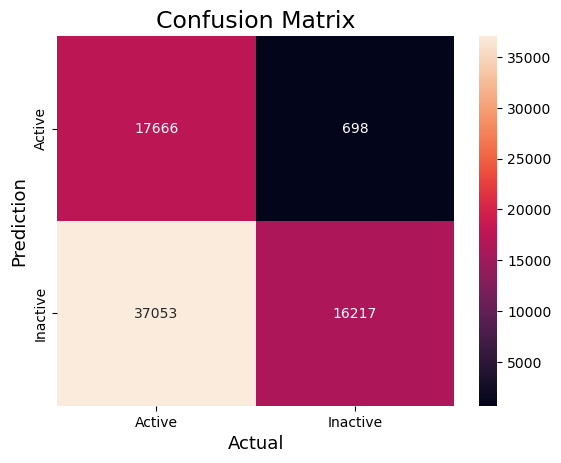

Precision: 0.30443026093486014
Recall: 0.9587348507242093
Epoch 168 | Train Loss 0.6637277007102966


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4622644215599094
Accuracy: 0.47661724879247286


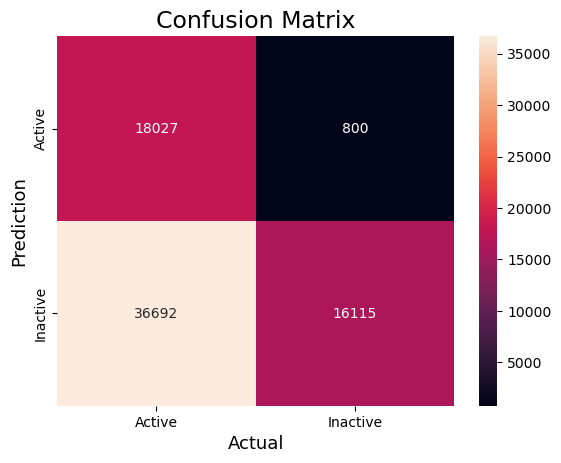

Precision: 0.30516787547105495
Recall: 0.9527046999704404
Epoch 169 | Train Loss 0.6371259689331055


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:47<00:00,  1.67it/s]

F1 Score: 0.46316723178391067
Accuracy: 0.47618449339699026


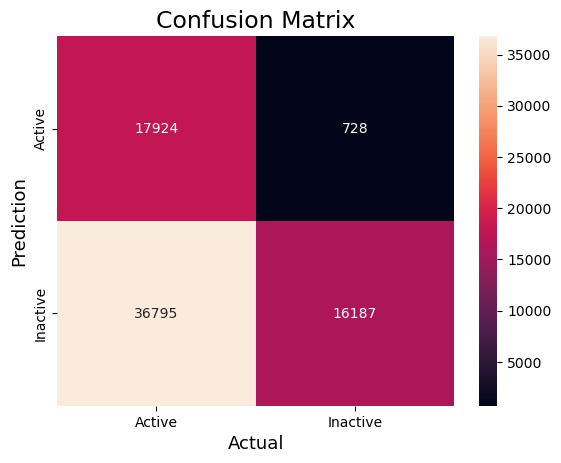

Precision: 0.305518855460345
Recall: 0.9569612769731008
Epoch 170 | Train Loss 0.709159791469574


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [07:31<00:00,  1.61s/it]

F1 Score: 0.4602209471610859
Accuracy: 0.472066337214172


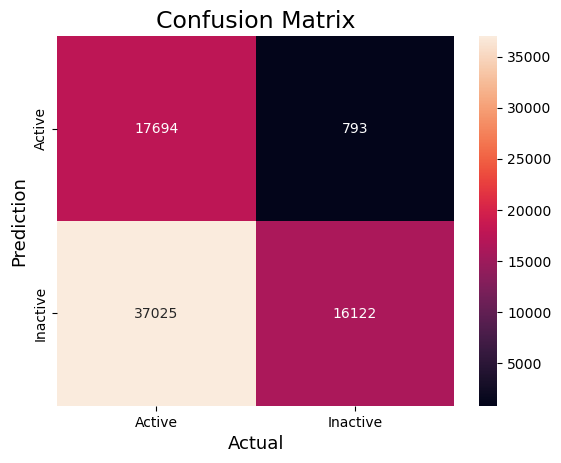

Precision: 0.30334731969819556
Recall: 0.9531185338456991
Epoch 171 | Train Loss 0.6378037929534912


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.4621920865161789
Accuracy: 0.4751654242398861


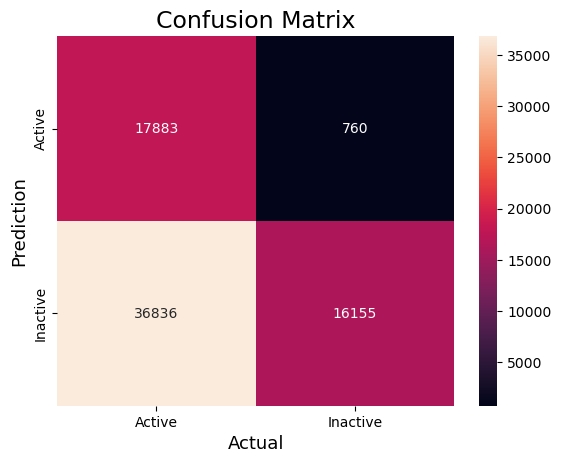

Precision: 0.30486308995867223
Recall: 0.9550694649719185
Epoch 172 | Train Loss 0.6551574468612671


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.462611280204627
Accuracy: 0.4750118658737471


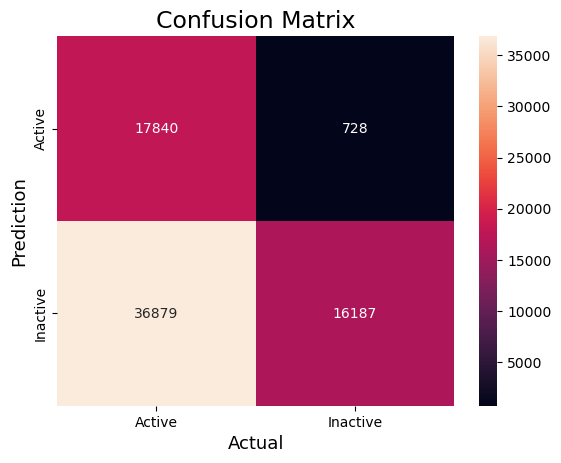

Precision: 0.30503523913617003
Recall: 0.9569612769731008
Epoch 173 | Train Loss 0.6607856750488281


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.08it/s]

F1 Score: 0.4611718370958075
Accuracy: 0.4728760085992685


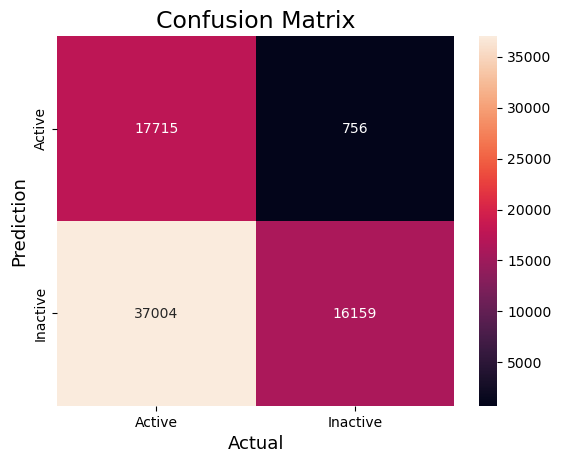

Precision: 0.30395199668942685
Recall: 0.9553059414720663
Epoch 174 | Train Loss 0.6340279579162598


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.46157796385318745
Accuracy: 0.4730854063712762


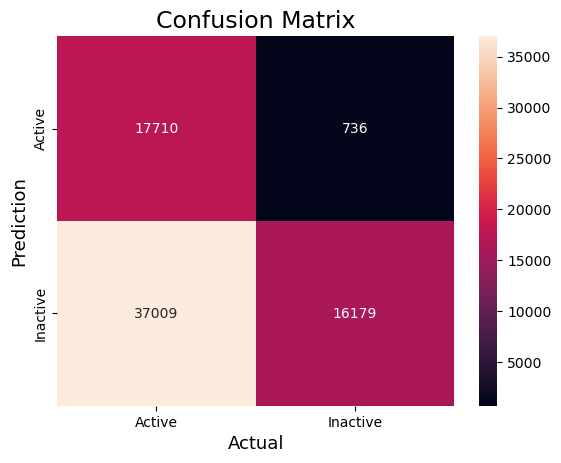

Precision: 0.3041851545461382
Recall: 0.9564883239728053
Epoch 175 | Train Loss 0.6676399111747742


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.12it/s]

F1 Score: 0.4620949984271784
Accuracy: 0.47483038780467374


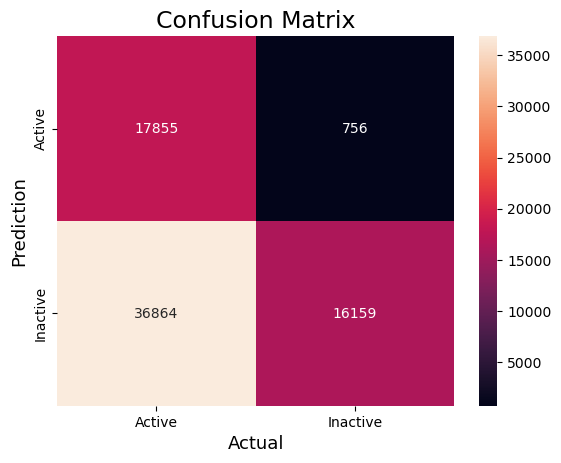

Precision: 0.30475454048243217
Recall: 0.9553059414720663
Epoch 176 | Train Loss 0.6966846585273743


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:11<00:00,  2.12it/s]

F1 Score: 0.4623245030269203
Accuracy: 0.4755423402295


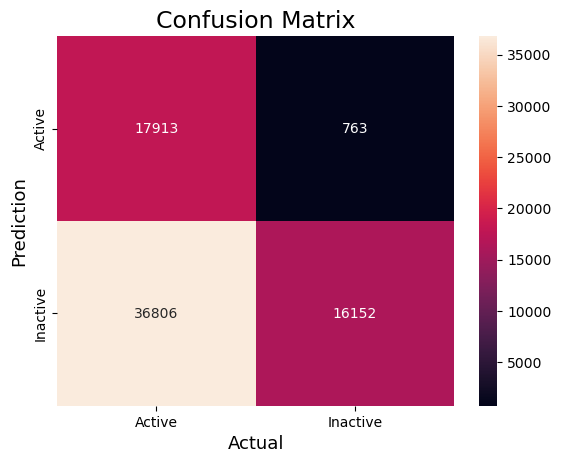

Precision: 0.30499641225121793
Recall: 0.9548921075968075
Epoch 177 | Train Loss 0.6618922352790833


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:10<00:00,  2.15it/s]

F1 Score: 0.4620027748773476
Accuracy: 0.474928106764944


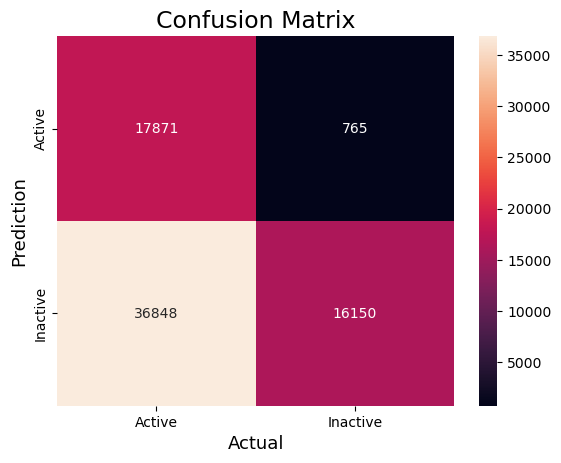

Precision: 0.3047284803200121
Recall: 0.9547738693467337
Epoch 178 | Train Loss 0.6067973971366882


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:25<00:00,  1.93it/s]

F1 Score: 0.4620459218642906
Accuracy: 0.474076555825446


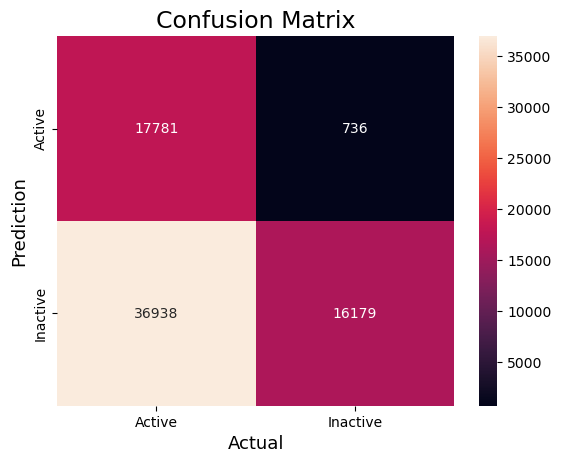

Precision: 0.30459175028710206
Recall: 0.9564883239728053
Epoch 179 | Train Loss 0.6427417397499084


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.72it/s]

F1 Score: 0.4632246402800292
Accuracy: 0.47766423765251137


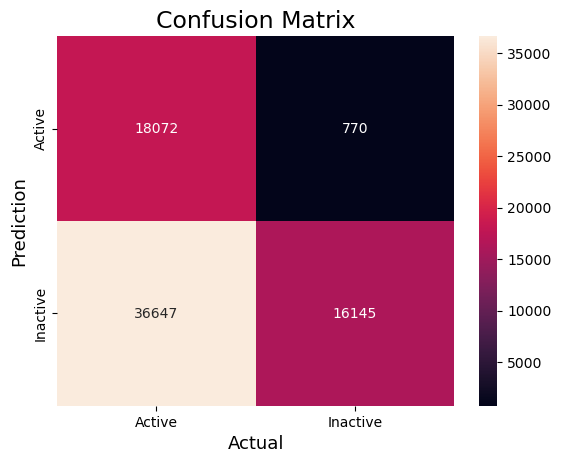

Precision: 0.3058228519472647
Recall: 0.9544782737215489
Epoch 180 | Train Loss 0.6943434476852417


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.72it/s]

F1 Score: 0.4622735986723511
Accuracy: 0.4753050227545579


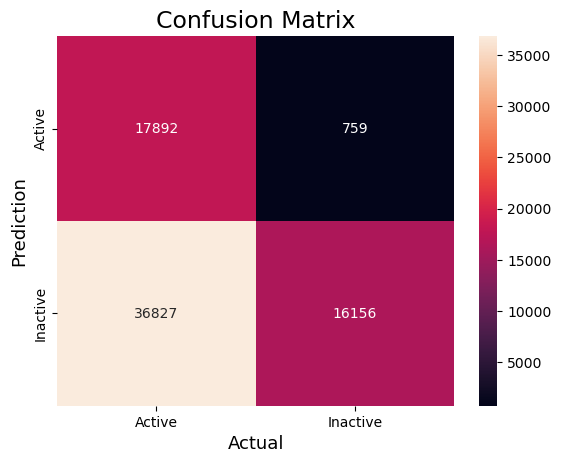

Precision: 0.30492799577222884
Recall: 0.9551285840969553
Epoch 181 | Train Loss 0.6672154664993286


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:41<00:00,  1.73it/s]

F1 Score: 0.4623414508587036
Accuracy: 0.47512354468548457


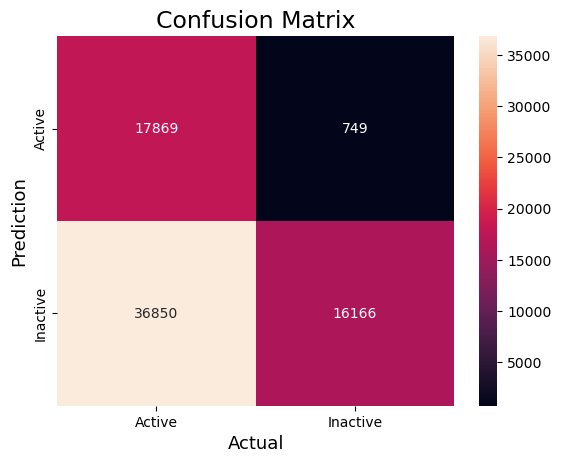

Precision: 0.30492681454655196
Recall: 0.9557197753473249
Epoch 182 | Train Loss 0.6332889795303345


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:41<00:00,  1.73it/s]

F1 Score: 0.46286107290233836
Accuracy: 0.4766730881983416


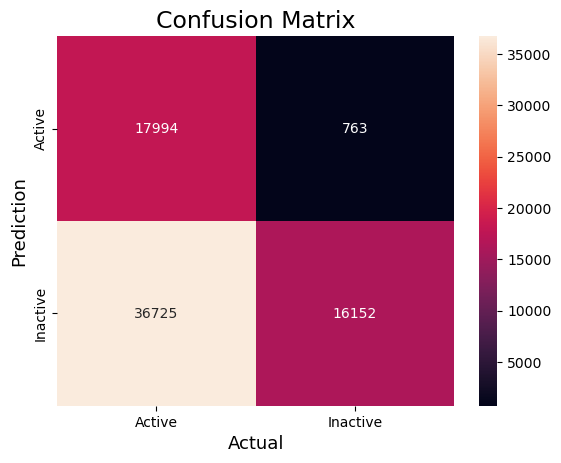

Precision: 0.3054636231253664
Recall: 0.9548921075968075
Epoch 183 | Train Loss 0.6386027336120605


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.71it/s]

F1 Score: 0.4612727817660239
Accuracy: 0.47305748666834185


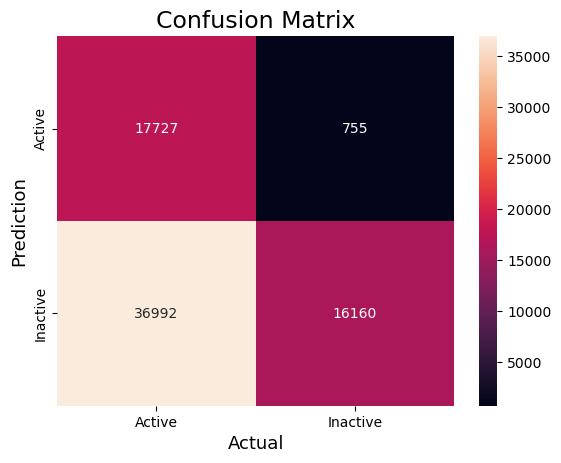

Precision: 0.3040337146297411
Recall: 0.9553650605971031
Epoch 184 | Train Loss 0.6622902154922485


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:45<00:00,  1.69it/s]

F1 Score: 0.46339062834319955
Accuracy: 0.4748443476561409


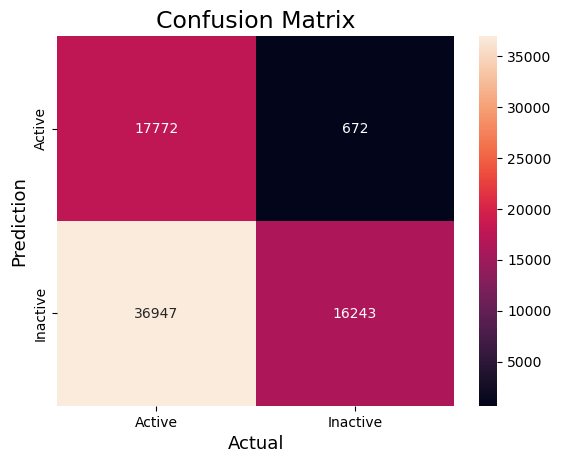

Precision: 0.30537695055461556
Recall: 0.96027194797517
Epoch 185 | Train Loss 0.6347509026527405


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.71it/s]

F1 Score: 0.46396305962658096
Accuracy: 0.47818075215679706


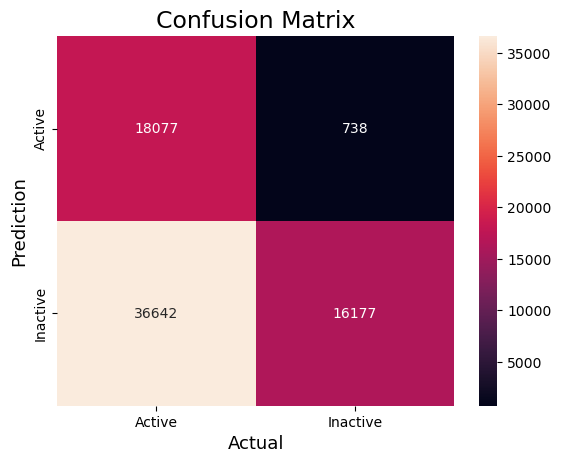

Precision: 0.3062723641113993
Recall: 0.9563700857227313
Epoch 186 | Train Loss 0.6399694085121155


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.72it/s]

F1 Score: 0.46191632157646717
Accuracy: 0.4739648770137086


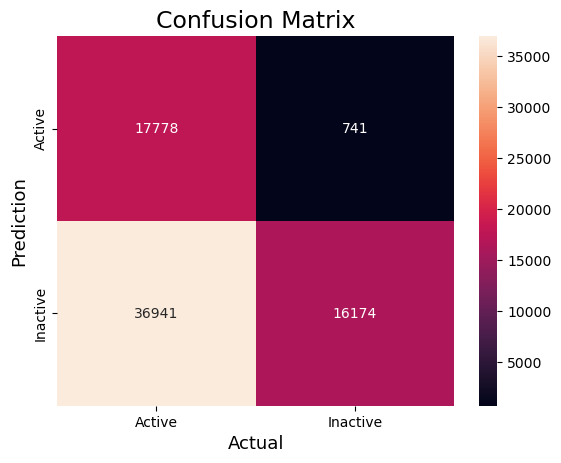

Precision: 0.3045090840628824
Recall: 0.9561927283476205
Epoch 187 | Train Loss 0.605056643486023


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:46<00:00,  1.68it/s]

F1 Score: 0.4632610216934919
Accuracy: 0.47534690230895943


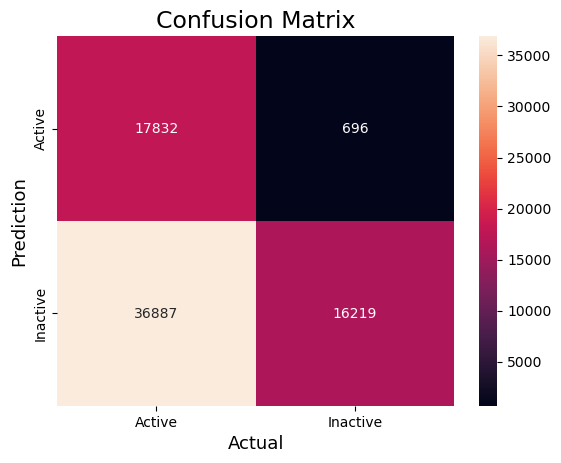

Precision: 0.30540805182088654
Recall: 0.9588530889742832
Epoch 188 | Train Loss 0.651757001876831


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.71it/s]

F1 Score: 0.46323360843649697
Accuracy: 0.4770360443364883


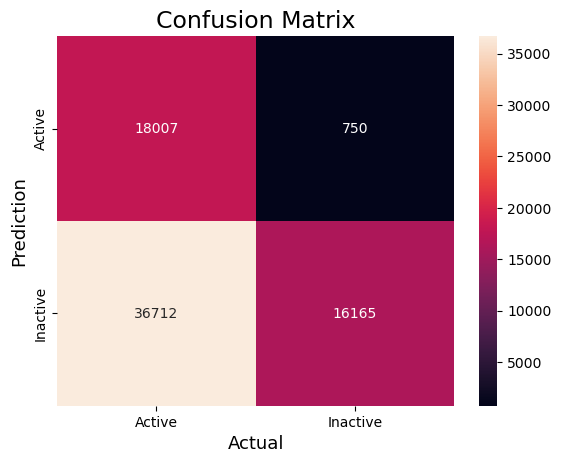

Precision: 0.3057094767101008
Recall: 0.9556606562222879
Epoch 189 | Train Loss 0.6298190355300903


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.72it/s]

F1 Score: 0.4620581079146987
Accuracy: 0.4753050227545579


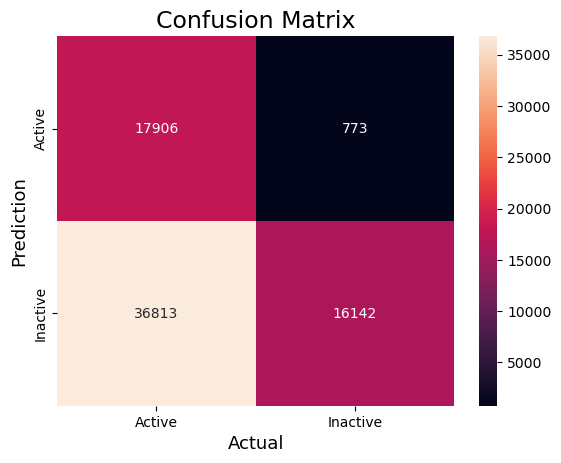

Precision: 0.30482485128883013
Recall: 0.9543009163464381
Epoch 190 | Train Loss 0.6545758247375488


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:44<00:00,  1.70it/s]

F1 Score: 0.46289798198249815
Accuracy: 0.4764916101292682


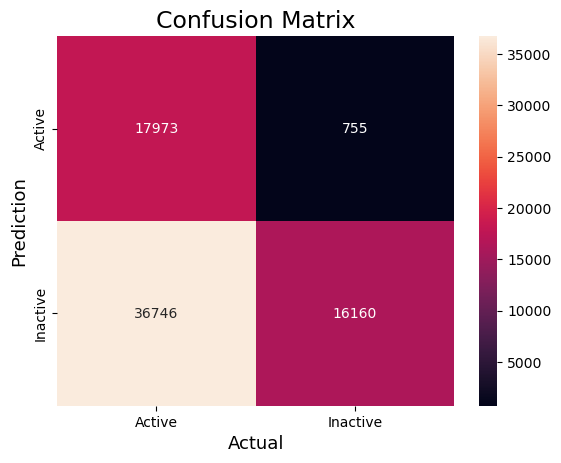

Precision: 0.3054473972706309
Recall: 0.9553650605971031
Epoch 191 | Train Loss 0.6497519016265869


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:20<00:00,  2.00it/s]

F1 Score: 0.46295290114101056
Accuracy: 0.47566797889270457


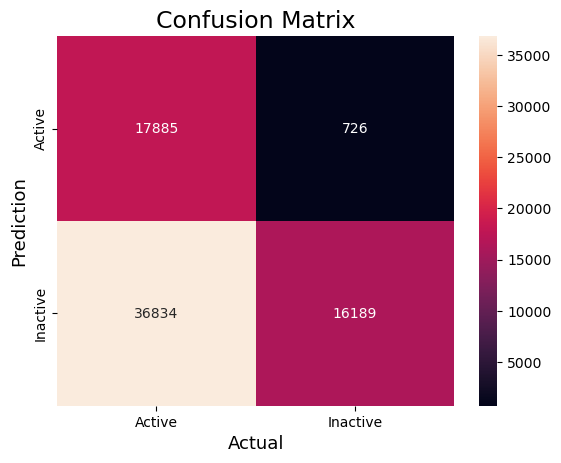

Precision: 0.3053203326858156
Recall: 0.9570795152231747
Epoch 192 | Train Loss 0.669779896736145


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.09it/s]

F1 Score: 0.4621878800887172
Accuracy: 0.47531898260602506


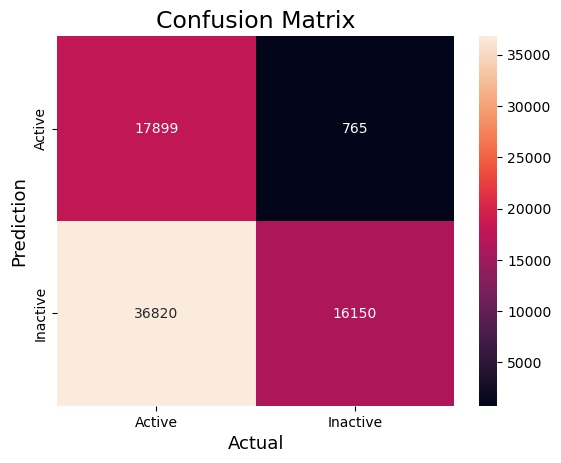

Precision: 0.30488956012837454
Recall: 0.9547738693467337
Epoch 193 | Train Loss 0.6450680494308472


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.4620784504741984
Accuracy: 0.47583549711031076


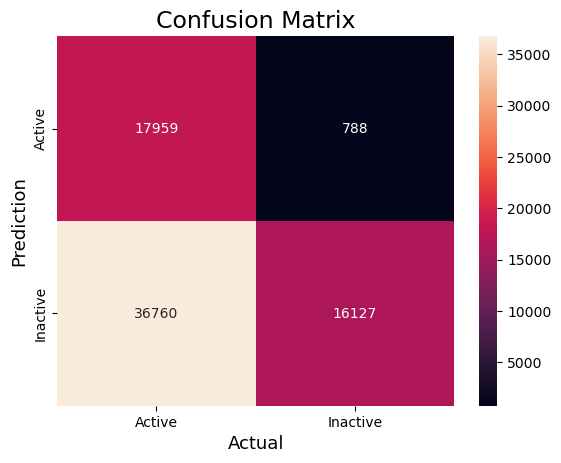

Precision: 0.3049331593775408
Recall: 0.9534141294708838
Epoch 194 | Train Loss 0.6447292566299438


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.12it/s]

F1 Score: 0.4629316520991546
Accuracy: 0.4767568473071446


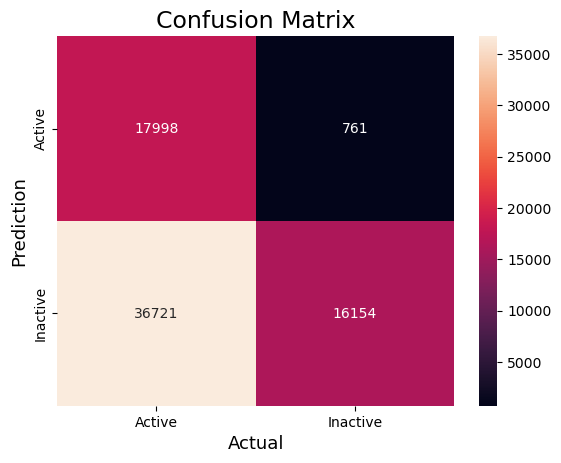

Precision: 0.3055130023640662
Recall: 0.9550103458468815
Epoch 195 | Train Loss 0.6623235940933228


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46125667186583297
Accuracy: 0.4744255521121255


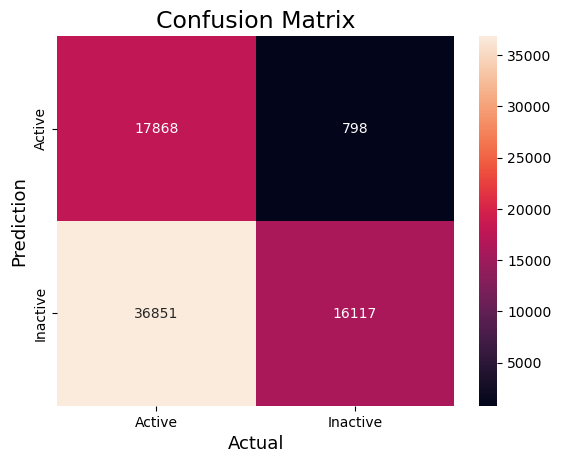

Precision: 0.30427805467452046
Recall: 0.9528229382205143
Epoch 196 | Train Loss 0.6329696774482727


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4615516821586629
Accuracy: 0.47517938409135324


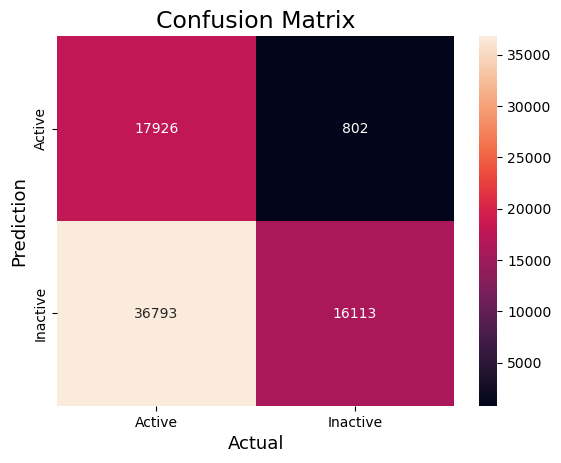

Precision: 0.30455902922163836
Recall: 0.9525864617203665
Epoch 197 | Train Loss 0.6125993132591248


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4621809081158384
Accuracy: 0.4750118658737471


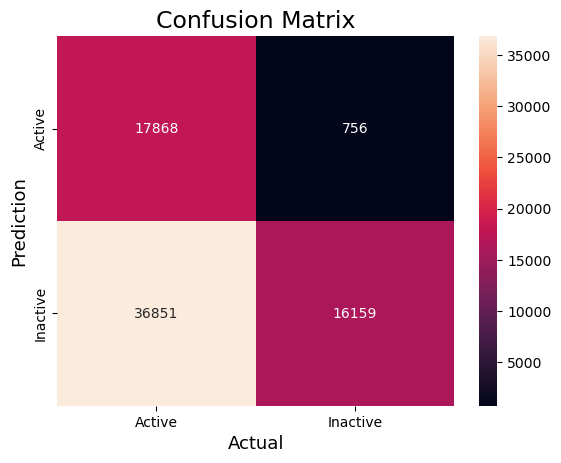

Precision: 0.3048292774948123
Recall: 0.9553059414720663
Epoch 198 | Train Loss 0.6855617165565491


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.46237035977397895
Accuracy: 0.47534690230895943


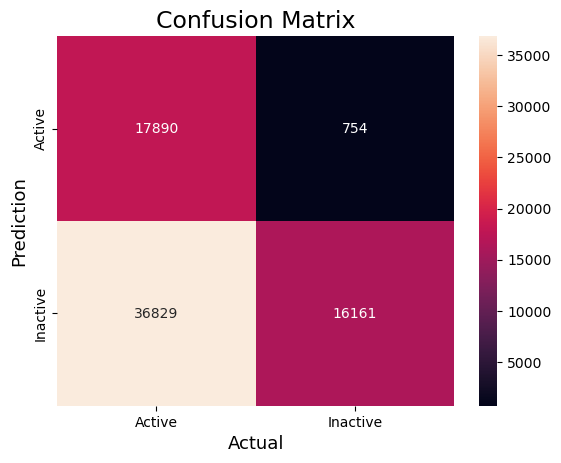

Precision: 0.3049820720890734
Recall: 0.9554241797221401
Epoch 199 | Train Loss 0.646259605884552


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46202170188463737
Accuracy: 0.47399279671664296


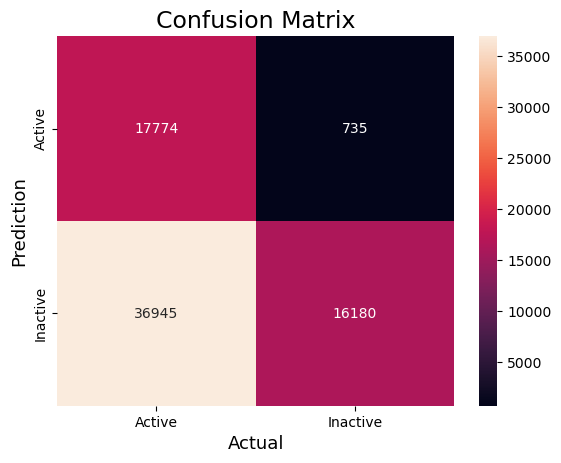

Precision: 0.30456470588235296
Recall: 0.9565474430978421
Epoch 200 | Train Loss 0.6988229751586914


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46147684032844105
Accuracy: 0.47446743166652705


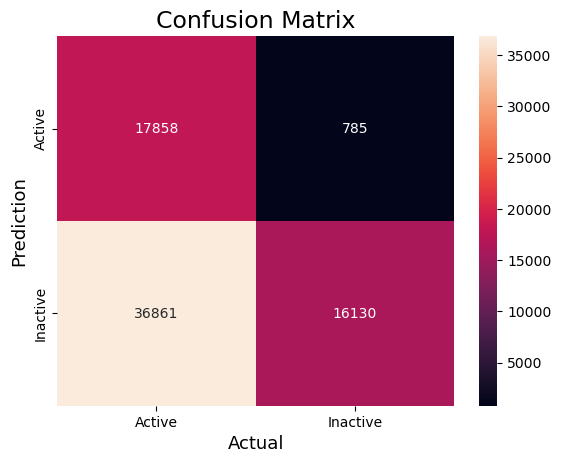

Precision: 0.3043913117321809
Recall: 0.9535914868459947
Epoch 201 | Train Loss 0.6261196136474609


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.4616395878881411
Accuracy: 0.4740625959739788


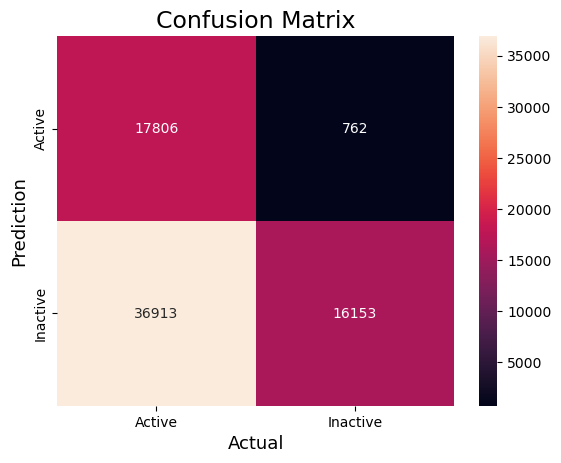

Precision: 0.30439452756944185
Recall: 0.9549512267218445
Epoch 202 | Train Loss 0.683871865272522


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46198838792918073
Accuracy: 0.47610073428818717


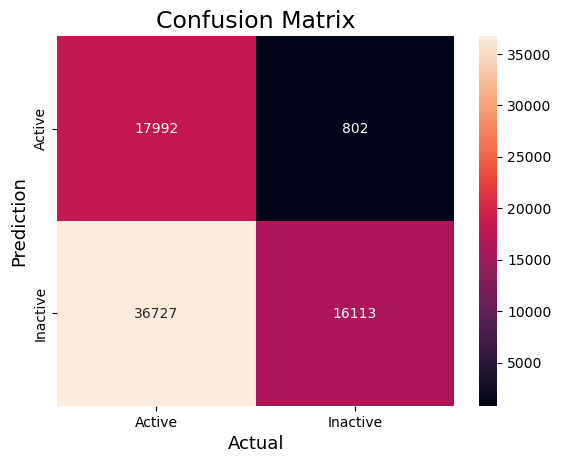

Precision: 0.30493943981831945
Recall: 0.9525864617203665
Epoch 203 | Train Loss 0.685702383518219


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.4635368927589367
Accuracy: 0.477091883742357


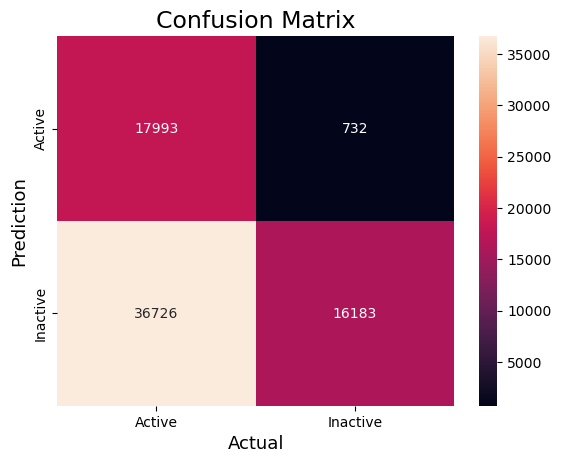

Precision: 0.3058647867092555
Recall: 0.956724800472953
Epoch 204 | Train Loss 0.630336344242096


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:12<00:00,  2.11it/s]

F1 Score: 0.46265453296703296
Accuracy: 0.47575173800150766


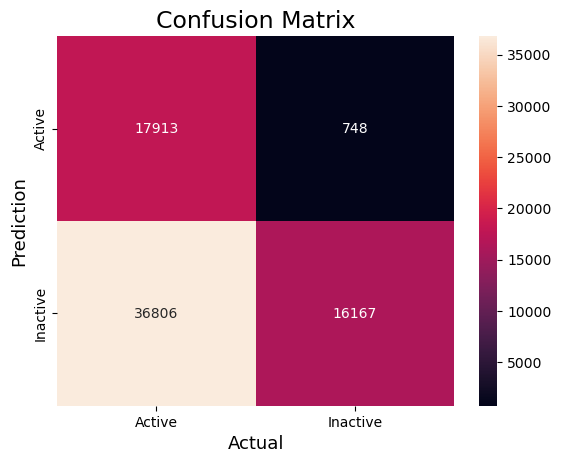

Precision: 0.3051932116361165
Recall: 0.9557788944723619
Epoch 205 | Train Loss 0.6471940279006958


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.46265391050667126
Accuracy: 0.4754585811206969


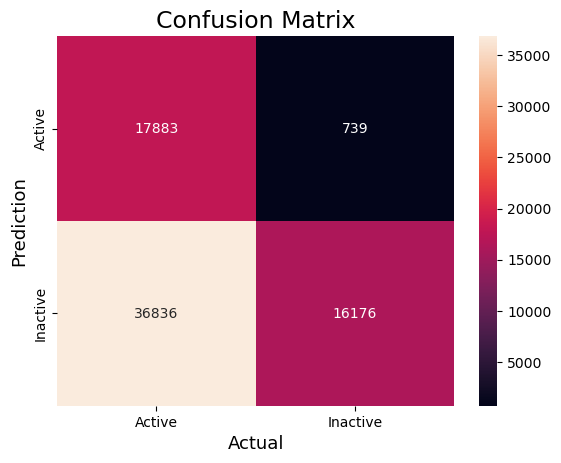

Precision: 0.3051384592167811
Recall: 0.9563109665976943
Epoch 206 | Train Loss 0.6555110812187195


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.09it/s]

F1 Score: 0.4618902003372296
Accuracy: 0.4742999134489209


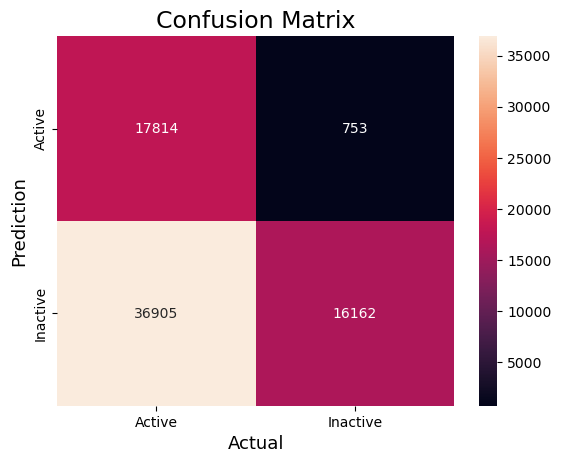

Precision: 0.30455838845233385
Recall: 0.9554832988471771
Epoch 207 | Train Loss 0.6925667524337769


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.09it/s]

F1 Score: 0.4635336892884238
Accuracy: 0.47682664656448054


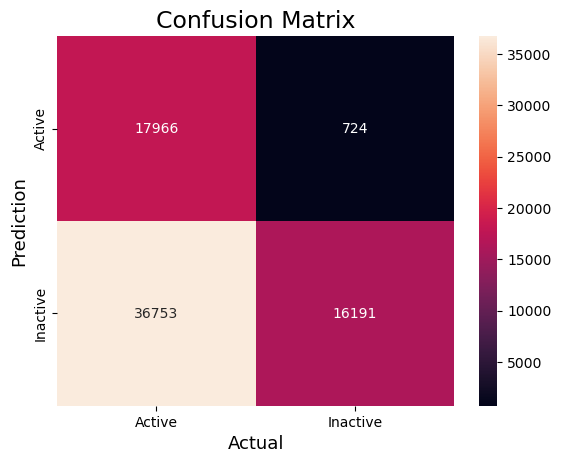

Precision: 0.30581368993653674
Recall: 0.9571977534732486
Epoch 208 | Train Loss 0.6422796845436096


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [2:47:43<00:00, 35.94s/it]     


F1 Score: 0.4631542749065066
Accuracy: 0.47696624507915236


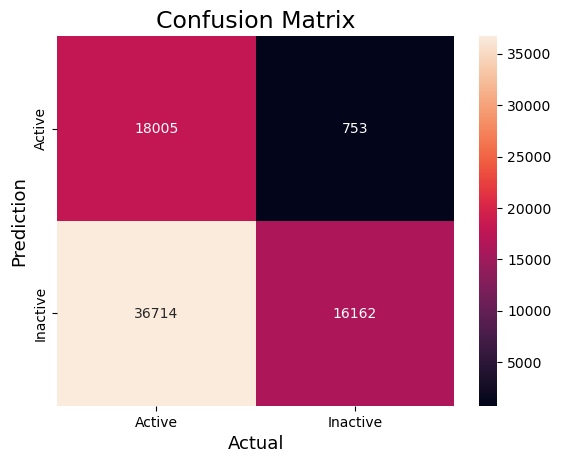

Precision: 0.30565852182464637
Recall: 0.9554832988471771
Epoch 209 | Train Loss 0.626966655254364


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [05:12<00:00,  1.12s/it]

F1 Score: 0.4620423340961098
Accuracy: 0.47491414691347683


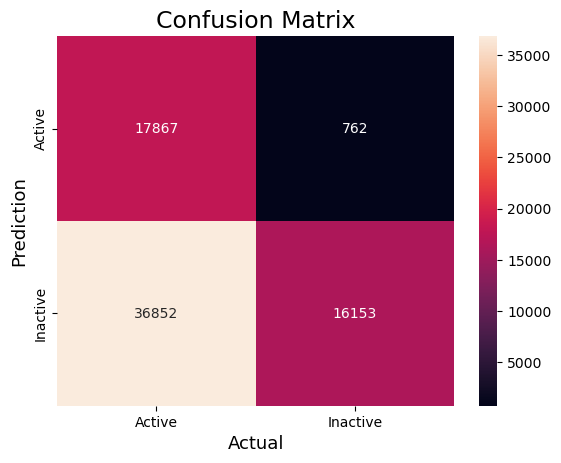

Precision: 0.30474483539288744
Recall: 0.9549512267218445
Epoch 210 | Train Loss 0.6195207238197327


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:42<00:00,  1.72it/s]

F1 Score: 0.46277665995975853
Accuracy: 0.47445347181505987


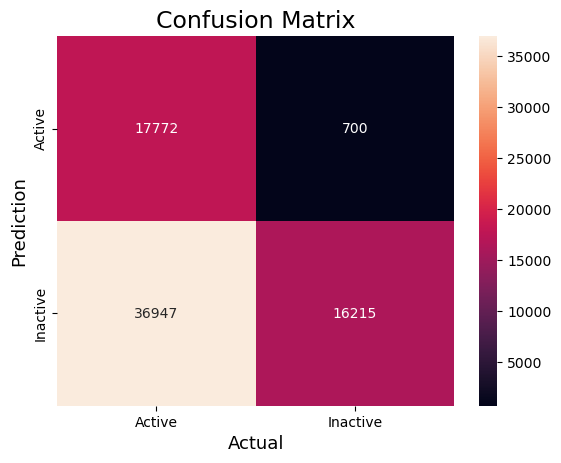

Precision: 0.3050110981528159
Recall: 0.9586166124741354
Epoch 211 | Train Loss 0.6158072352409363


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:43<00:00,  1.71it/s]

F1 Score: 0.4628316936604087
Accuracy: 0.4763520116145964


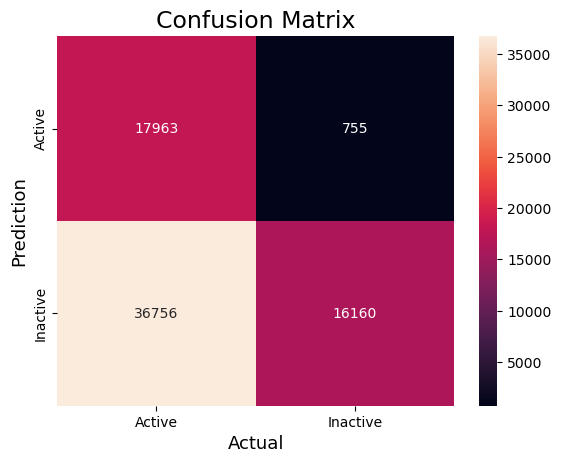

Precision: 0.30538967420061985
Recall: 0.9553650605971031
Epoch 212 | Train Loss 0.6214732527732849


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [3:10:01<00:00, 40.72s/it]     


F1 Score: 0.4635147548513033
Accuracy: 0.4782086718597314


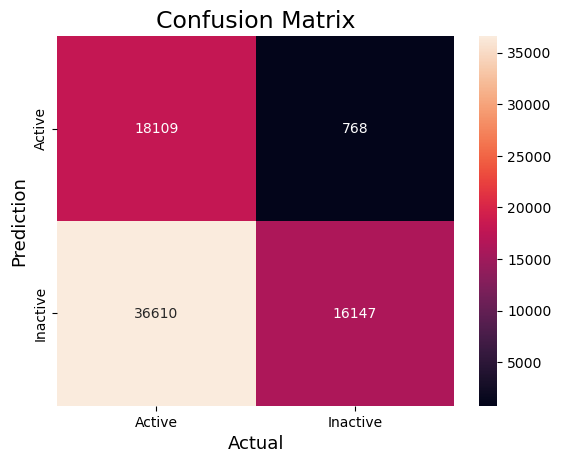

Precision: 0.30606365032128435
Recall: 0.9545965119716229
Epoch 213 | Train Loss 0.67261803150177


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [03:52<00:00,  1.20it/s]

F1 Score: 0.4628473216843311
Accuracy: 0.47644973057486667


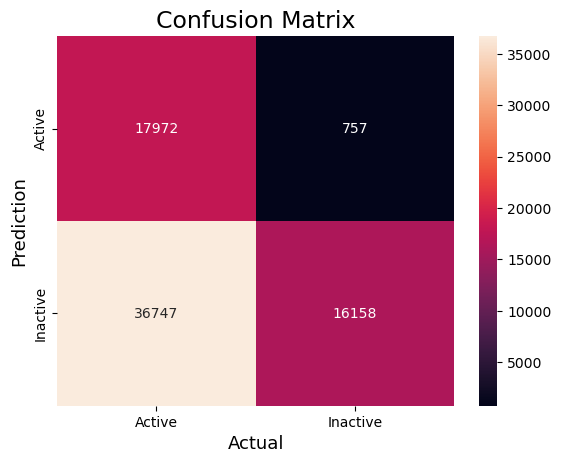

Precision: 0.3054153671675645
Recall: 0.9552468223470293
Epoch 214 | Train Loss 0.6481853723526001


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:18<00:00,  2.01it/s]

F1 Score: 0.4625334458927728
Accuracy: 0.475626099338303


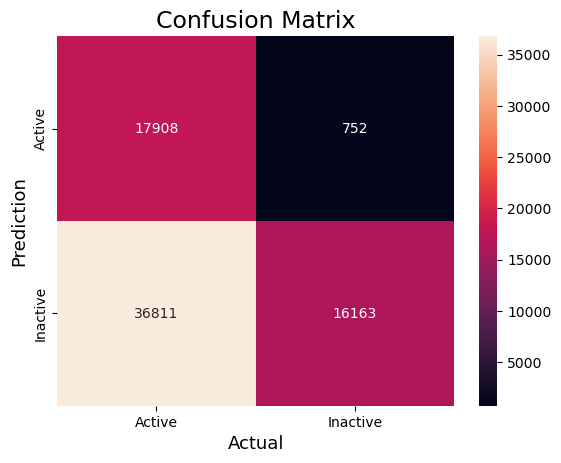

Precision: 0.3051119417072526
Recall: 0.9555424179722141
Epoch 215 | Train Loss 0.6775854229927063


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.46211937011027365
Accuracy: 0.4750118658737471


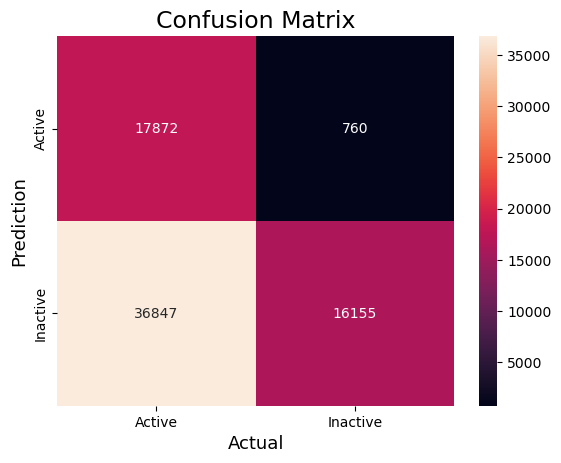

Precision: 0.30479981887475943
Recall: 0.9550694649719185
Epoch 216 | Train Loss 0.6838024854660034


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:13<00:00,  2.10it/s]

F1 Score: 0.4629048662741559
Accuracy: 0.4766032889410057


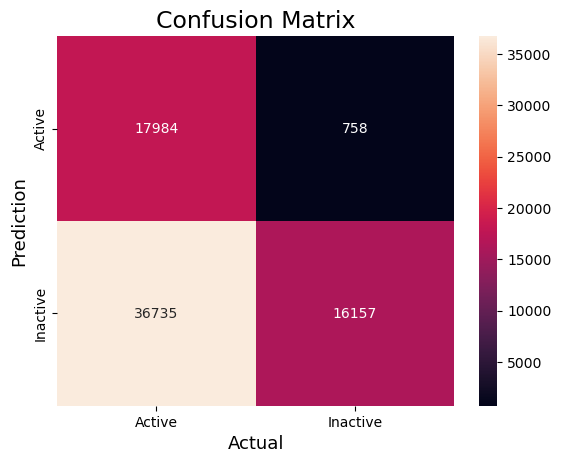

Precision: 0.30547152688497314
Recall: 0.9551877032219923
Epoch 217 | Train Loss 0.6797428131103516


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:17<00:00,  2.03it/s]

F1 Score: 0.4626272446528651
Accuracy: 0.4753050227545579


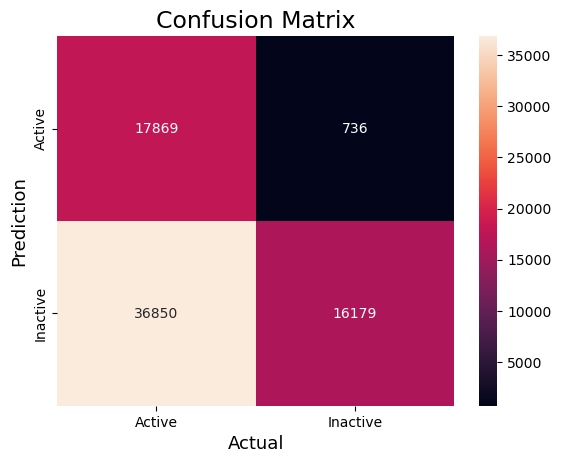

Precision: 0.3050972109600407
Recall: 0.9564883239728053
Epoch 218 | Train Loss 0.6379237174987793


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:15<00:00,  2.07it/s]

F1 Score: 0.46284276441826555
Accuracy: 0.47550046067509844


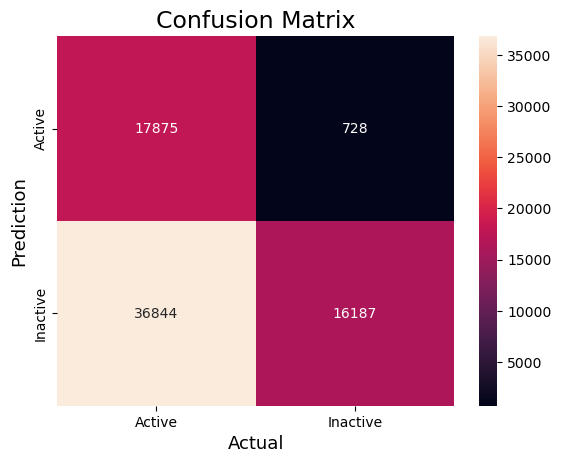

Precision: 0.3052365597480719
Recall: 0.9569612769731008
Epoch 219 | Train Loss 0.630413830280304


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
100%|██████████| 280/280 [02:14<00:00,  2.09it/s]

F1 Score: 0.46362921107216937
Accuracy: 0.4765753692380713


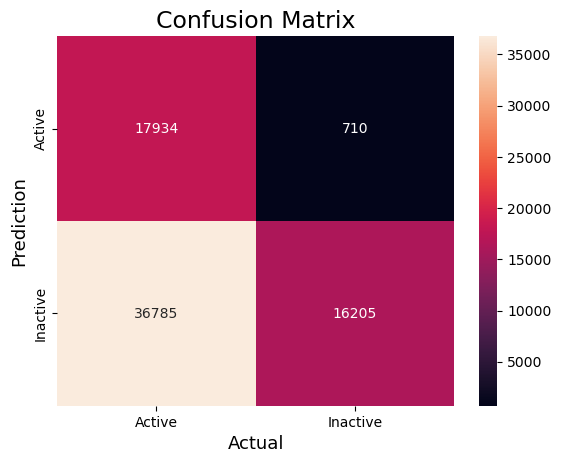

Precision: 0.3058124174372523
Recall: 0.9580254212237659
Epoch 220 | Train Loss 0.6192830801010132


  0%|          | 0/280 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch_geometric\utils\scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
  3%|▎         | 9/280 [00:04<02:06,  2.14it/s]

In [ ]:
for epoch in range(500):
        model.train()
        loss = train(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Train Loss {loss}")
        model.eval()
        scheduler.step()
print("done")

In [ ]:
for epoch in range(70):
        model.Predict()
        loss = Predict(epoch=epoch)
        loss = loss.detach().cpu().numpy()
        print(f"Epoch {epoch} | Test Loss {loss}")
        model.eval()
        scheduler.step()
print("done")